In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sns
import random
import plotly.graph_objects as go
import scipy.stats as stats

In [2]:
# set a global palette for seaborn
sns.set_palette("Accent", desat=1)
sns.set_style("white")
from matplotlib import rc

plt.rcParams['axes.grid'] = True
plt.rcParams['savefig.transparent'] = True

In [3]:
# load data
ego_updates = pd.read_csv('../Clean/ego_updates.csv')
stereo_updates = pd.read_csv('../Clean/stereo_updates.csv')
updates = pd.read_csv('../Clean/updates.csv')
stereo_characteristics_beliefs = pd.read_csv('../Clean/stereo_characteristics_beliefs.csv')


In [4]:
number_participants = len(updates['code'].unique())

# Make new columns

In [5]:
updates['round_misspecification'] = 0
updates.loc[updates['last_button']<updates['type'], 'round_misspecification'] = -1
updates.loc[updates['last_button']>updates['type'], 'round_misspecification'] = 1




# Create a task identifier

In [6]:
# assign a number code to each of the topics to create an id column that has the participant code and the topic they were updating on.
updates.loc[updates['topic']=='Math', 'topic_num'] = '1'
updates.loc[updates['topic']=='Science and Technology', 'topic_num'] = '2'
updates.loc[updates['topic']=='Verbal', 'topic_num'] = '3'
updates.loc[updates['topic']=='Pop-Culture and Art', 'topic_num'] = '4'
updates.loc[updates['topic']=='Sports and Video Games', 'topic_num'] = '5'
updates.loc[updates['topic']=='US Geography', 'topic_num'] = '6'

# make a column that combines the participant code and the topic number into a singe id for a participant in a task.
updates['player_code'] = updates['code']+updates['topic_num']

updates.reset_index(inplace=True)

# rename some columns

In [7]:
# need to rename the columns type and rate from updates to theta and omega
updates = updates.rename(columns={'type':'theta', 'rate':'omega'})

# Identify Subjects who are not learning

In [8]:
# for each player_code, look at the effort in each round starting at round_number 2 and compare it to the previous round
# if the effort is different, then add a value 1 to column 'effort_change'
# if the effort is the same, then add a value 0 to column 'effort_change'

updates['effort_change'] = np.where(updates['round_number']>1, 
                                     updates['effort'] - updates['effort'].shift(1), 
                                     0)

# create a column that indicates if the belief changed or not in that round relative to the previous round
updates['effort_change_indicator'] = 0
updates.loc[updates['effort_change']!=0, 'effort_change_indicator'] = 1
# split the sample into two. Those who never changed their belief and those who did
# to do so, first group by player_code and then check if the sum of the change_indicator is 0 or not
updates['effort_change_sum'] = updates.groupby('player_code')['effort_change_indicator'].transform('sum')

<AxesSubplot:xlabel='effort_change_sum', ylabel='Count'>

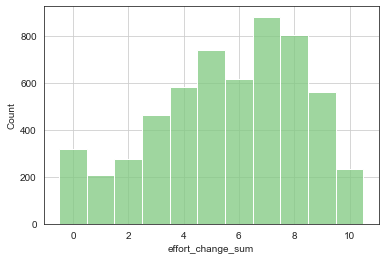

In [9]:
sns.histplot(updates['effort_change_sum'], discrete=True)

In [10]:
len(updates[updates['effort_change_sum']==10])/len(updates['effort_change_sum'])

0.040697674418604654

# Initial beliefs (reported and revealed)

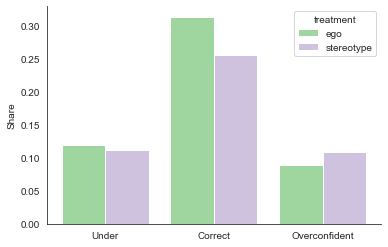

In [11]:
# from the table updates plot the shares of subjects in each of the misspecification categories
sns.set_style("white")

ax = sns.histplot(x="misspecification_num", hue="treatment", data=updates, 
                  multiple='dodge', stat='probability', shrink=.8, discrete=True)
sns.despine()
plt.xlabel('')
plt.xticks([-1,0,1], ['Under', 'Correct', 'Overconfident'])
plt.ylabel('Share')


#save figure
plt.savefig('../figures/misspecification_hist.png', dpi=300, bbox_inches='tight', transparent=True)

Text(0.5, 1.0, 'round 10')

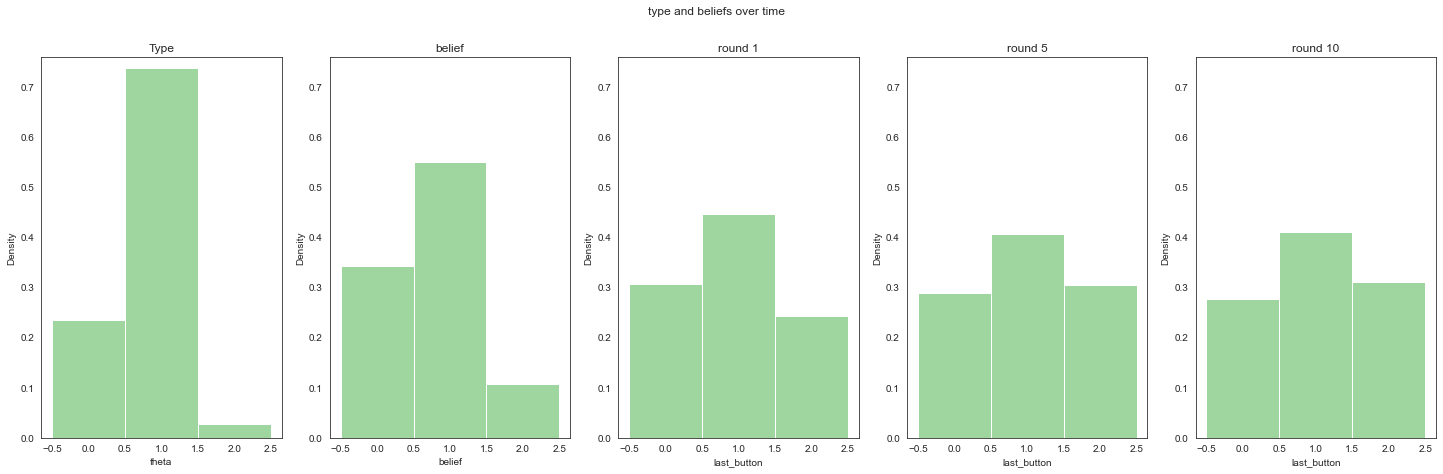

In [12]:
fig, axs = plt.subplots(1, 5, figsize=(25, 7))

fig.suptitle('type and beliefs over time')

sns.histplot(data=updates, x='theta', ax=axs[0], discrete=True, multiple='dodge', stat='density', )
sns.histplot(data=updates, x='belief', ax=axs[1], discrete=True, multiple='dodge', stat='density')
sns.histplot(data=updates[updates['round_number']==1], x='last_button', ax=axs[2], discrete=True, multiple='dodge', stat='density')
sns.histplot(data=updates[updates['round_number']==5], x='last_button', ax=axs[3], discrete=True, multiple='dodge', stat='density')
sns.histplot(data=updates[updates['round_number']==11], x='last_button', ax=axs[4], discrete=True, multiple='dodge', stat='density')

axs[0].set_ylim((0, .76))
axs[1].set_ylim((0, .76))
axs[2].set_ylim((0, .76))
axs[3].set_ylim((0, .76))
axs[4].set_ylim((0, .76))

axs[0].set_title('Type')
axs[1].set_title('belief')
axs[2].set_title('round 1')
axs[3].set_title('round 5')
axs[4].set_title('round 10')


            last_button_consistent
treatment                         
ego                       0.733333
stereotype                0.646341
            last_button_consistent
treatment                         
ego                       0.581481
stereotype                0.451220
            last_button_correct
treatment                      
ego                    0.511111
stereotype             0.394309
            last_button_correct
treatment                      
ego                    0.474074
stereotype             0.390244


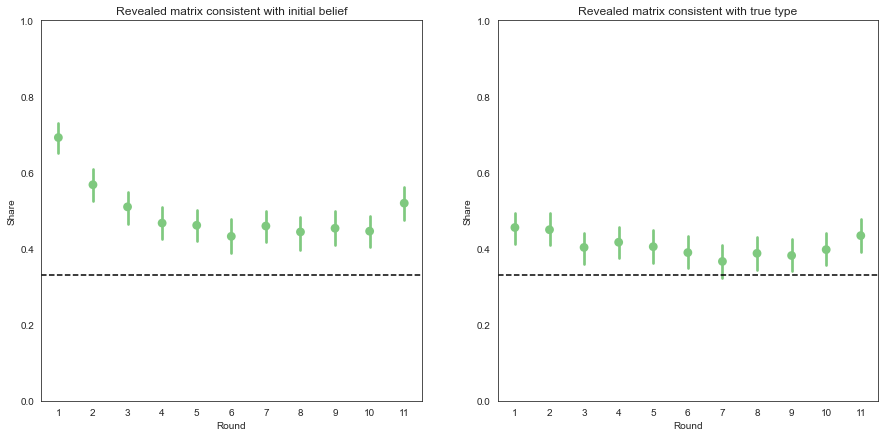

In [13]:
# calculate the share of player_codes for which last_button in round_number 1 is the same as belief
updates['last_button_consistent'] = updates['last_button'] == updates['belief']
updates['last_button_consistent'] = updates['last_button_consistent'].astype(int)

print(updates.loc[updates['round_number']==1, ['last_button_consistent', 'treatment']].groupby('treatment').mean())

print(updates.loc[updates['round_number']==11, ['last_button_consistent', 'treatment']].groupby('treatment').mean())

# calculate the share of subjects for whom the last button is the same as their theta
updates['last_button_correct'] = updates['last_button'] == updates['theta']
updates['last_button_correct'] = updates['last_button_correct'].astype(int)

print(updates.loc[updates['round_number']==1, ['last_button_correct', 'treatment']].groupby('treatment').mean())
print(updates.loc[updates['round_number']==11, ['last_button_correct', 'treatment']].groupby('treatment').mean())


# plot the share of player_codes for which last_button in round_number 1 is the same as belief
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
sns.set_style("white")
sns.pointplot(data=updates, x='round_number', y='last_button_consistent', dodge=True, ax=axs[0], join=False)
axs[0].set_ylim((0, 1))
axs[0].set_title('Revealed matrix consistent with initial belief')
axs[0].set_ylabel('Share')
axs[0].set_xlabel('Round')

sns.pointplot(data=updates, x='round_number', y='last_button_correct', 
            dodge=True, ax=axs[1], join=False)
axs[1].set_ylim((0, 1))
axs[1].set_title('Revealed matrix consistent with true type')
axs[1].set_ylabel('Share')
axs[1].set_xlabel('Round')

#plot a horizontal line at .33 in each plot
axs[0].axhline(y=.33, color='black', linestyle='--')
axs[1].axhline(y=.33, color='black', linestyle='--')

# save figure
plt.savefig('../figures/last_button_consistency.png', dpi=300, bbox_inches='tight')


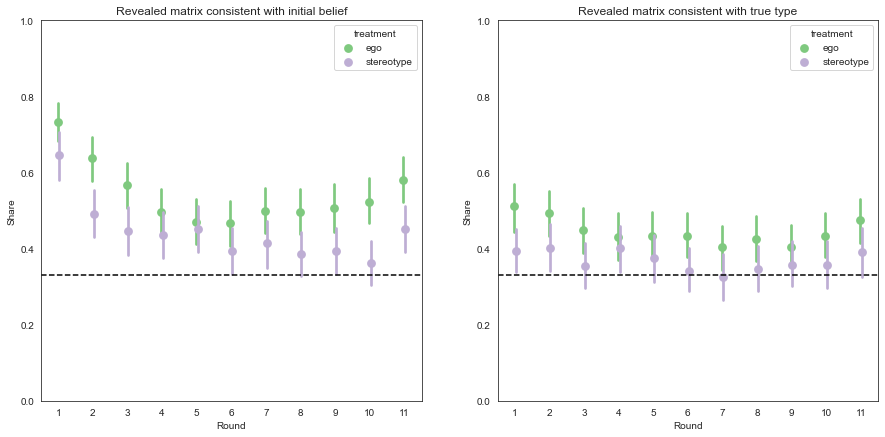

In [14]:
# calculate the share of player_codes for which last_button in round_number 1 is the same as bel


# plot the share of player_codes for which last_button in round_number 1 is the same as belief
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
sns.set_style("white")
sns.pointplot(data=updates, x='round_number', y='last_button_consistent', hue='treatment',
              dodge=True, ax=axs[0], join=False)
axs[0].set_ylim((0, 1))
axs[0].set_title('Revealed matrix consistent with initial belief')
axs[0].set_ylabel('Share')
axs[0].set_xlabel('Round')

sns.pointplot(data=updates, x='round_number', y='last_button_correct', hue='treatment',
            dodge=True, ax=axs[1], join=False)
axs[1].set_ylim((0, 1))
axs[1].set_title('Revealed matrix consistent with true type')
axs[1].set_ylabel('Share')
axs[1].set_xlabel('Round')

#plot a horizontal line at .33 in each plot
axs[0].axhline(y=.33, color='black', linestyle='--')
axs[1].axhline(y=.33, color='black', linestyle='--')

# save figure
plt.savefig('../figures/last_button_consistency_treatment.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Average believed type across time')

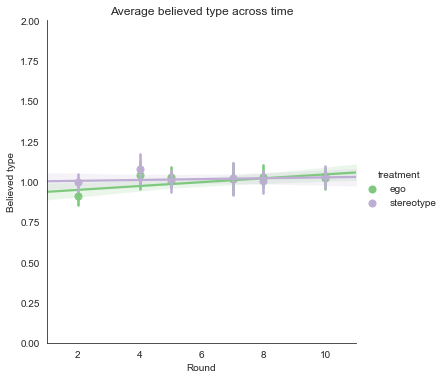

In [15]:
# plot the average believed type over time
sns.set_style("white")  
sns.lmplot(data=updates, x='round_number', y='last_button', hue='treatment', x_bins=6)
plt.ylim((0, 2))
plt.ylabel('Believed type')
plt.xlabel('Round')
plt.title('Average believed type across time')

(0.0, 1.0)

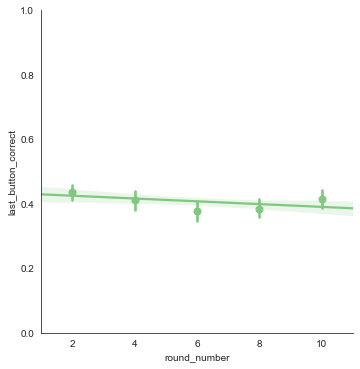

In [16]:
sns.lmplot(data=updates, x='round_number', y='last_button_correct', x_bins=5)
plt.ylim((0, 1))

In [17]:
# regress last_button_correct on round_number in updates
import statsmodels.api as sm
import statsmodels.formula.api as smf

# regress last_button_correct on round_number in updates
model = smf.ols(formula='last_button_correct ~ round_number', data=updates)
results = model.fit()

print(results.summary())



/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


                             OLS Regression Results                            
Dep. Variable:     last_button_correct   R-squared:                       0.001
Model:                             OLS   Adj. R-squared:                  0.001
Method:                  Least Squares   F-statistic:                     4.416
Date:                 Thu, 19 Oct 2023   Prob (F-statistic):             0.0356
Time:                         20:10:53   Log-Likelihood:                -4019.3
No. Observations:                 5676   AIC:                             8043.
Df Residuals:                     5674   BIC:                             8056.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.4339      0.014    

In [18]:
# create a column in updates called treatment_indic that is 1 if the treatment is stereotype
updates['treatment_indic'] = np.where(updates['treatment']=='stereotype', 1, 0)

# create a column in updates called interaction that is the product of update_indic and round_number
updates['interaction'] = updates['treatment_indic']*updates['round_number']

# regress last_button on round_number, update_indic and the interaction between the two to see if the slope is different across treatments

import statsmodels.api as sm
X = updates[['round_number', 'treatment_indic', 'interaction']]
y = updates['last_button']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            last_button   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.729
Date:                Thu, 19 Oct 2023   Prob (F-statistic):             0.0424
Time:                        20:10:53   Log-Likelihood:                -6648.2
No. Observations:                5676   AIC:                         1.330e+04
Df Residuals:                    5672   BIC:                         1.333e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.9245      0.031     30.083      0.000       0.864       0.985
round_number        0.0120      0.005      2.653      0.008       0.003       0.021
treatment_indic     0.0748      0.045      1.681      0.093      -0.012       0.162
interaction        -0.0093      0.007     -1.421      0.156      -0.022       0.004
==============================================================================
Omnibus:                   102873.040   Durbin-Watson:                   1.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              435.972
Skew:                          -0.012   Prob(JB):                     2.14e-95
Kurtosis:                       1.642   Cond. No.                         38.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
# create a column in updates called treatment_indic that is 1 if the treatment is stereotype
updates['treatment_indic'] = np.where(updates['treatment']=='stereotype', 1, 0)

# create a column in updates called interaction that is the product of update_indic and round_number
updates['interaction'] = updates['treatment_indic']*updates['round_number']

# regress last_button_correct on round_number, update_indic and the interaction between the two to see if the slope is different across treatments

import statsmodels.api as sm
X = updates[['round_number', 'treatment_indic', 'interaction']]
y = updates['last_button_correct']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     last_button_correct   R-squared:                       0.007
Model:                             OLS   Adj. R-squared:                  0.006
Method:                  Least Squares   F-statistic:                     13.16
Date:                 Thu, 19 Oct 2023   Prob (F-statistic):           1.47e-08
Time:                         20:10:53   Log-Likelihood:                -4001.9
No. Observations:                 5676   AIC:                             8012.
Df Residuals:                     5672   BIC:                             8038.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.4768      0.019     24.728      0.000       0.439       0.515
round_number       -0.0054      0.003     -1.895      0.058      -0.011       0.000
treatment_indic    -0.0900      0.028     -3.223      0.001      -0.145      -0.035
interaction         0.0022      0.004      0.537      0.592      -0.006       0.010
==============================================================================
Omnibus:                    22097.718   Durbin-Watson:                   1.271
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              925.362
Skew:                           0.371   Prob(JB):                    1.15e-201
Kurtosis:                       1.167   Cond. No.                         38.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
# test if the last_button_correct is different across treatments in the last round
stats.ttest_ind(updates.loc[(updates['round_number']==11) & (updates['treatment']=='ego'), 'last_button_correct'],
                updates.loc[(updates['round_number']==11) & (updates['treatment']=='stereotype'), 'last_button_correct'])

Ttest_indResult(statistic=1.922078334548765, pvalue=0.05514835543511212)

# Belief Changes

In [21]:
### Add columns to determine how the Subject's beliefs about their type changed across rounds
# for each task, determine whether their belief changed from the initial belief or not.
# check at every row if the belief is different from the last_button. 
updates['current_belief_start'] = updates['last_button'] - updates['belief']

# for rows in which rond_number is 2 or more, check if last_button is the same as last_button in the previous round_number for that player_code
# and register the size of the belief change in the column belief_change
updates['belief_change'] = np.where(updates['round_number']>1, 
                                     updates['last_button'] - updates['last_button'].shift(1), 
                                     updates['current_belief_start'])

# create a column that indicates if the belief changed or not in that round relative to the previous round
updates['change_indicator'] = 0
updates.loc[updates['belief_change']!=0, 'change_indicator'] = 1
# split the sample into two. Those who never changed their belief and those who did
# to do so, first group by player_code and then check if the sum of the change_indicator is 0 or not
updates['change_indicator_sum'] = updates.groupby('player_code')['change_indicator'].transform('sum')





In [22]:
epsilon_ego = updates.loc[updates['treatment']=='ego', 'change_indicator_sum'].mean()
epsilon_stereo = updates.loc[updates['treatment']=='stereotype', 'change_indicator_sum'].mean()

In [23]:
stats.ttest_ind(updates.loc[updates['treatment']=='ego', 'change_indicator_sum'], updates.loc[updates['treatment']=='stereotype', 'change_indicator_sum'])

Ttest_indResult(statistic=-14.603463035314489, pvalue=1.9207330753193665e-47)

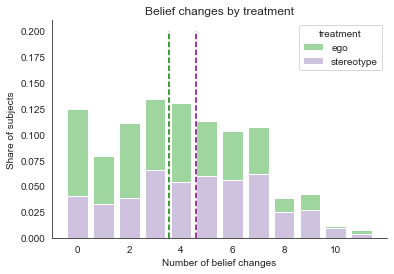

In [24]:
# if the indicator is more than 0 then the belief changed at least once and these subjects cannot possibly be dogmatic.
# plot the share of subjects for whom the belief never changed and the share for whom it did
sns.set_style("white")
sns.histplot(data=updates, x='change_indicator_sum', hue='treatment', multiple='stack', stat='probability', shrink=.8, discrete=True)
sns.despine()
plt.xlabel('Number of belief changes')
plt.ylabel('Share of subjects')
plt.title('Belief changes by treatment')

plt.vlines(x=epsilon_ego, ymin=0, ymax=.2, linestyles='--', colors='green', label='ego mean')
plt.vlines(x=epsilon_stereo, ymin=0, ymax=.2, linestyles='--', colors='purple', label='stereo mean')

# Which misspecifications persist the most?
Is there any evidence that people are overconfident?

In [25]:
# make a dataframe with the misspecifiactions in round round 11
# take the last round for each player_code
round_11 = updates.loc[updates['round_number']==11, :]
# check if last_button is above, below or equal to theta and register the misspecification in a column called last_specification_num
round_11.loc[round_11['last_button']>round_11['theta'], 'last_specification_num'] = 1
round_11.loc[round_11['last_button']==round_11['theta'], 'last_specification_num'] = 0
round_11.loc[round_11['last_button']<round_11['theta'], 'last_specification_num'] = -1




<ipython-input-25-d92d193fcc76>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round_11.loc[round_11['last_button']>round_11['theta'], 'last_specification_num'] = 1


In [26]:
#plot the share of subjects that started in each specification and ended in each of them
round_11.groupby(['misspecification_num', 'last_specification_num']).count()['code']/round_11.groupby(['misspecification_num']).count()['code']


misspecification_num  last_specification_num
-1                    -1.0                      0.466667
                       0.0                      0.291667
                       1.0                      0.241667
 0                    -1.0                      0.122449
                       0.0                      0.557823
                       1.0                      0.319728
 1                    -1.0                      0.049020
                       0.0                      0.245098
                       1.0                      0.705882
Name: code, dtype: float64

<ipython-input-27-b8126fd1d4f6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round_11.loc[round_11['last_specification_num']==-1, 'last_specification'] = 'under'


(0.0, 1.0)

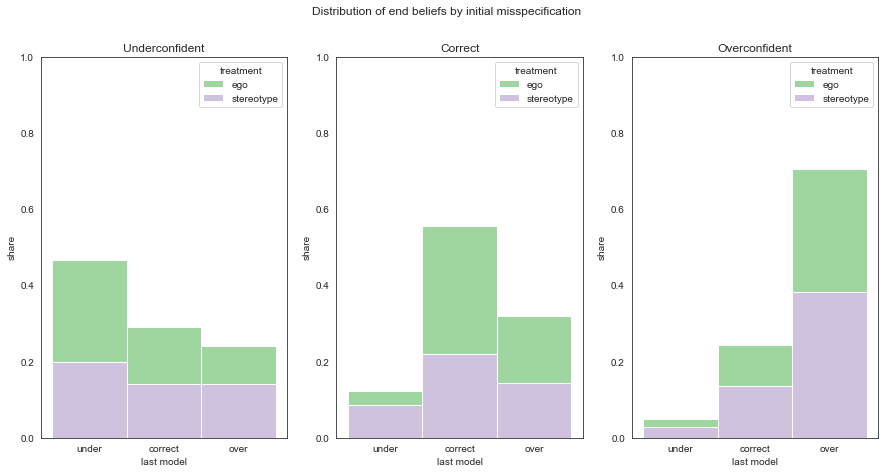

In [27]:
# for the data frame round_11, create a column called last_specification_num that is -1 if the last_specification is under, 0 if it is correct and 1 if it is over
round_11.loc[round_11['last_specification_num']==-1, 'last_specification'] = 'under'
round_11.loc[round_11['last_specification_num']==0, 'last_specification'] = 'correct'
round_11.loc[round_11['last_specification_num']==1, 'last_specification'] = 'over'

# plot 3 histograms side by side for each initial misspecification
fig, axs = plt.subplots(1, 3, figsize=(15, 7))
fig.suptitle('Distribution of end beliefs by initial misspecification')
# the first histogram is for those who began underconfident, what is the distribution of their last button in round 11
sns.histplot(data=round_11.loc[round_11['misspecification']=='under'], x='last_specification_num',  ax=axs[0], 
             stat='probability', discrete=True, hue='treatment', multiple='stack')
axs[0].set_title('Underconfident')
axs[0].set_ylabel('share')
axs[0].set_xlabel('last model')
axs[0].set_xticks([-1, 0, 1], ['under', 'correct', 'over'])
axs[0].set_ylim((0, 1))


# the second histogram is for those who began correct, what is the distribution of their last button in round 11
sns.histplot(data=round_11.loc[round_11['misspecification']=='correct'], x='last_specification_num', ax=axs[1], 
             stat='probability', discrete=True, hue='treatment', multiple='stack')
axs[1].set_title('Correct')
axs[1].set_ylabel('share')
axs[1].set_xlabel('last model')
axs[1].set_xticks([-1, 0, 1], ['under', 'correct', 'over'])
axs[1].set_ylim((0, 1))

# the third histogram is for those who began overconfident, what is the distribution of their last button in round 11
sns.histplot(data=round_11.loc[round_11['misspecification']=='over'], x='last_specification_num', ax=axs[2], 
             stat='probability', discrete=True, hue='treatment', multiple='stack')
axs[2].set_title('Overconfident')
axs[2].set_ylabel('share')
axs[2].set_xlabel('last model')
axs[2].set_xticks([-1, 0, 1], ['under', 'correct', 'over'])
axs[2].set_ylim((0, 1))


(0.0, 1.0)

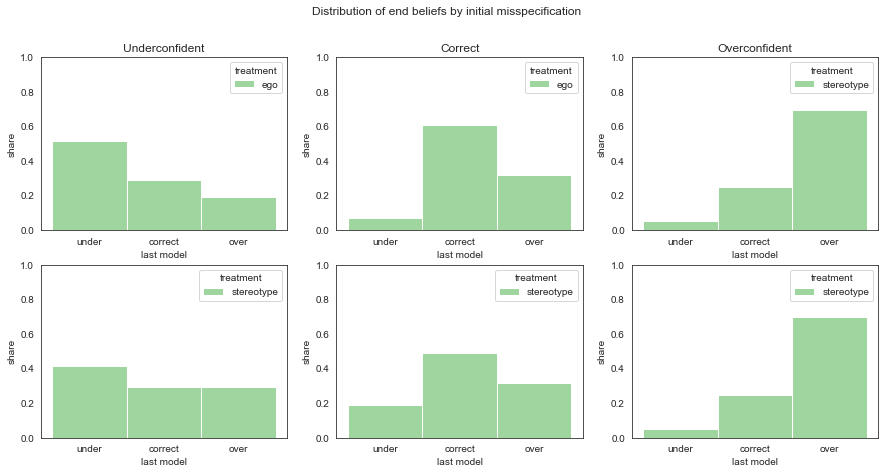

In [28]:
# plot 3 histograms side by side for each initial misspecification
fig, axs = plt.subplots(2, 3, figsize=(15, 7))
fig.suptitle('Distribution of end beliefs by initial misspecification')
# the first histogram is for those who began underconfident, what is the distribution of their last button in round 11
sns.histplot(data=round_11.loc[(round_11['misspecification']=='under')& (round_11['treatment']=='ego')], x='last_specification_num',  ax=axs[0,0], 
             stat='probability', discrete=True, hue='treatment', multiple='stack')
axs[0,0].set_title('Underconfident')
axs[0,0].set_ylabel('share')
axs[0,0].set_xlabel('last model')
axs[0,0].set_xticks([-1, 0, 1], ['under', 'correct', 'over'])
axs[0,0].set_ylim((0, 1))


# the second histogram is for those who began correct, what is the distribution of their last button in round 11
sns.histplot(data=round_11.loc[(round_11['misspecification']=='correct') & (round_11['treatment']=='ego')], x='last_specification_num', ax=axs[0,1], 
             stat='probability', discrete=True, hue='treatment', multiple='stack')
axs[0,1].set_title('Correct')
axs[0,1].set_ylabel('share')
axs[0,1].set_xlabel('last model')
axs[0,1].set_xticks([-1, 0, 1], ['under', 'correct', 'over'])
axs[0,1].set_ylim((0, 1))

# the third histogram is for those who began overconfident, what is the distribution of their last button in round 11
sns.histplot(data=round_11.loc[(round_11['misspecification']=='over') & (round_11['treatment']=='stereotype')], x='last_specification_num', ax=axs[0,2], 
             stat='probability', discrete=True, hue='treatment', multiple='stack')
axs[0,2].set_title('Overconfident')
axs[0,2].set_ylabel('share')
axs[0,2].set_xlabel('last model')
axs[0,2].set_xticks([-1, 0, 1], ['under', 'correct', 'over'])
axs[0,2].set_ylim((0, 1))


sns.histplot(data=round_11.loc[(round_11['misspecification']=='under')& (round_11['treatment']=='stereotype')], x='last_specification_num',  ax=axs[1,0], 
             stat='probability', discrete=True, hue='treatment', multiple='stack')
axs[1,0].set_title('')
axs[1,0].set_ylabel('share')
axs[1,0].set_xlabel('last model')
axs[1,0].set_xticks([-1, 0, 1], ['under', 'correct', 'over'])
axs[1,0].set_ylim((0, 1))


# the second histogram is for those who began correct, what is the distribution of their last button in round 11
sns.histplot(data=round_11.loc[(round_11['misspecification']=='correct') & (round_11['treatment']=='stereotype')], x='last_specification_num', ax=axs[1,1], 
             stat='probability', discrete=True, hue='treatment', multiple='stack')
axs[1,1].set_title('')
axs[1,1].set_ylabel('share')
axs[1,1].set_xlabel('last model')
axs[1,1].set_xticks([-1, 0, 1], ['under', 'correct', 'over'])
axs[1,1].set_ylim((0, 1))

# the third histogram is for those who began overconfident, what is the distribution of their last button in round 11
sns.histplot(data=round_11.loc[(round_11['misspecification']=='over') & (round_11['treatment']=='stereotype')], x='last_specification_num', ax=axs[1,2], 
             stat='probability', discrete=True, hue='treatment', multiple='stack')
axs[1,2].set_title('')
axs[1,2].set_ylabel('share')
axs[1,2].set_xlabel('last model')
axs[1,2].set_xticks([-1, 0, 1], ['under', 'correct', 'over'])
axs[1,2].set_ylim((0, 1))

In [29]:
round_11.groupby(['misspecification_num', 'last_specification_num']).count()['code']/round_11.count()['code']

misspecification_num  last_specification_num
-1                    -1.0                      0.108527
                       0.0                      0.067829
                       1.0                      0.056202
 0                    -1.0                      0.069767
                       0.0                      0.317829
                       1.0                      0.182171
 1                    -1.0                      0.009690
                       0.0                      0.048450
                       1.0                      0.139535
Name: code, dtype: float64

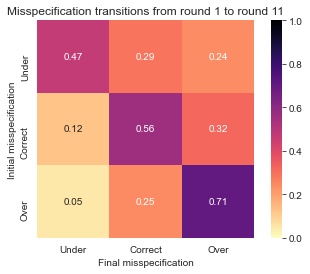

In [30]:
# plot a heat map of the share of subjects that started in each specification and ended in each of them
# create a data frame that has the share of subjects that started in each specification and ended in each of them
round_11_heat = round_11.groupby(['misspecification_num', 'last_specification_num']).count()['code']/round_11.groupby(['misspecification_num']).count()['code']
# unstack the data frame so that the rows are the initial misspecification and the columns are the final misspecification
round_11_heat = round_11_heat.unstack()
# plot the heat map
sns.heatmap(round_11_heat, annot=True, cmap='magma_r', 
            fmt='.2f', vmax=1, vmin=0, square=True, cbar=True, 
            xticklabels=['Under', 'Correct', 'Over'], yticklabels=['Under', 'Correct', 'Over'])
plt.title('Misspecification transitions from round 1 to round 11')
plt.ylabel('Initial misspecification')
plt.xlabel('Final misspecification')



# save the figure
plt.savefig('../figures/misspecification_transitions.png', dpi=300, bbox_inches='tight')


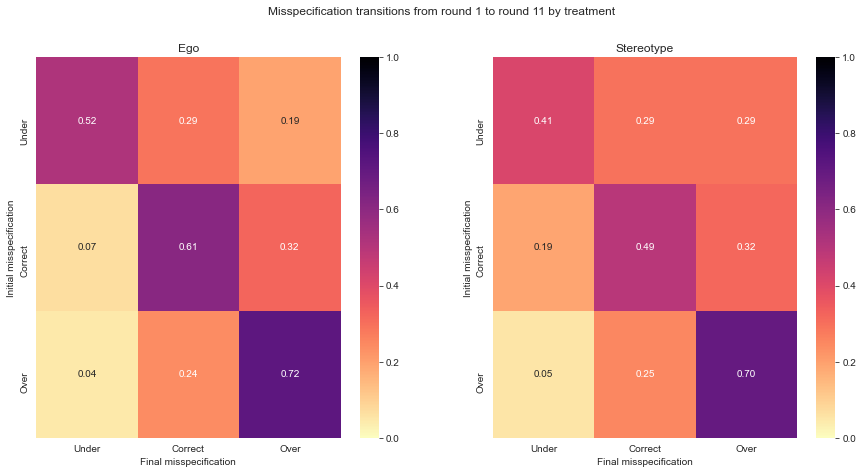

In [31]:
# plot a heat map of the share of subjects that started in each specification and ended in each of them. do one for each treatment
# side by side 
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Misspecification transitions from round 1 to round 11 by treatment')
# create a data frame that has the share of subjects that started in each specification and ended in each of them
round_11_ego = round_11[round_11['treatment']=='ego'].groupby(['misspecification_num', 'last_specification_num']).count()['code']/round_11[round_11['treatment']=='ego'].groupby(['misspecification_num']).count()['code']
# unstack the data frame so that the rows are the initial misspecification and the columns are the final misspecification
round_11_ego = round_11_ego.unstack()
# plot the heat map
sns.heatmap(round_11_ego, annot=True, cmap='magma_r', 
             xticklabels=['Under', 'Correct', 'Over'], yticklabels=['Under', 'Correct', 'Over'],
             fmt='.2f', ax=axs[0], vmax=1, vmin=0)
axs[0].set_title('Ego')
axs[0].set_ylabel('Initial misspecification')
axs[0].set_xlabel('Final misspecification')

round_11_stereo = round_11[round_11['treatment']=='stereotype'].groupby(['misspecification_num', 'last_specification_num']).count()['code']/round_11[round_11['treatment']=='stereotype'].groupby(['misspecification_num']).count()['code']
# unstack the data frame so that the rows are the initial misspecification and the columns are the final misspecification
round_11_stereo = round_11_stereo.unstack()
# plot the heat map
sns.heatmap(round_11_stereo, annot=True, cmap='magma_r',
              xticklabels=['Under', 'Correct', 'Over'], yticklabels=['Under', 'Correct', 'Over'],
              fmt='.2f', ax=axs[1], vmax=1, vmin=0)
axs[1].set_title('Stereotype')
axs[1].set_ylabel('Initial misspecification')
axs[1].set_xlabel('Final misspecification')

# save the figure
plt.savefig('../figures/misspecification_transitions_treatment.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'omega = 2')

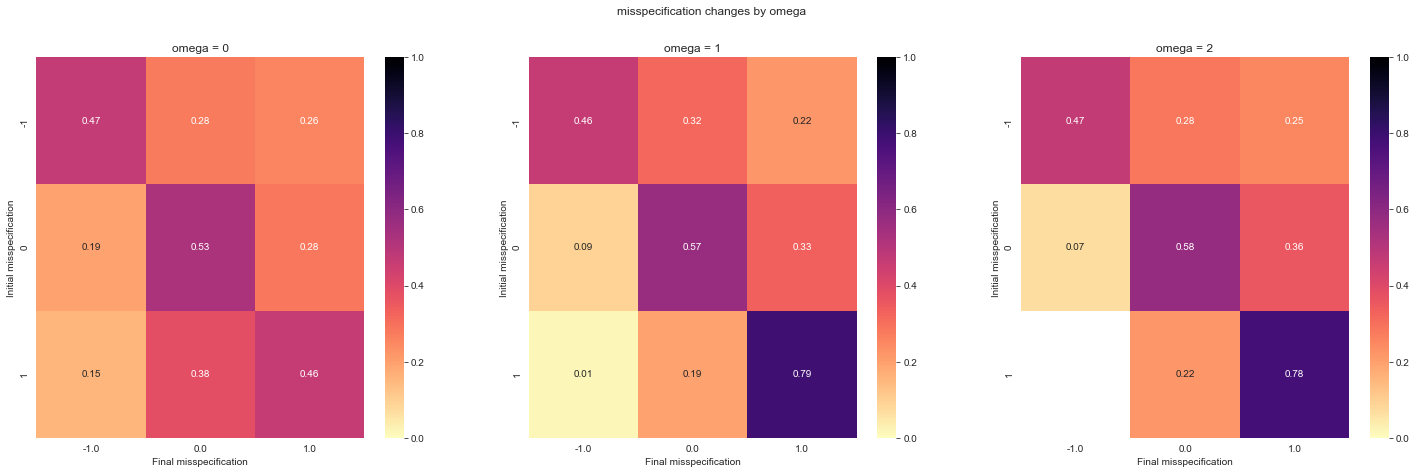

In [32]:
# do 3 heatmaps of the share of observations with each misspecification and each misspecification in round 11. one plot for each omega
# for omega = 0
fig, axs = plt.subplots(1, 3, figsize=(25, 7))
# plot a heat map of the share of subjects that started in each specification and ended in each of them
# create a data frame that has the share of subjects that started in each specification and ended in each of them
round_11_heat = round_11[round_11['omega']==0].groupby(['misspecification_num', 'last_specification_num']).count()['code']/round_11[(round_11['omega']==0)].groupby(['misspecification_num']).count()['code']
# unstack the data frame so that the rows are the initial misspecification and the columns are the final misspecification
round_11_heat = round_11_heat.unstack()
# plot the heat map
sns.heatmap(round_11_heat, annot=True, cmap='magma_r', fmt='.2f', ax=axs[0], vmax=1, vmin=0)
plt.suptitle('misspecification changes by omega')
axs[0].set_ylabel('Initial misspecification')
axs[0].set_xlabel('Final misspecification')
axs[0].set_title('omega = 0')

# for omega = 1
# plot a heat map of the share of subjects that started in each specification and ended in each of them
# create a data frame that has the share of subjects that started in each specification and ended in each of them
round_11_heat = round_11[round_11['omega']==1].groupby(['misspecification_num', 'last_specification_num']).count()['code']/round_11[(round_11['omega']==1)].groupby(['misspecification_num']).count()['code']
# unstack the data frame so that the rows are the initial misspecification and the columns are the final misspecification
round_11_heat = round_11_heat.unstack()
# plot the heat map
sns.heatmap(round_11_heat, annot=True, cmap='magma_r', fmt='.2f', ax=axs[1], vmax=1, vmin=0)
axs[1].set_ylabel('Initial misspecification')
axs[1].set_xlabel('Final misspecification')
axs[1].set_title('omega = 1')

# for omega = 2
# plot a heat map of the share of subjects that started in each specification and ended in each of them
# create a data frame that has the share of subjects that started in each specification and ended in each of them
round_11_heat = round_11[round_11['omega']==2].groupby(['misspecification_num', 'last_specification_num']).count()['code']/round_11[(round_11['omega']==2)].groupby(['misspecification_num']).count()['code']
# unstack the data frame so that the rows are the initial misspecification and the columns are the final misspecification
round_11_heat = round_11_heat.unstack()
# plot the heat map
sns.heatmap(round_11_heat, annot=True, cmap='magma_r', fmt='.2f', ax=axs[2], vmax=1, vmin=0)
axs[2].set_ylabel('Initial misspecification')
axs[2].set_xlabel('Final misspecification')
axs[2].set_title('omega = 2')


Text(0.5, 1.0, 'theta = 2')

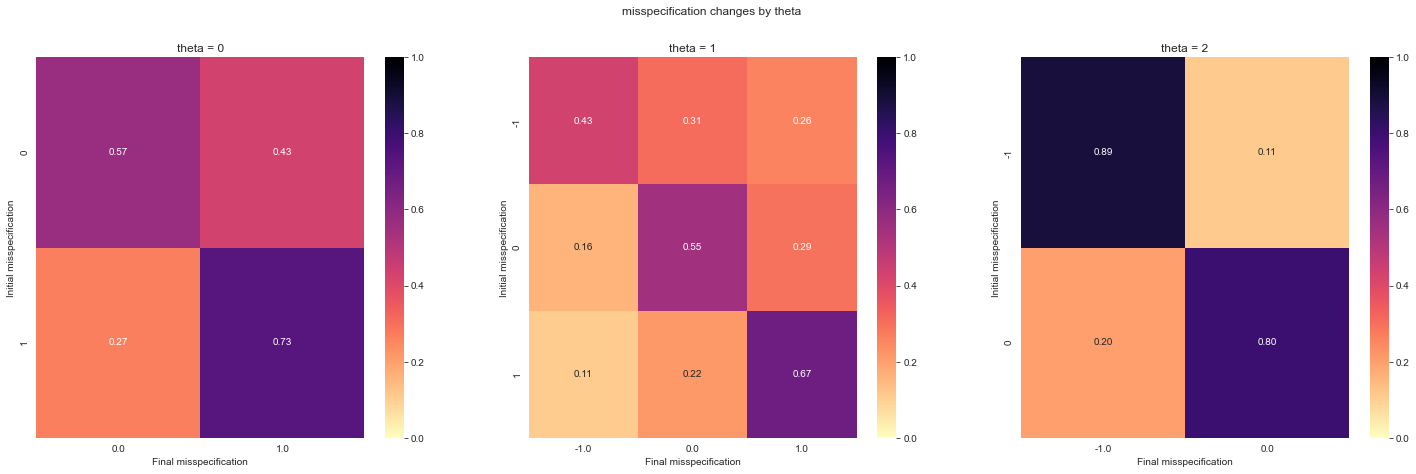

In [33]:
# do 3 heatmaps of the share of observations with each misspecification and each misspecification in round 11. one plot for each theta
# for theta = 0
fig, axs = plt.subplots(1, 3, figsize=(25, 7))
# plot a heat map of the share of subjects that started in each specification and ended in each of them
# create a data frame that has the share of subjects that started in each specification and ended in each of them
round_11_heat = round_11[round_11['theta']==0].groupby(['misspecification_num', 'last_specification_num']).count()['code']/round_11[(round_11['theta']==0)].groupby(['misspecification_num']).count()['code']
# unstack the data frame so that the rows are the initial misspecification and the columns are the final misspecification
round_11_heat = round_11_heat.unstack()
# plot the heat map
sns.heatmap(round_11_heat, annot=True, cmap='magma_r', fmt='.2f', ax=axs[0], vmax=1, vmin=0)
plt.suptitle('misspecification changes by theta')
axs[0].set_ylabel('Initial misspecification')
axs[0].set_xlabel('Final misspecification')
axs[0].set_title('theta = 0')

# for theta = 1
# plot a heat map of the share of subjects that started in each specification and ended in each of them
# create a data frame that has the share of subjects that started in each specification and ended in each of them
round_11_heat = round_11[round_11['theta']==1].groupby(['misspecification_num', 'last_specification_num']).count()['code']/round_11[(round_11['theta']==1)].groupby(['misspecification_num']).count()['code']
# unstack the data frame so that the rows are the initial misspecification and the columns are the final misspecification
round_11_heat = round_11_heat.unstack()
# plot the heat map
sns.heatmap(round_11_heat, annot=True, cmap='magma_r', fmt='.2f', ax=axs[1], vmax=1, vmin=0)
axs[1].set_ylabel('Initial misspecification')
axs[1].set_xlabel('Final misspecification')
axs[1].set_title('theta = 1')

# for theta = 2
# plot a heat map of the share of subjects that started in each specification and ended in each of them
# create a data frame that has the share of subjects that started in each specification and ended in each of them
round_11_heat = round_11[round_11['theta']==2].groupby(['misspecification_num', 'last_specification_num']).count()['code']/round_11[(round_11['theta']==2)].groupby(['misspecification_num']).count()['code']
# unstack the data frame so that the rows are the initial misspecification and the columns are the final misspecification
round_11_heat = round_11_heat.unstack()
# plot the heat map
sns.heatmap(round_11_heat, annot=True, cmap='magma_r', fmt='.2f', ax=axs[2], vmax=1, vmin=0)
axs[2].set_ylabel('Initial misspecification')
axs[2].set_xlabel('Final misspecification')
axs[2].set_title('theta = 2')

# Testing the transitions


# Choices one step ahead

Text(0.5, 1.0, 'Heat map of effort changes one round ahead')

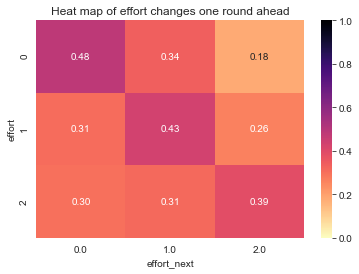

In [34]:
# plot a heat map of the share of subjects that chose each of the effort_next after each value of effort

# in the data frame updates, create a column called effort_next which is the effort chosen in the next round_number
updates['effort_next'] = updates['effort'].shift(-1)

# create a data frame that has the share of subjects that chose each of the effort_next after each value of effort
effort_heat = updates[(updates['round_number']<11)].groupby(['effort', 'effort_next']).count()['code']/updates[(updates['round_number']<11)].groupby(['effort']).count()['code']
# unstack the data frame so that the rows are the initial misspecification and the columns are the final misspecification
effort_heat = effort_heat.unstack()
# plot the heat map
sns.heatmap(effort_heat, annot=True, cmap='magma_r', fmt='.2f', vmax=1, vmin=0)
plt.title('Heat map of effort changes one round ahead')


## are choices one step ahead different by omega

Text(0.5, 1.0, 'Heat map of effort changes one round ahead for omega = 0')

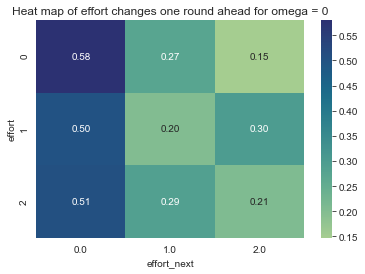

In [35]:
# for omega = 0
# create a data frame that has the share of subjects that chose each of the effort_next after each value of effort
effort_heat = updates[(updates['round_number']<11) & (updates['omega']==0)].groupby(['effort', 'effort_next']).count()['code']/updates[(updates['round_number']<11) & (updates['omega']==0)].groupby(['effort']).count()['code']
# unstack the data frame so that the rows are the initial misspecification and the columns are the final misspecification
effort_heat = effort_heat.unstack()
# plot the heat map
sns.heatmap(effort_heat, annot=True, cmap='crest', fmt='.2f')
plt.title('Heat map of effort changes one round ahead for omega = 0')




Text(0.5, 1.0, 'Heat map of effort changes one round ahead for omega = 1')

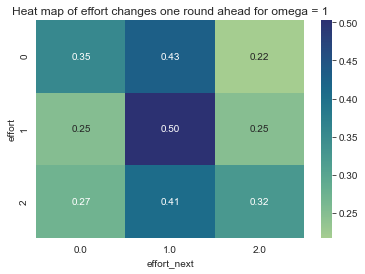

In [36]:
# for omega = 0
# create a data frame that has the share of subjects that chose each of the effort_next after each value of effort
effort_heat = updates[(updates['round_number']<11) & (updates['omega']==1)].groupby(['effort', 'effort_next']).count()['code']/updates[(updates['round_number']<11) & (updates['omega']==1)].groupby(['effort']).count()['code']
# unstack the data frame so that the rows are the initial misspecification and the columns are the final misspecification
effort_heat = effort_heat.unstack()
# plot the heat map
sns.heatmap(effort_heat, annot=True, cmap='crest', fmt='.2f')
plt.title('Heat map of effort changes one round ahead for omega = 1')

Text(0.5, 1.0, 'Heat map of effort changes one round ahead for omega = 2')

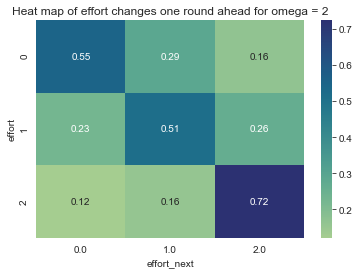

In [37]:
# for omega = 0
# create a data frame that has the share of subjects that chose each of the effort_next after each value of effort
effort_heat = updates[(updates['round_number']<11) & (updates['omega']==2)].groupby(['effort', 'effort_next']).count()['code']/updates[(updates['round_number']<11) & (updates['omega']==2)].groupby(['effort']).count()['code']
# unstack the data frame so that the rows are the initial misspecification and the columns are the final misspecification
effort_heat = effort_heat.unstack()
# plot the heat map
sns.heatmap(effort_heat, annot=True, cmap='crest', fmt='.2f')
plt.title('Heat map of effort changes one round ahead for omega = 2')

# Stereotypes

In [38]:
stereo_characteristics_beliefs.columns

Index(['belief_self', 'certainty_self', 'topic', 'gender_other',
       'nationality_other', 'code', 'belief', 'certainty', 'gender',
       'nationality', 'belief_other', 'certainty_other', 'misspecification',
       'round_number'],
      dtype='object')

In [39]:
# create a column in stereo_characteristics_beliefs called misspecification_num that is -1 if the misspecification is under, 0 if it is correct and 1 if it is over
stereo_characteristics_beliefs.loc[stereo_characteristics_beliefs['misspecification']=='under', 'misspecification_num'] = -1
stereo_characteristics_beliefs.loc[stereo_characteristics_beliefs['misspecification']=='correct', 'misspecification_num'] = 0
stereo_characteristics_beliefs.loc[stereo_characteristics_beliefs['misspecification']=='over', 'misspecification_num'] = 1

Text(0.5, 1.0, 'Distribution of misspecifications in the stereotype treatment')

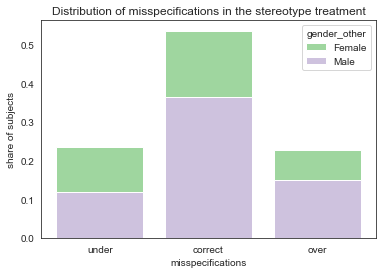

In [40]:
# plot the distribution of misspecifications by gender of the other
sns.histplot(data = stereo_characteristics_beliefs, 
             x='misspecification_num', 
             hue = 'gender_other', 
             discrete= True, 
             stat = 'probability', 
             multiple = 'stack', 
             shrink=.8)

plt.xticks([-1, 0, 1], ['under', 'correct', 'over'])
plt.xlabel('misspecifications')
plt.ylabel('share of subjects')
plt.title('Distribution of misspecifications in the stereotype treatment')


In [41]:
characteristics = stereo_characteristics_beliefs
characteristics['misspecification_num'] = np.where(characteristics['misspecification']=='over', 1, 0)
characteristics['misspecification_num'] = np.where(characteristics['misspecification']=='correct', 0,  characteristics['misspecification_num'])
characteristics['misspecification_num'] = np.where(characteristics['misspecification']=='under', -1,  characteristics['misspecification_num'])

(0.0, 1.0)

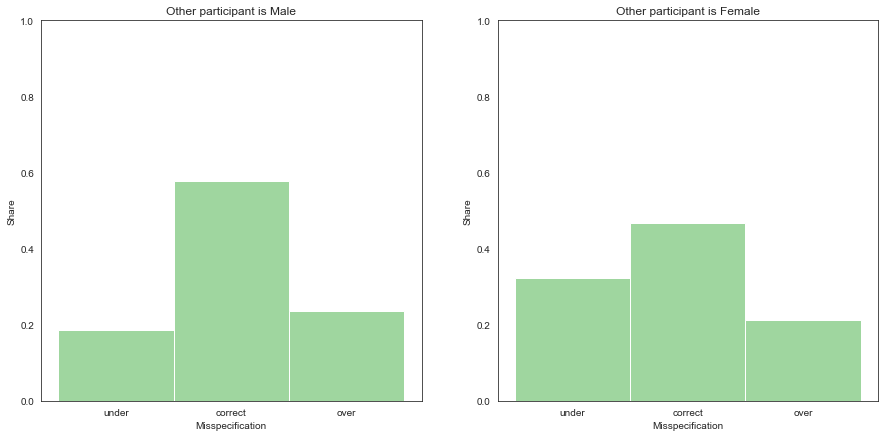

In [42]:

# make 2 plots side by side of the misspecification distribution for each of the gender_other
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
sns.histplot(data = characteristics[characteristics['gender_other']=='Male'], x='misspecification_num', discrete=True, stat='probability', multiple='stack', ax=axs[0])
axs[0].set_title('Other participant is Male')
axs[0].set_ylabel('Share')
axs[0].set_xlabel('Misspecification')
axs[0].set_xticks([-1, 0, 1], ['under', 'correct', 'over'])
axs[0].set_ylim((0, 1))
sns.histplot(data = characteristics[characteristics['gender_other']=='Female'], x='misspecification_num', discrete=True, stat='probability', multiple='stack', ax=axs[1])
axs[1].set_title('Other participant is Female')
axs[1].set_ylabel('Share')
axs[1].set_xlabel('Misspecification')
axs[1].set_xticks([-1, 0, 1], ['under', 'correct', 'over'])
axs[1].set_ylim((0, 1))





Text(0, 0.5, 'Belief/type')

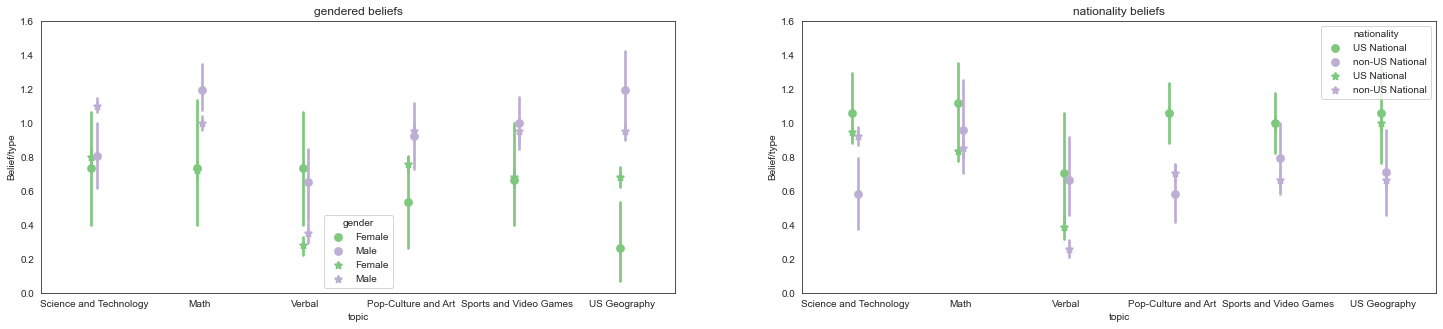

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5))
sns.pointplot(data=characteristics, x='topic', y='belief_other', hue='gender_other', dodge=True, join=False, ax=axs[0], hue_order=['Female', 'Male'])

sns.pointplot(data=updates[updates['treatment']=='ego'], x='topic', y='theta', hue='gender', 
              markers='*', dodge=True, join=False, ax=axs[0], errorbar=None, hue_order=['Female', 'Male'])
axs[0].set_title('gendered beliefs')
axs[0].set_ylim((0, 1.6))
axs[0].set_ylabel('Belief/type')

#plot the average belief b topic and nationality_other
sns.pointplot(data=characteristics, x='topic', y='belief_other', hue='nationality_other', dodge=True, join=False, ax=axs[1], 
              hue_order=['US National', 'non-US National'])

sns.pointplot(data=updates[updates['treatment']=='ego'], x='topic', y='theta', hue='nationality', 
              markers='*', dodge=True, join=False, ax=axs[1], errorbar=None, hue_order=['US National', 'non-US National'])
axs[1].set_title('nationality beliefs')
axs[1].set_ylim((0, 1.6))
axs[1].set_ylabel('Belief/type')



Text(0.5, 1.0, 'believed scores by characteristics')

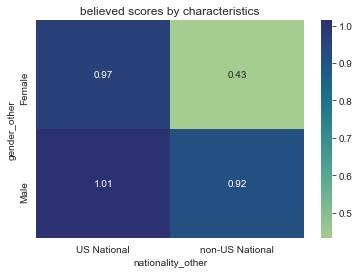

In [44]:
# make a heat map of the belief_other by gender_other and nationality_other
# create a data frame that has average belief_other by each combination of gender_other and nationality_other
gender_nationality = characteristics.groupby(['gender_other', 'nationality_other']).mean()['belief_other']

gender_nationality= gender_nationality.unstack()

sns.heatmap(gender_nationality, annot=True, cmap='crest', fmt='.2f')
plt.title('believed scores by characteristics')



Text(0.5, 1.0, 'believed scores by characteristics')

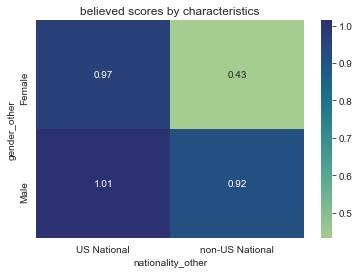

In [45]:
# number of participants in each category
# make a heat map of the belief_other by gender_other and nationality_other
# create a data frame that has average belief_other by each combination of gender_other and nationality_other
gender_nationality = characteristics.groupby(['gender_other', 'nationality_other']).mean()['belief_other']

gender_nationality= gender_nationality.unstack()

sns.heatmap(gender_nationality, annot=True, cmap='crest', fmt='.2f')
plt.title('believed scores by characteristics')

In [46]:
topics = characteristics['topic'].unique()

Text(0.5, 1.0, 'Sports and Video Games')

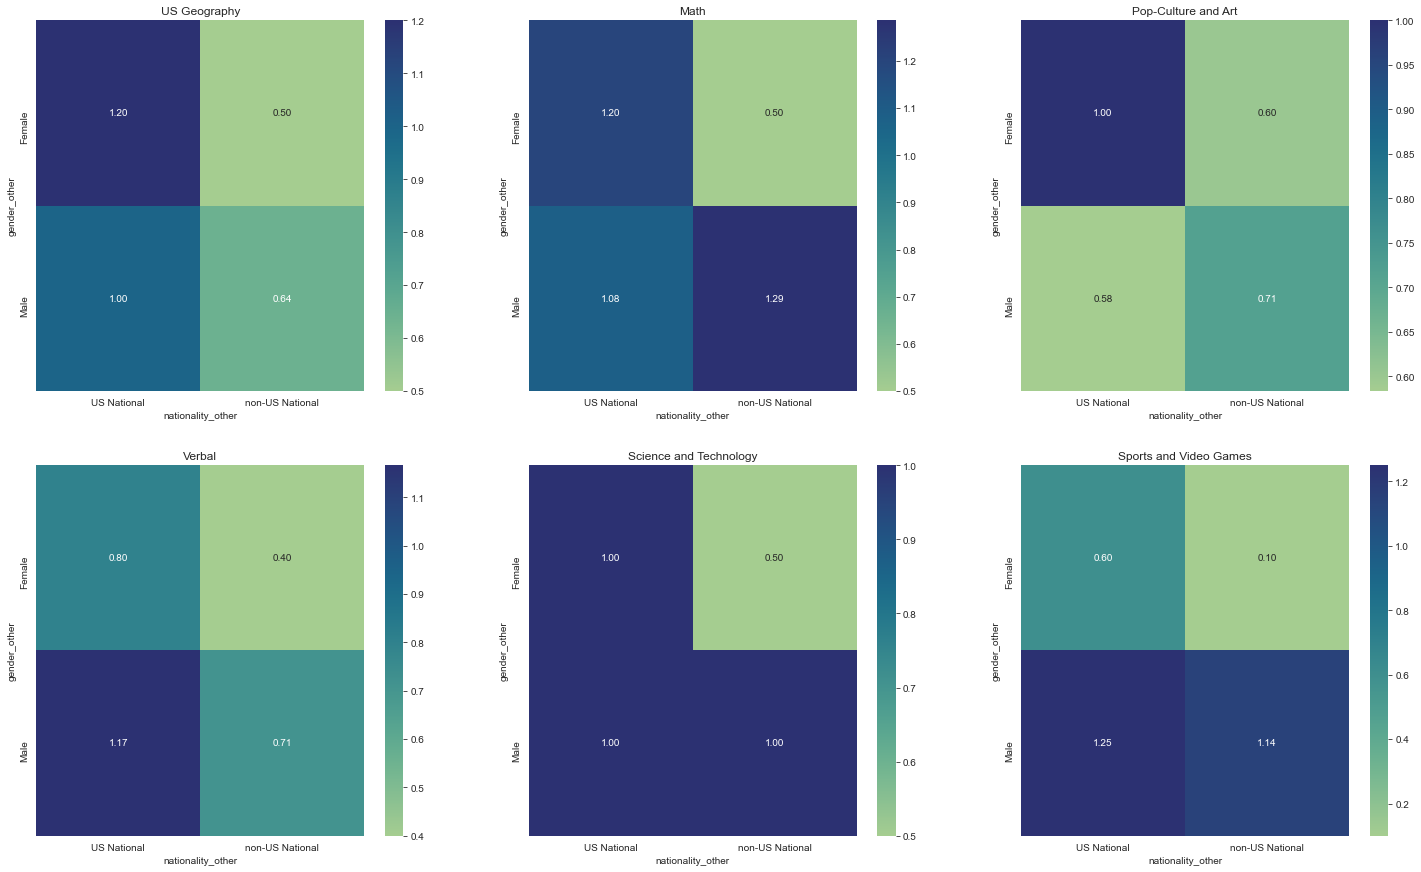

In [47]:
# make a heat map of the belief_other by gender_other and nationality_other for each topic
fig, axs = plt.subplots(2, 3, figsize=(25, 15))
# create a data frame that has average belief_other by each combination of gender_other and nationality_other
gender_nationality_0 = characteristics[characteristics['topic']==topics[0]].groupby(['gender_other', 'nationality_other']).mean()['belief']

gender_nationality_0= gender_nationality_0.unstack()

sns.heatmap(gender_nationality_0, annot=True, cmap='crest', fmt='.2f', ax=axs[0, 0])
axs[0, 0].set_title(topics[0])

gender_nationality_1 = characteristics[characteristics['topic']==topics[1]].groupby(['gender_other', 'nationality_other']).mean()['belief']

gender_nationality_1= gender_nationality_1.unstack()

sns.heatmap(gender_nationality_1, annot=True, cmap='crest', fmt='.2f', ax=axs[0, 1])
axs[0, 1].set_title(topics[1])

gender_nationality_2 = characteristics[characteristics['topic']==topics[2]].groupby(['gender_other', 'nationality_other']).mean()['belief']

gender_nationality_2= gender_nationality_2.unstack()

sns.heatmap(gender_nationality_2, annot=True, cmap='crest', fmt='.2f', ax=axs[0, 2])
axs[0, 2].set_title(topics[2])

gender_nationality_3 = characteristics[characteristics['topic']==topics[3]].groupby(['gender_other', 'nationality_other']).mean()['belief']

gender_nationality_3= gender_nationality_3.unstack()

sns.heatmap(gender_nationality_3, annot=True, cmap='crest', fmt='.2f', ax=axs[1, 0])
axs[1, 0].set_title(topics[3])

gender_nationality_4 = characteristics[characteristics['topic']==topics[4]].groupby(['gender_other', 'nationality_other']).mean()['belief']

gender_nationality_4= gender_nationality_4.unstack()

sns.heatmap(gender_nationality_4, annot=True, cmap='crest', fmt='.2f', ax=axs[1, 1])
axs[1, 1].set_title(topics[4])

gender_nationality_5 = characteristics[characteristics['topic']==topics[5]].groupby(['gender_other', 'nationality_other']).mean()['belief']

gender_nationality_5= gender_nationality_5.unstack()

sns.heatmap(gender_nationality_5, annot=True, cmap='crest', fmt='.2f', ax=axs[1, 2])
axs[1, 2].set_title(topics[5])


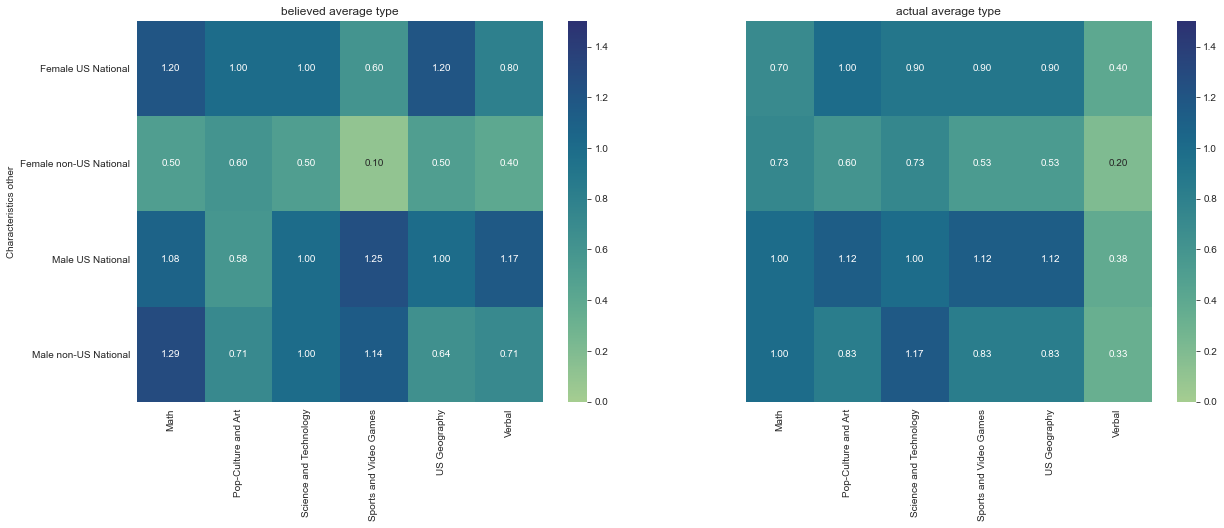

In [48]:
characteristics['gender_nationality_other']=characteristics['gender_other']+' '+ characteristics['nationality_other']

# make a heat map of the belief_other by gender_other and nationality_other
# create a data frame that has average belief_other by each combination of gender_other and nationality_other
topic_charact = characteristics.groupby(['gender_nationality_other', 'topic']).mean()['belief_other']

topic_charact= topic_charact.unstack()

fig, axs = plt.subplots(1, 2, figsize=(20, 7))
sns.heatmap(topic_charact, annot=True, cmap='crest', fmt='.2f', ax=axs[0], cbar=True, vmin=0, vmax=1.5)
axs[0].set_title('believed average type')

# the true average scores
updates['gender_nationality'] = updates['gender'] + ' ' + updates['nationality']

# make a heat map of the belief_other by gender_other and nationality_other
# create a data frame that has average belief_other by each combination of gender_other and nationality_other
topic_charact = updates[updates['treatment']=='ego'].groupby(['gender_nationality', 'topic']).mean()['theta']

topic_charact= topic_charact.unstack()

sns.heatmap(topic_charact, annot=True, cmap='crest', fmt='.2f', ax=axs[1], yticklabels=False, vmin=0, vmax=1.5)
axs[1].set_title('actual average type')
axs[1].set_ylabel('')

axs[0].set_ylabel('Characteristics other')
axs[0].set_xlabel('')
axs[1].set_xlabel('')

# save the figure
plt.savefig('../figures/believed_actual_type_heat.png', dpi=300, bbox_inches='tight')

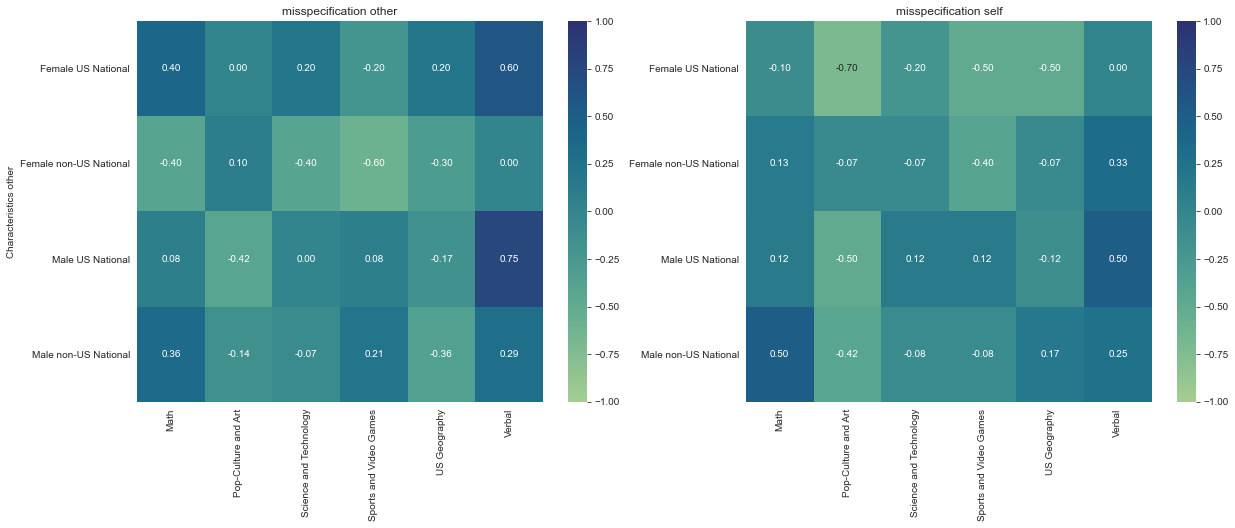

In [49]:
# make a heat map of the belief_other by gender_other and nationality_other
# create a data frame that has average belief_other by each combination of gender_other and nationality_other
topic_charact = characteristics.groupby(['gender_nationality_other', 'topic']).mean()['misspecification_num']

topic_charact= topic_charact.unstack()

fig, axs = plt.subplots(1, 2, figsize=(20, 7))
sns.heatmap(topic_charact, annot=True, cmap='crest', fmt='.2f', cbar=True, vmin=-1, vmax=1, ax=axs[0])
axs[0].set_title('misspecification other')

topic_charact = updates[updates['treatment']=='ego'].groupby(['gender_nationality', 'topic']).mean()['misspecification_num']

topic_charact= topic_charact.unstack()
sns.heatmap(topic_charact, annot=True, cmap='crest', fmt='.2f', cbar=True, vmin=-1, vmax=1, ax=axs[1])
axs[1].set_title('misspecification self')

axs[0].set_ylabel('Characteristics other')
axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[1].set_ylabel('')

# save
plt.savefig('../figures/misspecifications_characteristics_treatment.png', dpi=300, bbox_inches='tight')

# Correlation belief_self and belief_other

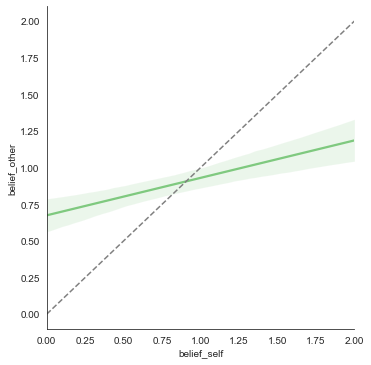

In [50]:
sns.lmplot(data=characteristics, x='belief_self', y='belief_other', scatter=False)
# add the identity line
plt.plot([0, 2], [0, 2], color='gray', linestyle='--')

# Evolution of misspecifications

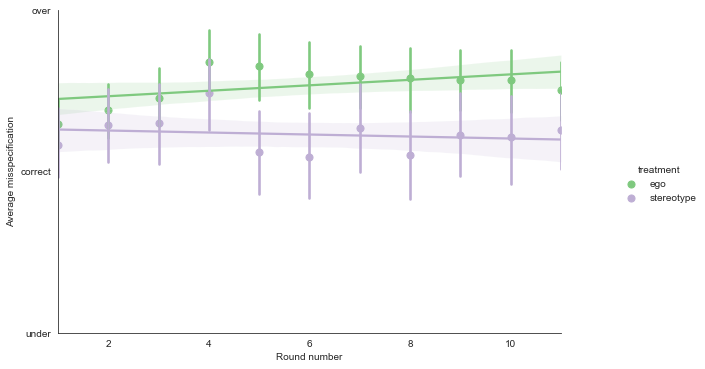

In [51]:
sns.lmplot(data=updates[updates['misspecification']=='correct'], x='round_number', y='round_misspecification', 
           hue='treatment', hue_order=['ego', 'stereotype'], 
           x_bins=11)
plt.ylim((-.5, .5))

plt.ylabel('Average misspecification')
plt.xlabel('Round number')

plt.yticks([-.5, 0, .5], ['under', 'correct', 'over'])

# adjust size to make wider
plt.gcf().set_size_inches(10, 5)

# save the figure
plt.savefig('../figures/misspecification_round.png', dpi=300, bbox_inches='tight')

In [52]:
import stargazer

In [53]:
# regression of misspecification on round number and interacted with treatment
# create a column that is 1 if the treatment is stereotype and 0 if it is ego
updates['stereotype'] = np.where(updates['treatment']=='stereotype', 1, 0)

# create a column that is the interaction of stereotype and round number
updates['stereotype_round'] = updates['stereotype']*updates['round_number']



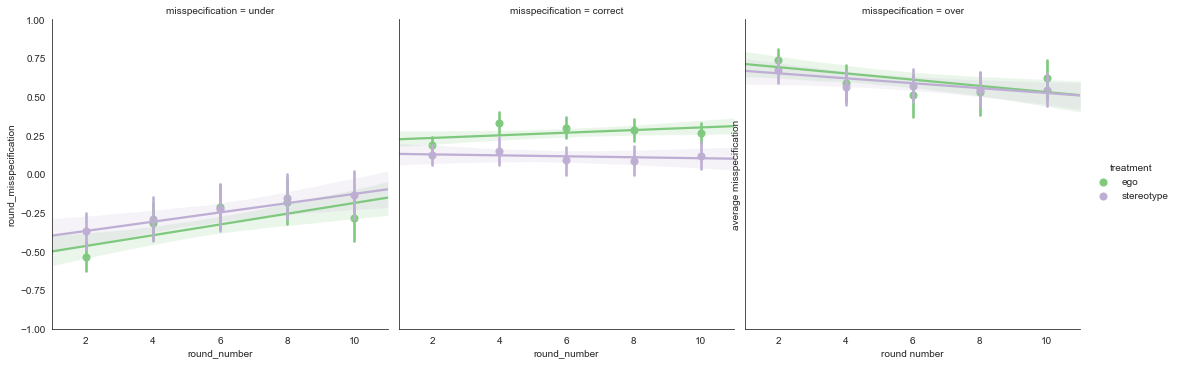

In [54]:
# plot the average misspecification by round_number
sns.lmplot(data=updates, x='round_number', y='round_misspecification', 
           hue='treatment', hue_order=['ego', 'stereotype'], 
           x_bins=5, col='misspecification', col_order=['under', 'correct', 'over'])

plt.ylim((-1, 1))
plt.ylabel('average misspecification')
plt.xlabel('round number')


# save
plt.savefig('../figures/misspecification_round_treatment.png', dpi=300, bbox_inches='tight')


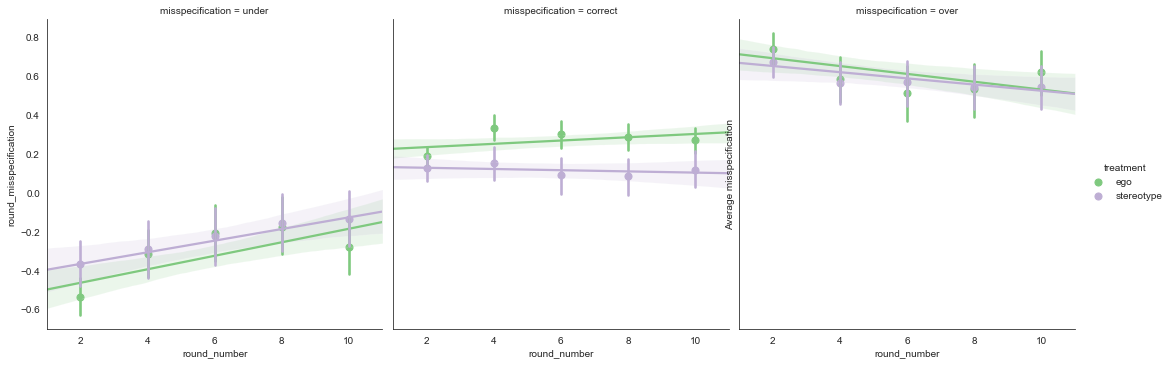

In [55]:
# plot the average misspecification by round_number
sns.lmplot(data=updates, x='round_number', y='round_misspecification', x_bins=5, 
           hue='treatment', hue_order=['ego', 'stereotype'], col='misspecification', col_order=['under', 'correct', 'over'])
plt.ylabel('Average misspecification')


# save
plt.savefig('../figures/misspecification_evolution_tratment.png', dpi=300, bbox_inches='tight')

(-1.0, 1.0)

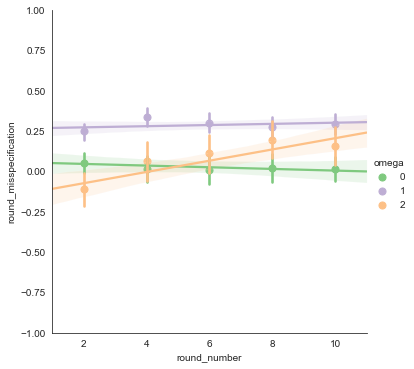

In [56]:
# plot the average misspecification by round_number and by omega
sns.lmplot(data=updates, x='round_number', y='round_misspecification', x_bins=5, hue='omega', hue_order=[0, 1, 2])
plt.ylim((-1, 1))


# Compute the Likelihoods

In [57]:
## Likelihoods
#for each subject, calulate the likelihood of each of the types given the signals they saw.
# the probability matrices are needed for th calculatin of the likelihood
ml = np.array([[.20, .25, .40], [.07, .30, .45], [.02, .20, .50]])
mm = np.array([[.40, .45, .65], [.30, .65, .69], [.05, .50, .80]])
mh = np.array([[.45, .55, .75], [.35, .69, .80], [.25, .65, .98]])

msc = [ml, mm, mh]

for i in range(len(updates['player_code'].unique())):
    # get a single path for a single player
    c = updates['player_code'].unique()[i]
    player = updates.loc[updates['player_code']==c, :]
    # for each round get the history of (effort, signal) pairs up to that round
    p_t=[]
    lr_t=[]
    prior = [1/3, 1/3, 1/3]

    for t in [a+2 for a in range(10)]:
        
        e_t = int(player.loc[player['round_number']==t, 'effort'])
        theta = int(player.loc[player['round_number']==t, 'theta'])
        belief_prev = int(player.loc[player['round_number']==t-1, 'last_button'])
        belief_new = int(player.loc[player['round_number']==t, 'last_button'])
        omega = int(player.loc[player['round_number']==t, 'omega'])
        s_t = int(player.loc[player['round_number']==t, 'signal'])
        f_t = 10-s_t

        # update the belief about omega for each of the types separately
        posterior_new = np.diag(np.diagflat(prior)@np.diagflat(sp.stats.binom.pmf(s_t, 10, msc[belief_new][e_t, :], loc=0)))/sum(np.diag(np.diagflat(prior)@np.diagflat(sp.stats.binom.pmf(s_t, 10, msc[belief_new][e_t, :], loc=0))))
        posterior_prev = np.diag(np.diagflat(prior)@np.diagflat(sp.stats.binom.pmf(s_t, 10, msc[belief_prev][e_t, :], loc=0)))/sum(np.diag(np.diagflat(prior)@np.diagflat(sp.stats.binom.pmf(s_t, 10, msc[belief_prev][e_t, :], loc=0))))

        p_new = sp.stats.binom.pmf(s_t, 10, msc[belief_new][e_t, :], loc=0)@posterior_new
        p_prev = sp.stats.binom.pmf(s_t, 10, msc[belief_prev][e_t, :], loc=0)@posterior_prev
        # multiply all the elements in p_true and p_belief
        l_new = np.prod(p_new)
        l_prev = np.prod(p_prev)
        # calculate the likelihood ratio
        lr_t.append(l_new/l_prev)
    # add a column to the updates data frame with the likelihood ratio for each round
    updates.loc[(updates['player_code']==c) & (updates['round_number']>=2), 'lr'] = lr_t

# Compute alpha


In [58]:
len(updates.loc[(updates['lr']>5), 'lr'])/len(updates['lr'])

0.019732205778717406

In [59]:
# calculate the average of lr for the rows in which change_indicator is 1 
# (dropping paths in which subjects changed their belief more than 9 times)
alpha = updates.loc[(updates['change_indicator']==1)& (updates['lr']<5), 'lr'].mean()
alpha

1.092880082880815

In [60]:
# calculate alpha for each treatment separately, still dropping paths in which subjects changed their belief more than 9 times
alpha_ego = updates.loc[(updates['change_indicator']==1) & (updates['change_indicator_sum']<=9) & (updates['treatment']=='ego')& (updates['lr']<5), 'lr'].mean()
alpha_stereo = updates.loc[(updates['change_indicator']==1) & (updates['change_indicator_sum']<=9) & (updates['treatment']=='stereotype')& (updates['lr']<5), 'lr'].mean()

print('alpha is ' + str(alpha_ego) + 'in the ego condition')
print('alpha is ' + str(alpha_stereo) + 'in the stereotype condition')

alpha is 1.083670782883322in the ego condition
alpha is 1.098783698398445in the stereotype condition


## Test if the alphas are different in the two treatments

In [61]:
stats.ttest_ind(updates.loc[(updates['treatment']=='ego') & (updates['round_number']>2) & (updates['change_indicator_sum']<=9) & 
                            (updates['change_indicator']==1) & (updates['lr']<5) , 'lr'], 
                updates.loc[(updates['treatment']=='stereotype') & (updates['round_number']>2) & (updates['change_indicator_sum']<=9) & 
                            (updates['change_indicator']==1) & (updates['lr']<5) , 'lr'])

Ttest_indResult(statistic=-0.148096095852074, pvalue=0.8822862680279493)

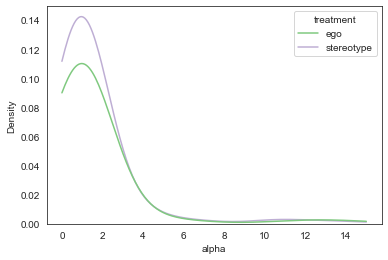

In [62]:
# estimate the distribution of alpha
# take the log of the lr
updates['log_lr'] = np.log(updates['lr'])
# plot the distribution of log_lr
sns.kdeplot(data = updates.loc[(updates['change_indicator']==1) ], x = 'lr', 
            hue='treatment', bw_adjust=.2, clip=(0, 15))
plt.xlabel('alpha')

# save the figure
plt.savefig('../figures/lr_hist.png', dpi=300, bbox_inches='tight')



In [63]:
alpha_subjects = updates[updates['change_indicator']==1].groupby(['code'])['lr', 'theta', 'belief', 'last_button'].mean()
alpha_subjects.reset_index(inplace=True)

<ipython-input-63-64155b954ff4>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  alpha_subjects = updates[updates['change_indicator']==1].groupby(['code'])['lr', 'theta', 'belief', 'last_button'].mean()


<AxesSubplot:xlabel='lr', ylabel='Count'>

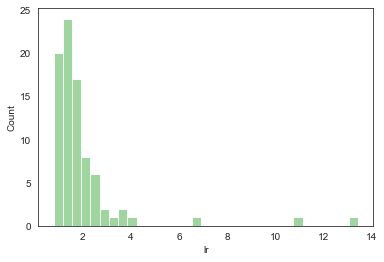

In [64]:
sns.histplot(data = alpha_subjects[alpha_subjects['lr']<15], x = 'lr')

Text(0.5, 1.0, 'Number of belief changes by initial misspecification')

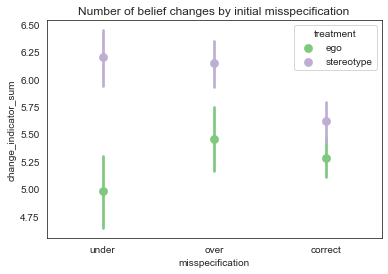

In [65]:
sns.pointplot(data=updates[(updates['change_indicator']==1) & (updates['change_indicator_sum']<=9)], y='change_indicator_sum', x='misspecification', join =False, hue='treatment')
plt.title('Number of belief changes by initial misspecification')

# Disaggregate Alpha

Text(0.5, 1.0, 'Switching Threshold by treatment')

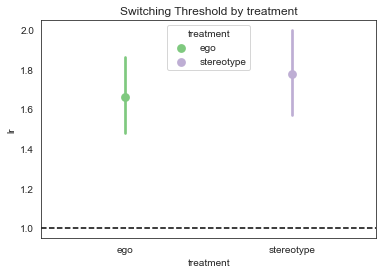

In [66]:
# plot the estimates of alpha by treatment
sns.pointplot(data=updates[(updates['change_indicator']==1) & (updates['change_indicator_sum']<=9) & (updates['lr']<50)], y='lr', x='treatment', join =False, hue='treatment')
plt.axhline(y=1, color='black', linestyle='--')
plt.title('Switching Threshold by treatment')

Text(0.5, 1.0, 'switching threshold by misspecifiaction')

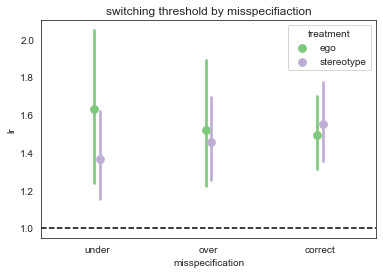

In [67]:
# plot the estimates of alpha by treatment
sns.pointplot(data=updates[(updates['change_indicator']==1) & (updates['change_indicator_sum']<=9) & (updates['lr']<15)], 
              y='lr', x='misspecification', join =False, hue='treatment', dodge=True)
plt.axhline(y=1, color='black', linestyle='--')
plt.title('switching threshold by misspecifiaction')

In [68]:
#take code of the observations in which the 'lr' is grater than 50
codes = updates.loc[(updates['lr']>=50) & (updates['round_number']>2), 'player_code'].unique()
# get the data from the observations that have a player_code in codes
abnormals = updates[updates['player_code'].isin(codes)]

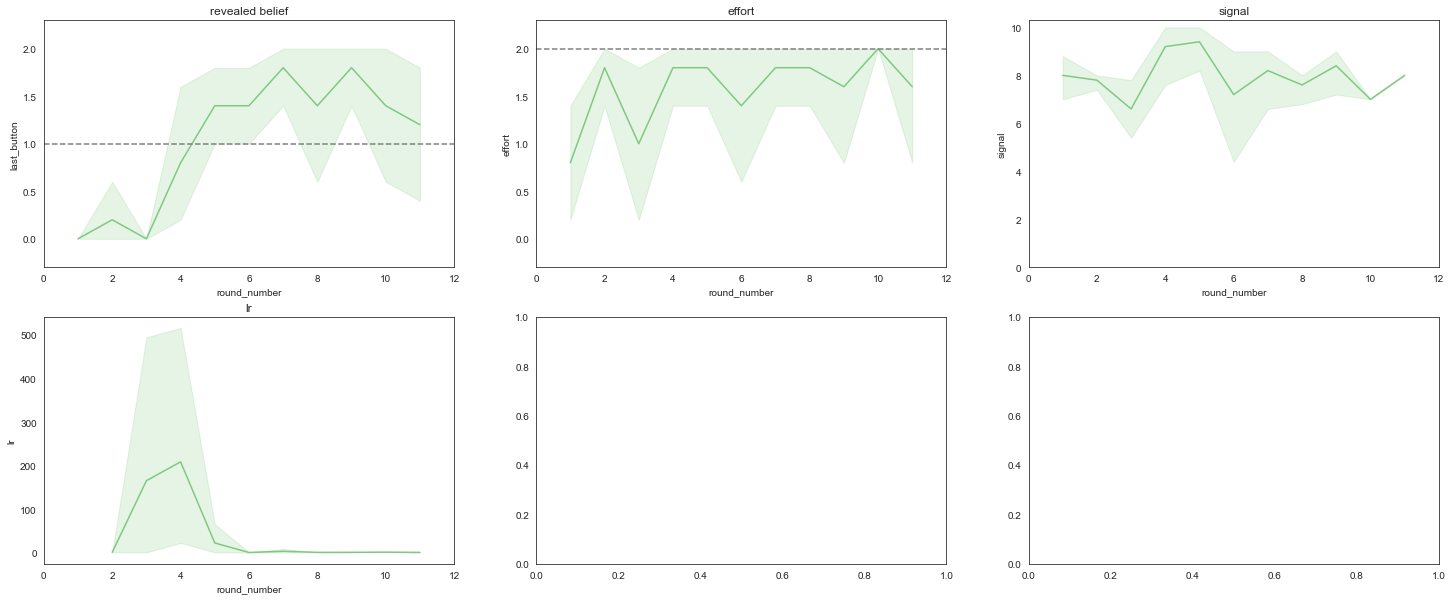

In [69]:
# The paths whith the 4 highest values of lr (above 50)

fig, axs = plt.subplots(2, 3, figsize=(25, 10))

sns.lineplot(data=abnormals, x='round_number', y='last_button', ax=axs[0,0])
axs[0,0].set_title('revealed belief')
sns.lineplot(data=abnormals, x='round_number', y='effort', ax=axs[0,1])
axs[0,1].set_title('effort')
sns.lineplot(data=abnormals, x='round_number', y='signal', ax=axs[0,2])
axs[0,2].set_title('signal')
sns.lineplot(data=abnormals, x='round_number', y='lr', ax=axs[1,0])
axs[1,0].set_title('lr')

axs[0, 0].set_ylim((-0.3, 2.3))
axs[0, 1].set_ylim((-0.3, 2.3))
axs[0, 2].set_ylim((0, 10.3))


axs[0, 0].set_xlim((0, 12))
axs[0, 1].set_xlim((0, 12))
axs[0, 2].set_xlim((0, 12))
axs[1, 0].set_xlim((0, 12))

axs[0, 0].axhline(y=abnormals['theta'].mean(), linestyle='--', color='gray')
axs[0, 1].axhline(y=abnormals['omega'].mean(), linestyle='--', color='gray')

Text(0.5, 1.0, 'Switching Threshold by topic')

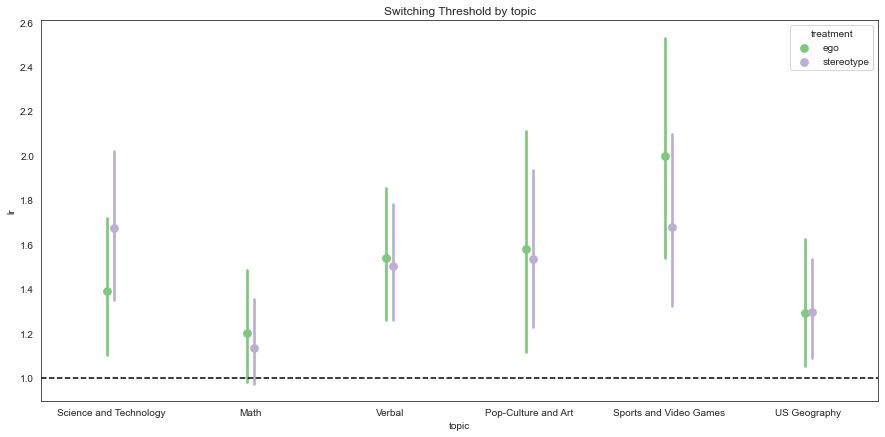

In [70]:
# plot the estimates of alpha by topic
axs, fig = plt.subplots(1,1, figsize=(15, 7))
sns.pointplot(data=updates[(updates['change_indicator']==1) & (updates['lr']<15)], 
              y='lr', x='topic', join =False, hue='treatment', dodge=True)

plt.axhline(y=1, color='black', linestyle='--')
plt.title('Switching Threshold by topic')


# Add the simulation data and reshape to merge to the experiment's data

In [71]:
# import the simulation data
sim = pd.read_csv("../Simulations/demo/data/simulation.csv")

In [72]:
updates['topic'].unique()

array(['Science and Technology', 'Math', 'Verbal', 'Pop-Culture and Art',
       'Sports and Video Games', 'US Geography'], dtype=object)

In [73]:
# split the data by initial belief and add the relevant simulations given the initial belief and the true omega and theta
initial_L = updates.loc[updates['belief']==0]
initial_M = updates.loc[updates['belief']==1]
initial_H = updates.loc[updates['belief']==2]




In [74]:
sim.columns

Index(['Unnamed: 0', 'e_lr_L', 'e_lr_M', 'e_lr_H', 'e_dog_L', 'e_dog_M',
       'e_dog_H', 'e_bay', 'e_ss', 'e_joint_bay', 'e_joint_biased',
       'theta_lr_L', 'theta_lr_M', 'theta_lr_H', 'signals_ss', 'signals_lr_L',
       'signals_lr_M', 'signals_lr_H', 'signals_dog_L', 'signals_dog_M',
       'signals_dog_H', 'signals_bay', 'theta', 'omega', 'round_number'],
      dtype='object')

In [75]:
# adjust the round numbers from the simulation to match the data (get rif od rounf 0 of the simulation, it was just the starting parameters)
sim['round_number_modif'] = sim['round_number']+1
sim['round_number_modif'] = sim['round_number_modif'].astype(int)

# split the simulations by initial beliefs
sim_L = sim[['e_lr_L', 'e_dog_L', 'e_joint_bay', 'e_joint_biased',
       'theta_lr_L', 'signals_ss', 'signals_lr_L',
       'signals_dog_L', 'signals_bay', 'theta', 'omega', 
       'round_number_modif']]
sim_M = sim[['e_lr_M', 'e_dog_M', 'e_joint_bay', 'e_joint_biased',
       'theta_lr_M', 'signals_ss', 'signals_lr_M',
       'signals_dog_M', 'signals_bay', 'theta', 'omega', 
       'round_number_modif']]
sim_H = sim[['e_lr_H', 'e_dog_H', 'e_joint_bay', 'e_joint_biased',
             'theta_lr_H', 'signals_ss', 'signals_lr_H',
             'signals_dog_H', 'signals_bay', 'theta', 'omega',
             'round_number_modif']]



In [76]:
sim_L = sim_L.rename(columns={'e_lr_L':'switcher', 
                      'e_dog_L':'dogmatic', 
                      'e_ss':'self-serving_ind', 
                      'e_bay':'bayesian_ind',
                      'e_joint_bay':'bayesian',
                      'e_joint_biased':'self-serving', 
                      'theta_lr_L':'switcher_belief',
                      'round_number_modif':'round_number',
                      'signals_lr_L':'signals_switcher',
                      'signals_dog_L':'signals_dogmatic'})

sim_M = sim_M.rename(columns={'e_lr_M':'switcher', 
                      'e_dog_M':'dogmatic', 
                      'e_ss':'self-serving_ind', 
                      'e_bay':'bayesian_ind', 
                      'e_joint_bay':'bayesian',
                      'e_joint_biased':'self-serving',
                      'theta_lr_M':'switcher_belief',
                      'round_number_modif':'round_number',
                      'signals_lr_M':'signals_switcher',
                      'signals_dog_M':'signals_dogmatic'
                      })

sim_H = sim_H.rename(columns={'e_lr_H':'switcher', 
                      'e_dog_H':'dogmatic', 
                      'e_ss':'self-serving_ind', 
                      'e_bay':'bayesian_ind', 
                      'e_joint_bay':'bayesian',
                      'e_joint_biased':'self-serving',
                      'theta_lr_H':'switcher_belief',
                      'round_number_modif':'round_number',
                      'signals_lr_H':'signals_switcher',
                      'signals_dog_H':'signals_dogmatic'})

In [77]:
sim_L['belief'] = 0
sim_M['belief'] = 1
sim_H['belief'] = 2

In [78]:
sim = pd.concat([sim_L, sim_M, sim_H])

In [79]:
# merge with the update data on the round number, the belief and the theta and omega. 
updates = updates.merge(sim, on=['round_number', 'belief', 'theta', 'omega'], how='left')

In [80]:
updates.columns

Index(['index', 'code', 'round_number', 'effort', 'fails', 'last_button',
       'score', 'topic', 'signal', 'belief', 'certainty', 'theta', 'omega',
       'treatment', 'overconfident', 'underconfident', 'correct',
       'misspecification', 'gender', 'nationality', 'misspecification_num',
       'round_misspecification', 'topic_num', 'player_code', 'effort_change',
       'effort_change_indicator', 'effort_change_sum',
       'last_button_consistent', 'last_button_correct', 'treatment_indic',
       'interaction', 'current_belief_start', 'belief_change',
       'change_indicator', 'change_indicator_sum', 'effort_next',
       'gender_nationality', 'stereotype', 'stereotype_round', 'lr', 'log_lr',
       'switcher', 'dogmatic', 'bayesian', 'self-serving', 'switcher_belief',
       'signals_ss', 'signals_switcher', 'signals_dogmatic', 'signals_bay'],
      dtype='object')

# The Simulations

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


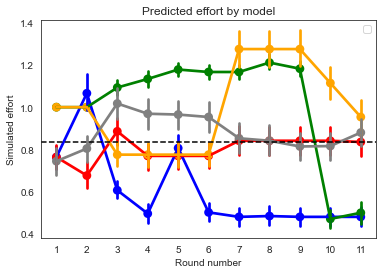

In [81]:
# plot each of the simulations as a line in the same plot
sns.set_style("white")
sns.pointplot(data=updates, x='round_number', y='switcher', label='switcher', color='blue', errorbar=None)
sns.pointplot(data=updates, x='round_number', y='dogmatic', label='dogmatic', color='red', errorbar=None)
sns.pointplot(data=updates, x='round_number', y='self-serving', label='self-serving', color='green', errorbar=None)
sns.pointplot(data=updates, x='round_number', y='bayesian', label='bayesian', color='orange', errorbar=None)
sns.pointplot(data=updates, x='round_number', y='effort', label='choices', color='gray', errorbar=None)

# add a horizontal line at  the average omega
plt.axhline(y=updates['omega'].mean(), color='black', linestyle='--')
plt.ylabel('Simulated effort')
plt.xlabel('Round number')
plt.title('Predicted effort by model')
plt.legend()


In [82]:
# add a column called misspecification to the data frame sim which is -1 if belief is lower than theta, 0 if they are the same and 1 if belief is higher than theta
sim.loc[sim['switcher_belief']<sim['theta'], 'misspecification'] = -1
sim.loc[sim['switcher_belief']==sim['theta'], 'misspecification'] = 0
sim.loc[sim['switcher_belief']>sim['theta'], 'misspecification'] = 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


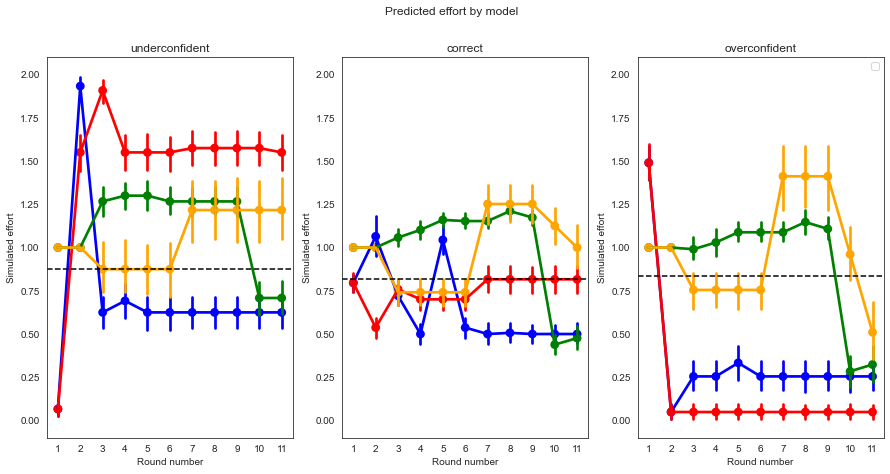

In [83]:
# plot the predictions of each model in the case of over confidence, correct and under confidence
fig, axs = plt.subplots(1, 3, figsize=(15, 7))
fig.suptitle('Predicted effort by model')
# plot each of the simulations as a line in the same plot
sns.set_style("white")
sns.pointplot(data=updates[updates['misspecification']=='under'], x='round_number', y='switcher', label='switcher', color='blue', ax=axs[0], errorbar=None)
sns.pointplot(data=updates[updates['misspecification']=='under'], x='round_number', y='dogmatic', label='dogmatic', color='red', ax=axs[0], errorbar=None)
sns.pointplot(data=updates[updates['misspecification']=='under'], x='round_number', y='self-serving', label='self-serving', color='green', ax=axs[0], errorbar=None)
sns.pointplot(data=updates[updates['misspecification']=='under'], x='round_number', y='bayesian', label='bayesian', color='orange', ax=axs[0], errorbar=None)

# add a horizontal line at  the average omega
axs[0].axhline(y=updates.loc[updates['misspecification']=='under', 'omega'].mean(), color='black', linestyle='--')
axs[0].set_ylabel('Simulated effort')
axs[0].set_xlabel('Round number')
axs[0].set_title('underconfident')
axs[0].set_ylim(-.1, 2.1)


sns.set_style("white")
sns.pointplot(data=updates[updates['misspecification']=='correct'], x='round_number', y='switcher', label='switcher', color='blue', ax=axs[1], errorbar=None)
sns.pointplot(data=updates[updates['misspecification']=='correct'], x='round_number', y='dogmatic', label='dogmatic', color='red', ax=axs[1], errorbar=None)
sns.pointplot(data=updates[updates['misspecification']=='correct'], x='round_number', y='self-serving', label='self-serving', color='green', ax=axs[1], errorbar=None)
sns.pointplot(data=updates[updates['misspecification']=='correct'], x='round_number', y='bayesian', label='bayesian', color='orange', ax=axs[1], errorbar=None)

# add a horizontal line at  the average omega
axs[1].axhline(y=updates.loc[updates['misspecification']=='correct', 'omega'].mean(), color='black', linestyle='--')
axs[1].set_ylabel('Simulated effort')
axs[1].set_xlabel('Round number')
axs[1].set_title('correct')
axs[1].set_ylim(-.1, 2.1)


sns.set_style("white")
sns.pointplot(data=updates[updates['misspecification']=='over'], x='round_number', y='switcher', label='switcher', color='blue', ax=axs[2], errorbar=None)
sns.pointplot(data=updates[updates['misspecification']=='over'], x='round_number', y='dogmatic', label='dogmatic', color='red', ax=axs[2], errorbar=None)
sns.pointplot(data=updates[updates['misspecification']=='over'], x='round_number', y='self-serving', label='self-serving', color='green', ax=axs[2], errorbar=None)
sns.pointplot(data=updates[updates['misspecification']=='over'], x='round_number', y='bayesian', label='bayesian', color='orange', ax=axs[2], errorbar=None)

# add a horizontal line at  the average omega
axs[2].axhline(y=updates.loc[updates['misspecification']=='over', 'omega'].mean(), color='black', linestyle='--')
axs[2].set_ylabel('Simulated effort')
axs[2].set_xlabel('Round number')
axs[2].set_title('overconfident')
axs[2].set_ylim(-.1, 2.1)

axs[2].legend()

# Distance to each model

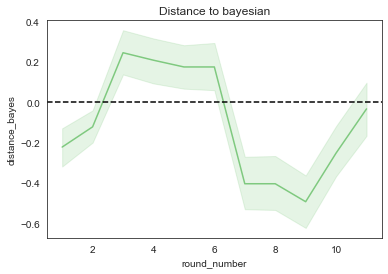

In [84]:
# compute the distance between the observed effort choices and what a bayesian agent would have done
updates['distance_bayes'] = updates['effort']- updates['bayesian']

# plot the distance over rounds for each of the treatments
sns.set_style("white")
sns.lineplot(data=updates[updates['treatment']=='ego'], x='round_number', y='distance_bayes')
#sns.lineplot(data=sim, x='round_number', y='switcher_bayesian', label='switcher', color='blue')
#sns.lineplot(data=sim, x='round_number', y='dogmatic_bayesian', label='dogmatic', color='red')
#sns.lineplot(data=sim, x='round_number', y='self-serving_bayesian', label='self-serving', color='green')
# add a horizontal line at 0 to indicate the bayesian choice
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('Distance to bayesian')

plt.savefig('../figures/distance_bayes.png', dpi=300)

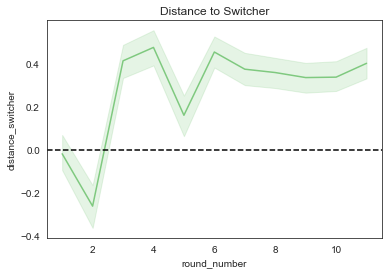

In [85]:
# compute the difference between effort and each of the simulated models
updates['distance_switcher'] = updates['effort'] - updates['switcher']
updates['distance_dogmatic'] = updates['effort'] - updates['dogmatic']
updates['distance_bayesian'] = updates['effort'] - updates['bayesian']
updates['distance_self-serving'] = updates['effort'] - updates['self-serving']

# plot the distance over rounds for each of the MODES

# plot the distance over rounds for each of the treatments and each of the models
# first plot the distance to the switcher
sns.set_style("white")
sns.lineplot(data=updates, x='round_number', y='distance_switcher')
# add a horizontal line at 0 to indicate the models choice
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distance to Switcher')
plt.savefig('../figures/distance_switcher.png')

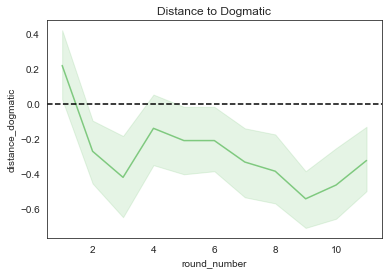

In [86]:
# the dogmatic model only applies to a subset of cases. I take only those in a different data frame called dogmatic_updates
dogmatic_updates = updates[(updates['theta']==0) & (updates['omega']==2) & (updates['belief']==1)|
                           (updates['theta']==1) & (updates['omega']==0) & (updates['belief']==0)|
                           (updates['theta']==1) & (updates['omega']==1) & (updates['belief']==0)|
                           (updates['theta']==1) & (updates['omega']==1) & (updates['belief']==2)|
                           (updates['theta']==1) & (updates['omega']==2) & (updates['belief']==2)|
                           (updates['theta']==2) & (updates['omega']==1) & (updates['belief']==1)]

# plot the distance to the dogmatic
sns.set_style("white")
sns.lineplot(data=dogmatic_updates, x='round_number', y='distance_dogmatic')
# add a horizontal line at 0 to indicate the models choice
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distance to Dogmatic')

plt.savefig('../figures/distance_dogmatic.png')

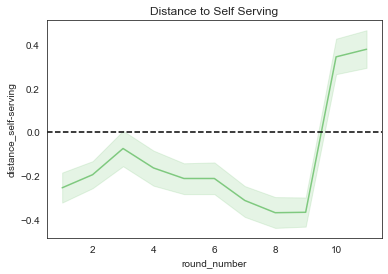

In [87]:
# plot the distance to the self-serving
sns.set_style("white")
sns.lineplot(data=updates, x='round_number', y='distance_self-serving')
# add a horizontal line at 0 to indicate the models choice
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distance to Self Serving')

plt.savefig('../figures/distance_self-serving.png')

In [88]:
# create a function that takes in theta and omega and the data and returns 8 plots
def plot(data, theta, omega):
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 15))

    table = data.loc[(data['theta']==theta) & (data['omega']==omega), :]

    sns.lineplot(data=table[table['belief']==0], x='round_number', y='effort', ax=axs[0,0])
    sns.lineplot(data=table[table['belief']==0], x='round_number', y='switcher', ax=axs[0,0], color='black')

    sns.lineplot(data=table[table['belief']==1], x='round_number', y='effort', ax=axs[0,1])
    sns.lineplot(data=table[table['belief']==1], x='round_number', y='switcher', ax=axs[0,1], color='black')

    sns.lineplot(data=table[table['belief']==2], x='round_number', y='effort', ax=axs[0,2])
    sns.lineplot(data=table[table['belief']==2], x='round_number', y='switcher', ax=axs[0,2], color='black')

    sns.lineplot(data=table[table['belief']==0], x='round_number', y='effort', ax=axs[1,0])
    sns.lineplot(data=table[table['belief']==0], x='round_number', y='dogmatic', ax=axs[1,0], color='black')

    sns.lineplot(data=table[table['belief']==1], x='round_number', y='effort', ax=axs[1,1])
    sns.lineplot(data=table[table['belief']==1], x='round_number', y='dogmatic', ax=axs[1,1], color='black')

    sns.lineplot(data=table[table['belief']==2], x='round_number', y='effort', ax=axs[1,2])
    sns.lineplot(data=table[table['belief']==2], x='round_number', y='dogmatic', ax=axs[1,2], color='black')

    sns.lineplot(data=table, x='round_number', y='effort', ax=axs[2,0])
    sns.lineplot(data=table, x='round_number', y='bayesian', ax=axs[2,0], color='black')

    sns.lineplot(data=table, x='round_number', y='effort', ax=axs[2,1])
    sns.lineplot(data=table, x='round_number', y='self-serving', ax=axs[2,1], color='black')
    
    
    axs[0, 0].set_title('switcher, belief L')
    axs[0, 1].set_title('switcher, belief M')
    axs[0, 2].set_title('switcher, belief H')

    
    axs[1, 0].set_title('dogmatic, belief L')
    axs[1, 1].set_title('dogmatic, belief M')
    axs[1, 2].set_title('dogmatic, belief H')

   
    axs[2, 0].set_title('Bayesian')
    axs[2, 1].set_title('Self Serving')
    
    axs[0, 0].set_ylim(-0.5, 2.5)
    axs[0, 1].set_ylim(-.5, 2.5)
    axs[0, 2].set_ylim(-.5, 2.5)
    axs[1, 0].set_ylim(-.5, 2.5)
    axs[1, 1].set_ylim(-.5, 2.5)
    axs[1, 2].set_ylim(-.5, 2.5)
    axs[2, 0].set_ylim(-.5, 2.5)
    axs[2, 1].set_ylim(-.5, 2.5)
    axs[2, 2].set_ylim(-.5, 2.5)

    if theta == 1:
        type = 'Mid Type'
    if theta ==0:
        type = 'Low Type'
    if theta ==2:
        type = 'High Type'

    axs[2,0].set_xlabel('round')
    axs[2,1].set_xlabel('round')
    axs[2,2].set_xlabel('round')

    axs[0, 0].set_ylabel('effort choice')
    axs[1, 0].set_ylabel('effort choice')
    axs[2, 0].set_ylabel('effort choice')

    axs[0, 0].set_yticks([0, 1, 2])
    axs[1, 0].set_yticks([0, 1, 2])
    axs[2, 0].set_yticks([0, 1, 2])

    axs[0, 1].set_yticks([0, 1, 2])
    axs[1, 1].set_yticks([0, 1, 2])
    axs[2, 1].set_yticks([0, 1, 2])

    axs[0, 2].set_yticks([0, 1, 2])
    axs[1, 2].set_yticks([0, 1, 2])
    axs[2, 2].set_yticks([0, 1, 2])
    
    fig.suptitle(type + ', rate = '+str(omega))

# Try to Classify subjects based on their behavior

## Norm 2 distance

In [89]:
# compute the difference between effort and each of the simulated models
updates['distance_switcher_2'] = (updates['effort'] - updates['switcher'])**2
updates['distance_dogmatic_2'] = (updates['effort'] - updates['dogmatic'])**2
updates['distance_bayesian_2'] = (updates['effort'] - updates['bayesian'])**2
updates['distance_self-serving_2'] = (updates['effort'] - updates['self-serving'])**2

# create a new data set with the sum the computed distences by player_code for each of the models
distances = pd.DataFrame()
distances['distance_switcher_2sum'] = updates.groupby('code')['distance_switcher_2'].sum()
distances['distance_dogmatic_2sum'] = updates.groupby('code')['distance_dogmatic_2'].sum()
distances['distance_bayesian_2sum'] = updates.groupby('code')['distance_bayesian_2'].sum()
distances['distance_self-serving_2sum'] = updates.groupby('code')['distance_self-serving_2'].sum()

# for each player_code, return the model that has the smallest sum
distances['best_model'] = np.argmin(distances[['distance_switcher_2sum', 'distance_dogmatic_2sum', 'distance_bayesian_2sum', 'distance_self-serving_2sum']].values, axis=1)

# merge with the updates data 
updates = updates.merge(distances, on='code', how='left')

In [90]:
# make a data frame with the average distances by subject.
subject_models=updates.groupby(['code', 'treatment']).mean('best_model')
subject_models.reset_index(inplace=True)


In [91]:
# for each subject, take the average distance of the best fittig model and set it in a new column
subject_models.loc[subject_models['best_model']==0, 'min_distance'] = subject_models.loc[subject_models['best_model']==0, 'distance_switcher_2sum']
subject_models.loc[subject_models['best_model']==1, 'min_distance'] = subject_models.loc[subject_models['best_model']==1, 'distance_dogmatic_2sum']
subject_models.loc[subject_models['best_model']==2, 'min_distance'] = subject_models.loc[subject_models['best_model']==2, 'distance_bayesian_2sum']
subject_models.loc[subject_models['best_model']==3, 'min_distance'] = subject_models.loc[subject_models['best_model']==3,'distance_self-serving_2sum']


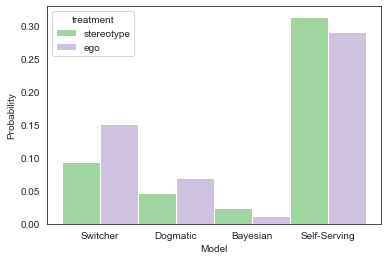

In [92]:
#count the number of subjects for which each of the models id the best fitting among all 4 of them
# make two plots side by side for each treatment

sns.histplot(data=subject_models, x='best_model', 
             discrete=True, hue='treatment', multiple='dodge', stat='probability')
plt.xticks([0, 1, 2, 3], ['Switcher', 'Dogmatic', 'Bayesian', 'Self-Serving'])
plt.ylabel('Probability')
plt.xlabel('Model')





plt.savefig('../figures/model_fit_histogram.png')

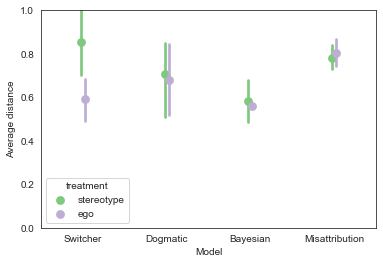

In [93]:
# plot the average minimal distance for each of the models
subject_models['min_distance_avg'] = subject_models['min_distance']/66
sns.pointplot(data=subject_models, x='best_model', y='min_distance_avg', join =False, hue='treatment', dodge=True)
plt.xticks([0, 1, 2, 3], ['Switcher', 'Dogmatic', 'Bayesian', 'Misattribution'])
plt.ylabel('Average distance')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.savefig('../figures/model_min_distance.png')

## Norm 1 distance

In [94]:
# compute the difference between effort and each of the simulated models
updates['distance_switcher_abs'] = np.abs(updates['effort'] - updates['switcher'])
updates['distance_dogmatic_abs'] = np.abs(updates['effort'] - updates['dogmatic'])
updates['distance_bayesian_abs'] = np.abs(updates['effort'] - updates['bayesian'])
updates['distance_self-serving_abs'] = np.abs(updates['effort'] - updates['self-serving'])

# create a new data set with the sum the computed distences by player_code for each of the models
distances = pd.DataFrame()
distances['distance_switcher_sum'] = updates.groupby('code')['distance_switcher_abs'].sum()
distances['distance_dogmatic_sum'] = updates.groupby('code')['distance_dogmatic_abs'].sum()
distances['distance_bayesian_sum'] = updates.groupby('code')['distance_bayesian_abs'].sum()
distances['distance_self-serving_sum'] = updates.groupby('code')['distance_self-serving_abs'].sum()

# for each player_code, return the model that has the smallest sum
distances['best_model_abs'] = np.argmin(distances[['distance_switcher_sum', 'distance_dogmatic_sum', 'distance_bayesian_sum', 'distance_self-serving_sum']].values, axis=1)

# merge with the updates data 
updates = updates.merge(distances, on='code', how='left')

In [95]:
# make a data frame with the average distances by subject.
subject_models=updates.groupby(['code', 'treatment']).mean('best_model')
subject_models.reset_index(inplace=True)


In [96]:
# for each subject, take the average distance of the best fittig model and set it in a new column
subject_models.loc[subject_models['best_model']==0, 'min_distance'] = subject_models.loc[subject_models['best_model']==0, 'distance_switcher_sum']
subject_models.loc[subject_models['best_model']==1, 'min_distance'] = subject_models.loc[subject_models['best_model']==1, 'distance_dogmatic_sum']
subject_models.loc[subject_models['best_model']==2, 'min_distance'] = subject_models.loc[subject_models['best_model']==2, 'distance_bayesian_sum']
subject_models.loc[subject_models['best_model']==3, 'min_distance'] = subject_models.loc[subject_models['best_model']==3,'distance_self-serving_sum']


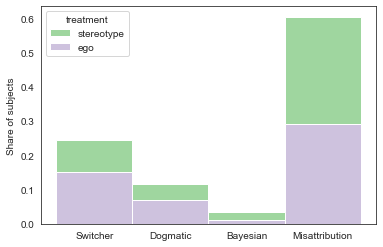

In [97]:
#count the number of subjects for which each of the models id the best fitting among all 4 of them
sns.histplot(data=subject_models, x='best_model', discrete=True, hue='treatment', multiple='stack', stat='probability')
plt.xticks([0, 1, 2, 3], ['Switcher', 'Dogmatic', 'Bayesian', 'Misattribution'])
plt.ylabel('Share of subjects')
plt.xlabel('')
plt.savefig('../figures/model_fit_histogram.png')

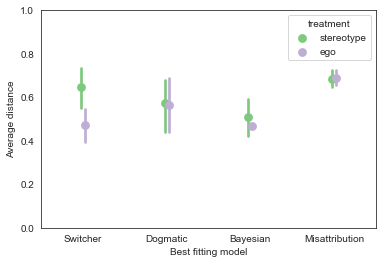

In [98]:
# plot the average minimal distance for each of the models
subject_models['min_distance_avg'] = subject_models['min_distance']/66
sns.pointplot(data=subject_models, x='best_model', y='min_distance_avg', join =False, hue='treatment', dodge=True)
plt.xticks([0, 1, 2, 3], ['Switcher', 'Dogmatic', 'Bayesian', 'Misattribution'])
plt.ylabel('Average distance')
plt.xlabel('Best fitting model')
plt.ylim(0, 1)
plt.savefig('../figures/model_min_distance.png')


# Differences across topics

<AxesSubplot:xlabel='misspecification', ylabel='Probability'>

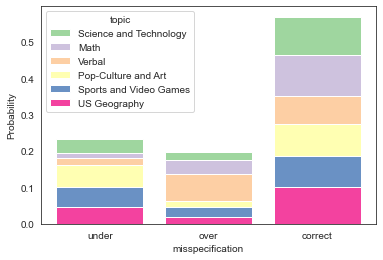

In [99]:
sns.histplot(data=updates, x='misspecification', hue='topic', multiple='stack', stat='probability', shrink=.8, discrete=True)

<AxesSubplot:xlabel='misspecification', ylabel='certainty'>

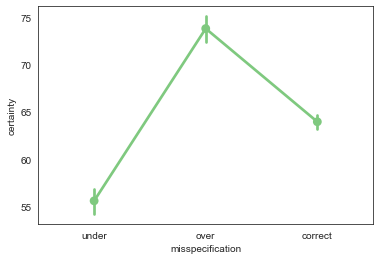

In [100]:
sns.pointplot(data=updates, x='misspecification', y='certainty')

# Consistency in matrix choices

<ipython-input-101-bbe4462fe18b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round_1.loc[:, 'consistent_first']=round_1['belief']==round_1['last_button']
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


Ttest_1sampResult(statistic=9.429879408244583, pvalue=1.3955660084070433e-19)

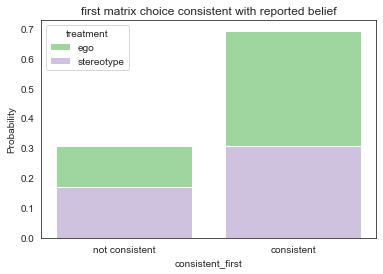

In [101]:
# check if the fist matrix that they choose to see matches the belief they reported
# create a data frame with only round 1
round_1 = updates.loc[updates['round_number']==1, :]

# create a column that indicates whether the last_button in round 1 matches the reported belief
round_1.loc[:, 'consistent_first']=round_1['belief']==round_1['last_button']



sns.histplot(data=round_1, x='consistent_first', hue='treatment', multiple='stack', 
             discrete=True, stat='probability', shrink=.8)
plt.title('first matrix choice consistent with reported belief')
plt.xticks([0, 1], ['not consistent', 'consistent'])

plt.savefig('../figures/consistency_first.png')

np.mean(round_1['consistent_first'])

stats.ttest_1samp(round_1['consistent_first'], 0.5)

# Choices relative to the optimal

In [102]:
updates.loc[updates['effort']==updates['omega'], 'correct_e'] = 1
updates.loc[updates['effort']!=updates['omega'], 'correct_e'] = 0

(0.0, 1.0)

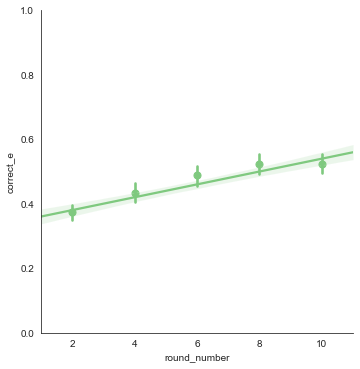

In [103]:
sns.lmplot(data=updates, x='round_number', y='correct_e', x_bins=5)
plt.ylim(0,1)

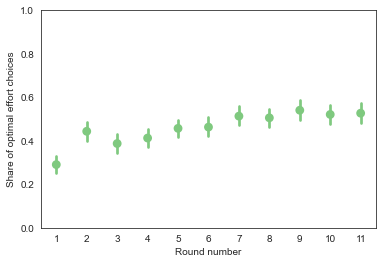

In [104]:
# plot the shatre of correct effort choices by round
sns.pointplot(data=updates, x='round_number', y='correct_e', 
              join =False, dodge=True)

plt.xlabel('Round number')
plt.ylabel('Share of optimal effort choices')
plt.ylim(0, 1)



plt.savefig('../figures/effort_learning.png')

In [105]:
updates.loc[updates['round_number']==11, 'correct_e'].mean()

0.5271317829457365

In [106]:
updates.loc[updates['round_number']==1, 'correct_e'].mean()

0.29069767441860467

In [107]:
stats.ttest_ind(updates.loc[updates['round_number']==11, 'correct_e'], updates.loc[updates['round_number']==1, 'correct_e'])

Ttest_indResult(statistic=7.950424864948993, pvalue=4.861187317134778e-15)

(0.0, 1.0)

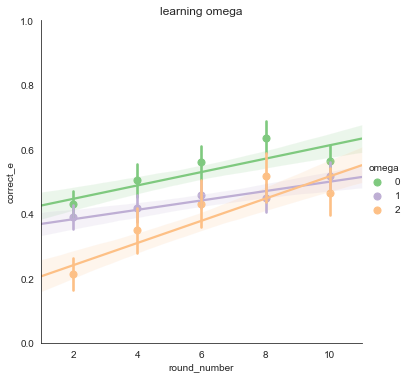

In [108]:
# plot the shatre of correct effort choices by round for each of the values of omega
sns.lmplot(data=updates, x='round_number', y='correct_e', hue='omega', x_bins=5)
plt.title('learning omega')
plt.ylim(0,1)

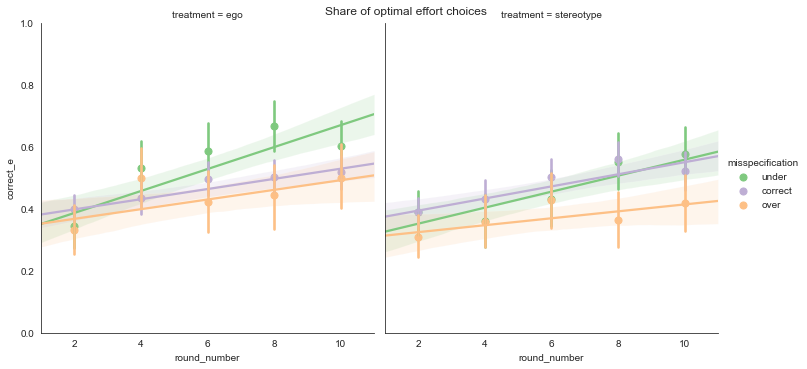

In [109]:
# plot the shatre of correct effort choices by round for each of the initial misspecifications
sns.lmplot(data=updates, x='round_number', y='correct_e', hue='misspecification', x_bins=5, hue_order=['under', 'correct', 'over'], col='treatment')
plt.suptitle('Share of optimal effort choices')
plt.ylim(0,1)
plt.savefig('../figures/effort_learning_misspecif_treatment.png')

# Reaction to news

In [110]:
# plot the effort by signal in the previous round
# make a column called signal_prev that is the signal in the previous round
updates['signal_prev'] = updates.groupby('code')['signal'].shift(1)
# make a column called effort_change that is the change in effort from the previous round
# make a column called effort_prev with the effor from the previous round
updates['effort_prev'] = updates.groupby('code')['effort'].shift(1)
updates['effort_change'] = updates['effort'] - updates['effort_prev']

# good news is when the previous signal is higher than the average from before
# make a column in updates that is the average signal in all the previous rounds
updates['signal_avg'] = updates.groupby('code')['signal'].transform(lambda x: x.expanding().mean())
# make a column that the diference between the previous signal and the average
updates['news_diff'] = updates['signal_prev'] - updates['signal_avg']






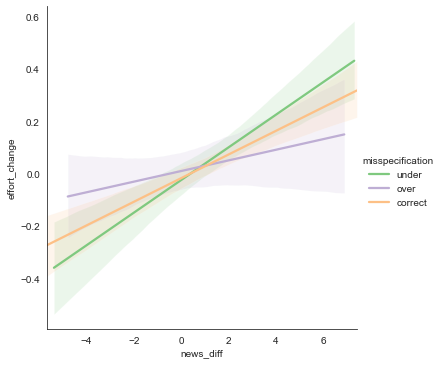

In [111]:
# plot the effort by signal in the previous round
sns.lmplot(data=updates[updates['round_number']>1], x='news_diff', y='effort_change', hue='misspecification', scatter=False)

In [112]:
# run a regression to check if the slopes are different
# create a column that is an indicator for the misspecification_over
updates['misspecification_over'] = 0
updates.loc[updates['misspecification']=='over', 'misspecification_over'] = 1
# create a colun that is an indicator for the misspecification_under
updates['misspecification_under'] = 0
updates.loc[updates['misspecification']=='under', 'misspecification_under'] = 1
# create a column that is an indicator for the misspecification_correct
updates['misspecification_correct'] = 0
updates.loc[updates['misspecification']=='correct', 'misspecification_correct'] = 1
# create columns for the interaction of each misspecification with the news_diff
updates['misspecification_over_news_diff'] = updates['misspecification_over']*updates['news_diff']
updates['misspecification_under_news_diff'] = updates['misspecification_under']*updates['news_diff']
updates['misspecification_correct_news_diff'] = updates['misspecification_correct']*updates['news_diff']

# run a regression with the interaction terms
results = smf.ols('effort_change ~ misspecification_over + misspecification_under + misspecification_correct + misspecification_over_news_diff + misspecification_under_news_diff + misspecification_correct_news_diff', data=updates[updates['round_number']>1]).fit()
print(results.summary())

# test if the estimated coefficients are different from eachother
 
hypotheses = 'misspecification_over_news_diff - misspecification_under_news_diff= 0, misspecification_under_news_diff - misspecification_correct_news_diff = 0, misspecification_correct_news_diff - misspecification_over_news_diff = 0'
t_test_slopes = results.t_test(hypotheses)

print(t_test_slopes.summary())


                            OLS Regression Results                            
Dep. Variable:          effort_change   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     12.82
Date:                Thu, 19 Oct 2023   Prob (F-statistic):           2.06e-12
Time:                        20:11:27   Log-Likelihood:                -7266.4
No. Observations:                5160   AIC:                         1.454e+04
Df Residuals:                    5154   BIC:                         1.458e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

The underconfident subjects react more to more surprising news in effort. This means that they are attributing more of the news to the exogenous parameter than their own ability and thus. 

Instead, the overconfident subjects react the least, which might mean that they attribute more of the news to their own types. I will check separately for good and bad news to see if the updates are different there

(-1.0, 1.0)

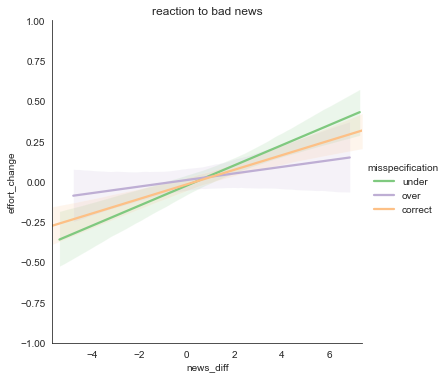

In [113]:
# plot the effort change by signal differential for good news and bad news separately
sns.lmplot(data=updates[(updates['round_number']>1)], x='news_diff', y='effort_change', hue='misspecification', scatter=False)
plt.title('reaction to bad news')
plt.ylim(-1, 1)

(-2.0, 2.0)

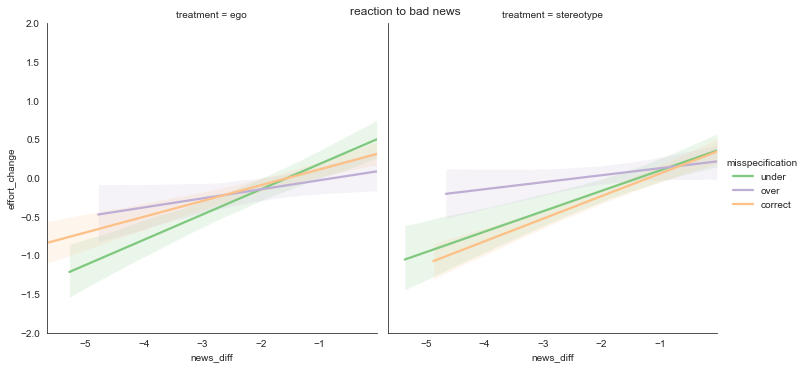

In [114]:
# plot the reaction to bad news by treatment and misspecification
sns.lmplot(data=updates[(updates['round_number']>1)& (updates['news_diff']<0)], x='news_diff', y='effort_change', hue='misspecification', scatter=False, col='treatment')
plt.suptitle('reaction to bad news')
plt.ylim(-2, 2)

(-2.0, 2.0)

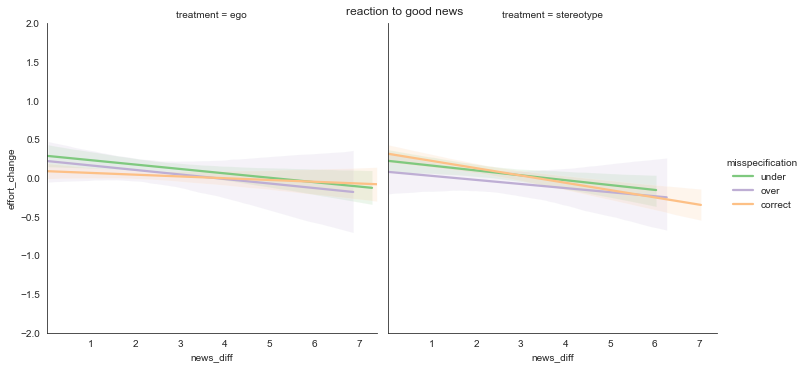

In [115]:
# plot the reaction to goof news by treatment and misspecification
sns.lmplot(data=updates[(updates['round_number']>1)& (updates['news_diff']>0)], x='news_diff', y='effort_change', hue='misspecification', scatter=False, col='treatment')
plt.suptitle('reaction to good news')
plt.ylim(-2, 2)

The slope is positive for bad news, meaning, they react in effort to bad news 

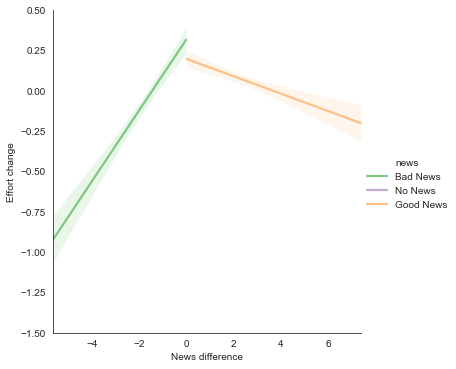

In [116]:
# create a column that takes the value 'Bad News' if news_diff is negative and 'Good News' if news_diff is positive
updates['news'] = 'Bad News'
updates.loc[updates['news_diff']>0, 'news'] = 'Good News'
updates.loc[updates['news_diff']==0, 'news'] = 'No News'

# plot a regression of effort change on news_diff for each of the news
sns.lmplot(data=updates[updates['round_number']>1], x='news_diff', y='effort_change', 
           hue='news', scatter=False, hue_order=['Bad News', 'No News', 'Good News'])

plt.ylim(-1.5, .5) 
plt.xlabel('News difference')
plt.ylabel('Effort change')

# save the plot
plt.savefig('../figures/effort_change_news.png')


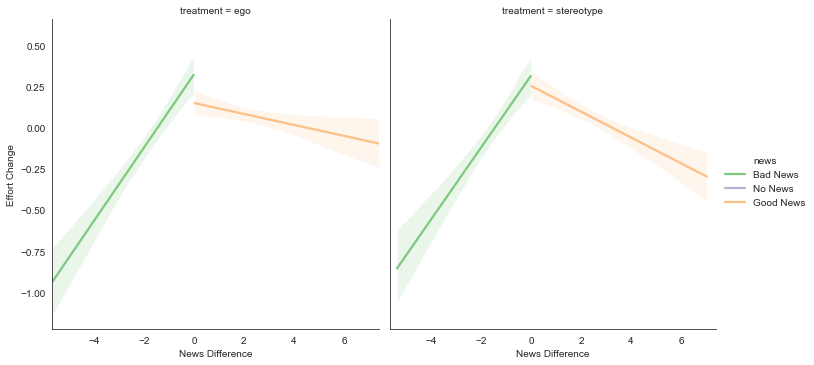

In [117]:
# do it for each treatment
lm = sns.lmplot(data=updates[(updates['round_number']>1)], 
           x='news_diff', y='effort_change', 
           hue='news', scatter=False, hue_order=['Bad News', 'No News', 'Good News'], col='treatment')

# rename the axes in each facet
lm.set_axis_labels("News Difference", "Effort Change")

# save
plt.savefig('../figures/effort_change_news_treatment.png')


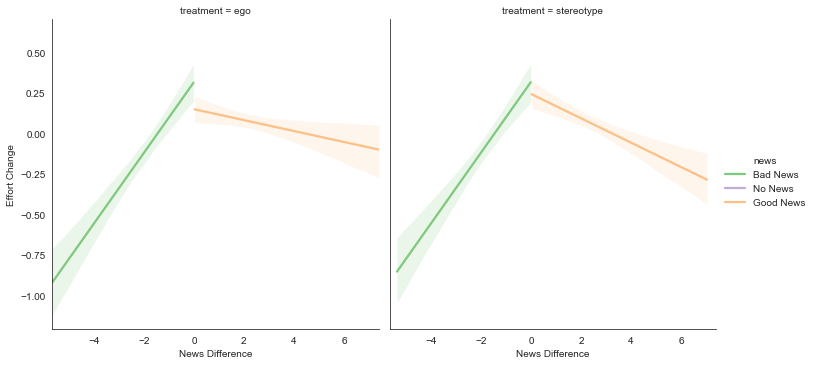

In [118]:
# remove those who go from underconfident to overconfident
# get the player codes for whom, in round 11 misspecification is not under or round_misspecification is not over
codes = updates.loc[(updates['round_number']==11) & (updates['misspecification']!='under') & (updates['round_misspecification']!='over'), 'code']
# codes that go from correct to under
codes2 = updates.loc[(updates['round_number']==11) & (updates['misspecification']=='correct') & (updates['round_misspecification']=='under'), 'code']

lm = sns.lmplot(data=updates[(updates['round_number']>1) & (updates['code'].isin(codes)) ], 
           x='news_diff', y='effort_change', 
           hue='news', scatter=False, hue_order=['Bad News', 'No News', 'Good News'], col='treatment')

# rename the axes in each facet
lm.set_axis_labels("News Difference", "Effort Change")

# save
plt.savefig('../figures/effort_change_news_treatment_restricted.png')

In [119]:
updates.columns

Index(['index', 'code', 'round_number', 'effort', 'fails', 'last_button',
       'score', 'topic', 'signal', 'belief', 'certainty', 'theta', 'omega',
       'treatment', 'overconfident', 'underconfident', 'correct',
       'misspecification', 'gender', 'nationality', 'misspecification_num',
       'round_misspecification', 'topic_num', 'player_code', 'effort_change',
       'effort_change_indicator', 'effort_change_sum',
       'last_button_consistent', 'last_button_correct', 'treatment_indic',
       'interaction', 'current_belief_start', 'belief_change',
       'change_indicator', 'change_indicator_sum', 'effort_next',
       'gender_nationality', 'stereotype', 'stereotype_round', 'lr', 'log_lr',
       'switcher', 'dogmatic', 'bayesian', 'self-serving', 'switcher_belief',
       'signals_ss', 'signals_switcher', 'signals_dogmatic', 'signals_bay',
       'distance_bayes', 'distance_switcher', 'distance_dogmatic',
       'distance_bayesian', 'distance_self-serving', 'distance_switcher

In [120]:

# add a column with the model names ['Switcher', 'Dogmatic', 'Bayesian', 'Self-Serving']
updates['best_model'] = 'Switcher'
updates.loc[updates['best_model_abs']==1, 'best_model'] = 'Dogmatic'
updates.loc[updates['best_model_abs']==2, 'best_model'] = 'Bayesian'
updates.loc[updates['best_model_abs']==3, 'best_model'] = 'Self-Serving'

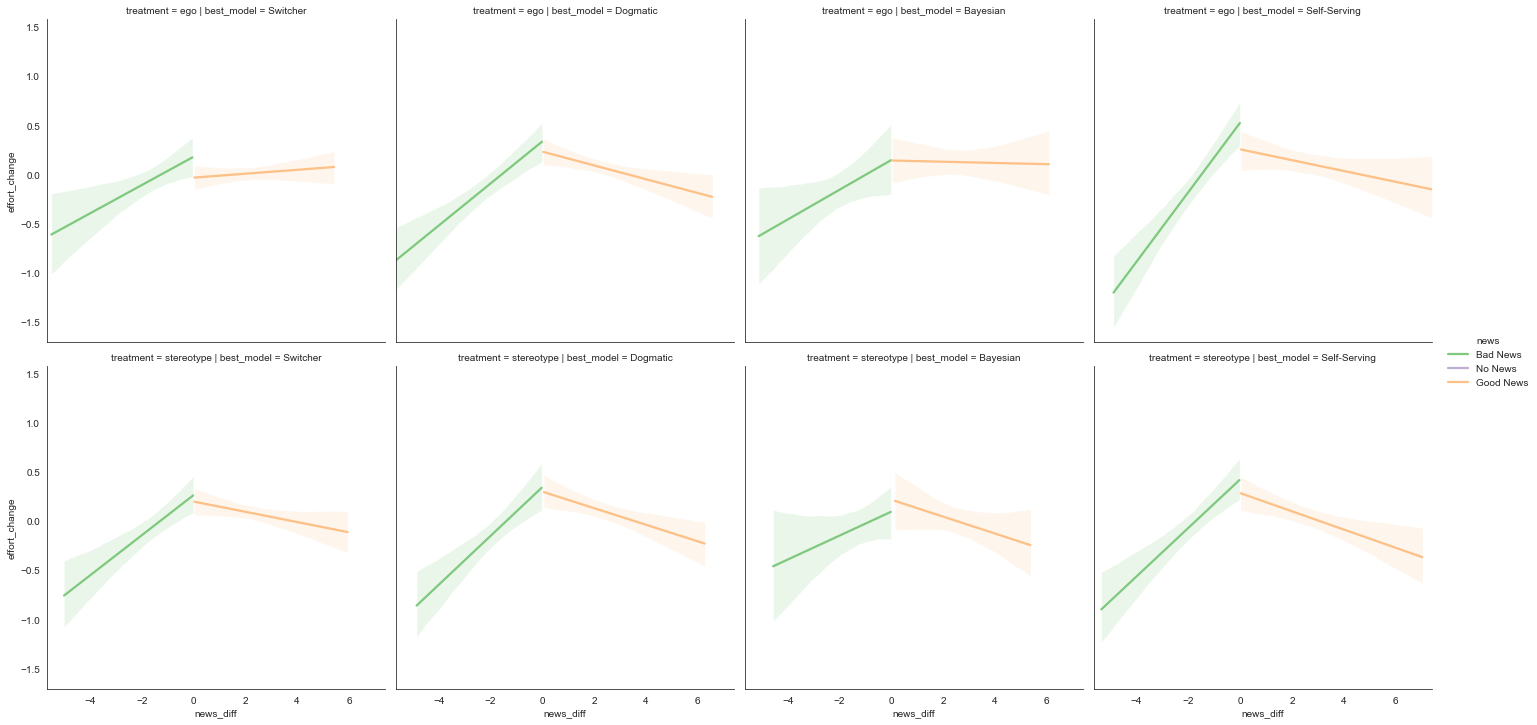

In [121]:
# Do the same plot by model fit
sns.lmplot(data=updates[(updates['round_number']>1)], 
           x='news_diff', y='effort_change', 
           hue='news', scatter=False, hue_order=['Bad News', 'No News', 'Good News'], col='best_model', col_order=['Switcher', 'Dogmatic', 'Bayesian', 'Self-Serving'], row='treatment')

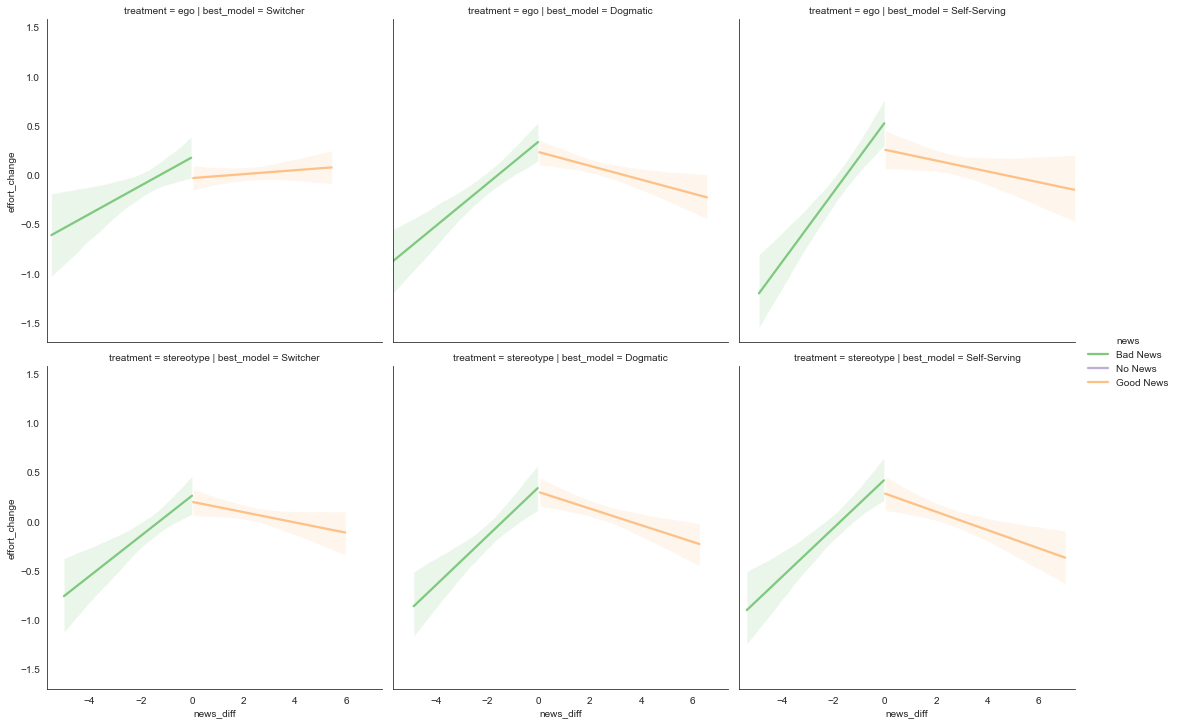

In [122]:
# plot the effort change by signal differential for all except bayesian bets model
sns.lmplot(data=updates[(updates['round_number']>1)& (updates['best_model']!='Bayesian')], x='news_diff', y='effort_change', 
           hue='news', scatter=False, hue_order=['Bad News', 'No News', 'Good News'], col='best_model', col_order=['Switcher', 'Dogmatic', 'Self-Serving'], row='treatment')

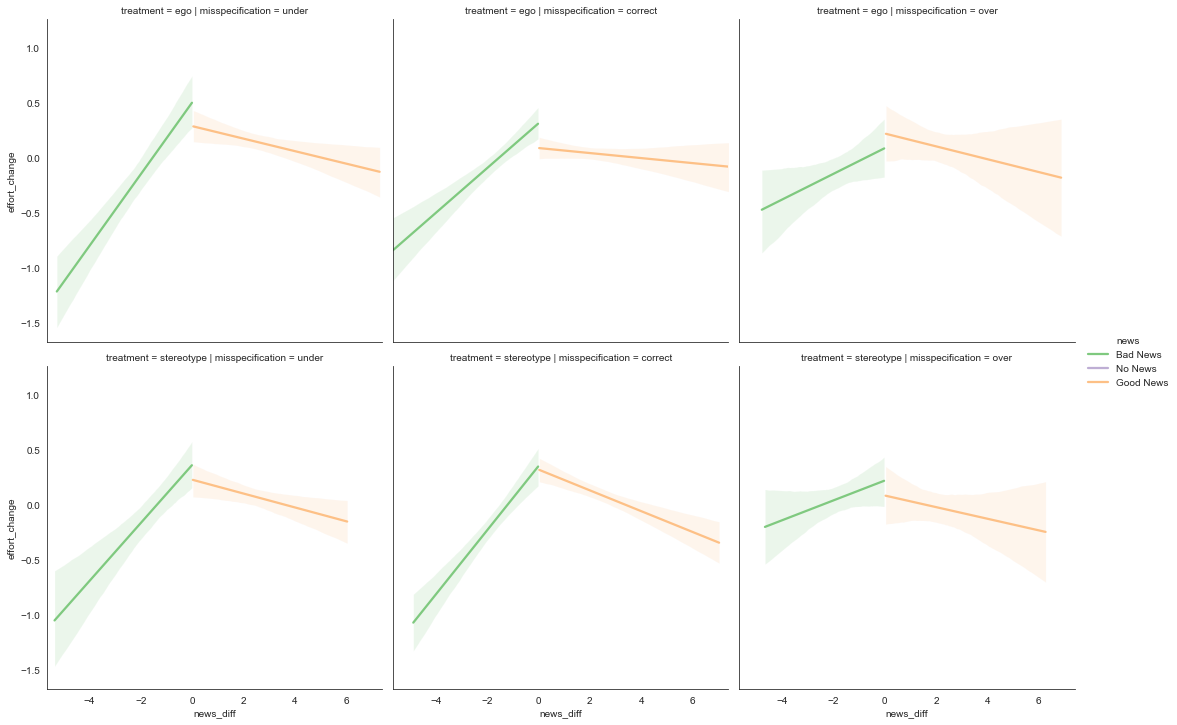

In [123]:
# do it for each misspecification
sns.lmplot(data=updates[(updates['round_number']>1)], 
           x='news_diff', y='effort_change', 
           hue='news', scatter=False, hue_order=['Bad News', 'No News', 'Good News'], 
           col='misspecification', row='treatment', col_order=['under', 'correct', 'over'])




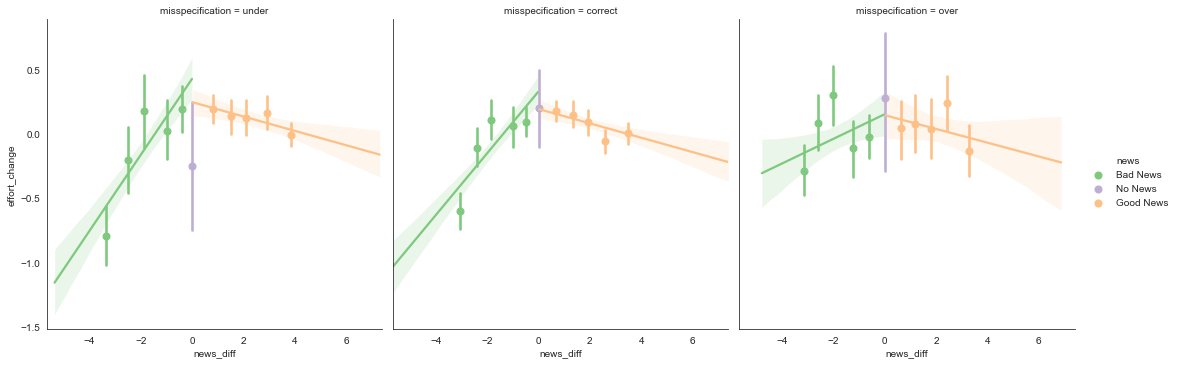

In [124]:
# do it for each misspecification
sns.lmplot(data=updates[(updates['round_number']>1)], 
           x='news_diff', y='effort_change', 
           hue='news', x_bins=5, hue_order=['Bad News', 'No News', 'Good News'], col='misspecification', col_order=['under', 'correct', 'over'])

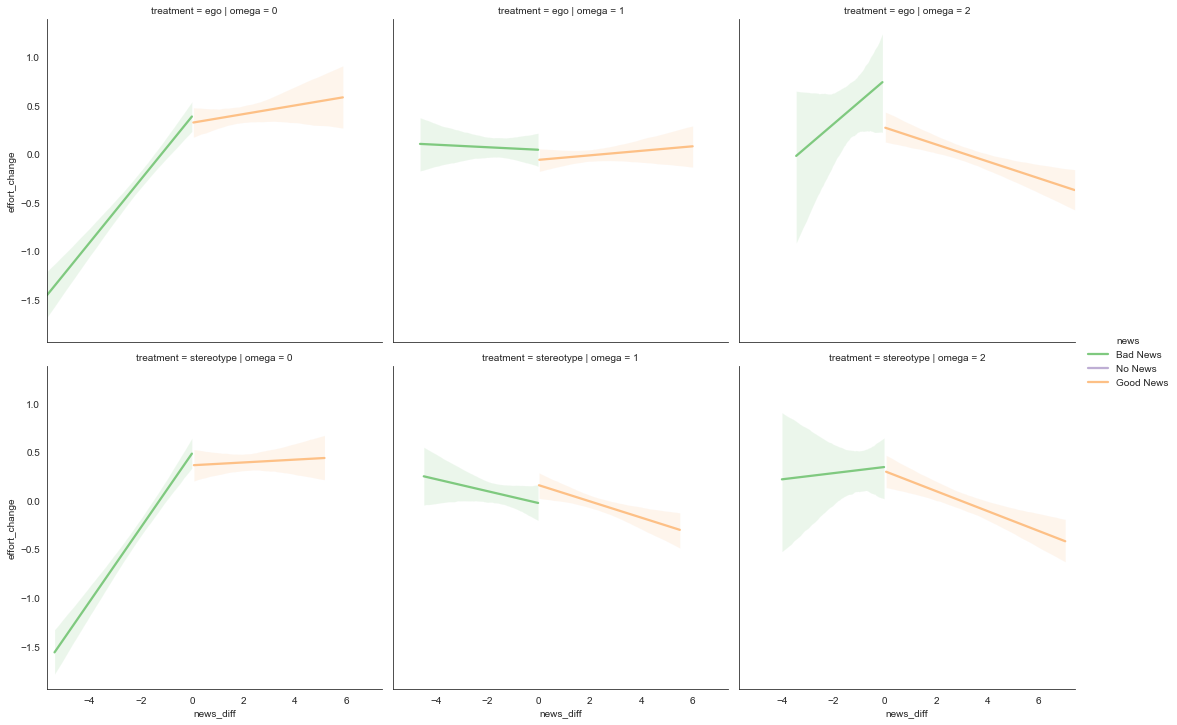

In [125]:
# do it for each omega
sns.lmplot(data=updates[(updates['round_number']>1) ], 
           x='news_diff', y='effort_change', 
           hue='news', scatter=False, hue_order=['Bad News', 'No News', 'Good News'], col='omega', row='treatment')


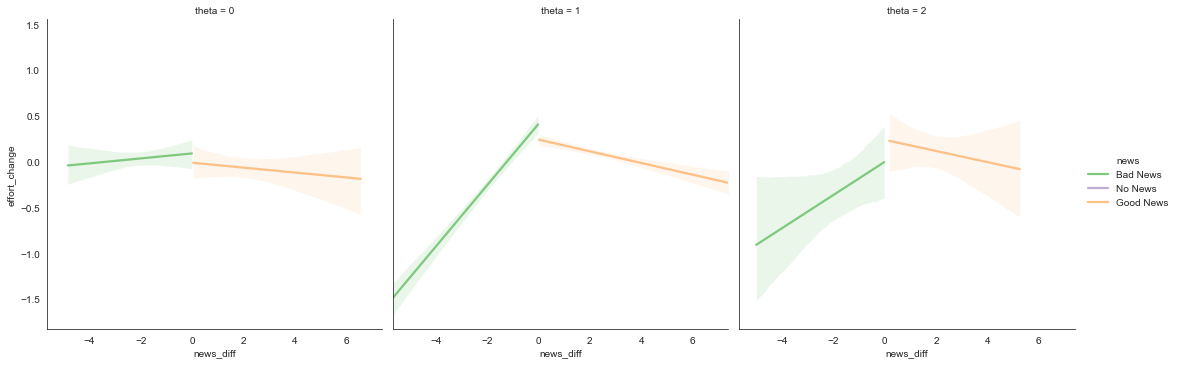

In [126]:
# do it for each theta
sns.lmplot(data=updates[(updates['round_number']>1)], 
           x='news_diff', y='effort_change', 
           hue='news', scatter=False, hue_order=['Bad News', 'No News', 'Good News'], col='theta')


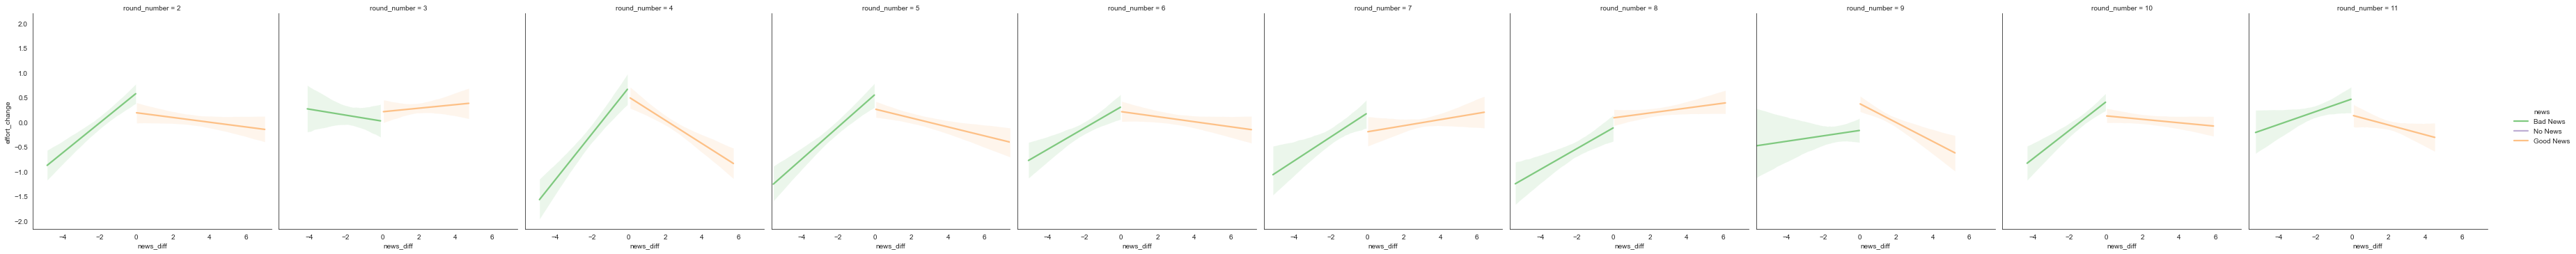

In [127]:
# do it for each theta
sns.lmplot(data=updates[(updates['round_number']>1)], 
           x='news_diff', y='effort_change', 
           hue='news', scatter=False, hue_order=['Bad News', 'No News', 'Good News'], col='round_number')

# confirmtion Bias

In [128]:
# check if the news align with the misspecification
updates.loc[(updates['misspecification']=='over') & (updates['news_diff']>0), 'confirming_news'] = 'confirming'
updates.loc[(updates['misspecification']=='over') & (updates['news_diff']<0), 'confirming_news'] = 'disconfirming'
updates.loc[(updates['misspecification']=='over') & (updates['news_diff']==0), 'confirming_news'] = 'neutral'

updates.loc[(updates['misspecification']=='under') & (updates['news_diff']<0), 'confirming_news'] = 'confirming'
updates.loc[(updates['misspecification']=='under') & (updates['news_diff']>0), 'confirming_news'] = 'disconfirming'
updates.loc[(updates['misspecification']=='under') & (updates['news_diff']==0), 'confirming_news'] = 'neutral'

updates.loc[(updates['misspecification']=='correct') & (updates['news_diff']>0), 'confirming_news'] = 'confirming'
updates.loc[(updates['misspecification']=='correct') & (updates['news_diff']<0), 'confirming_news'] = 'disconfirming'
updates.loc[(updates['misspecification']=='correct') & (updates['news_diff']==0), 'confirming_news'] = 'neutral'


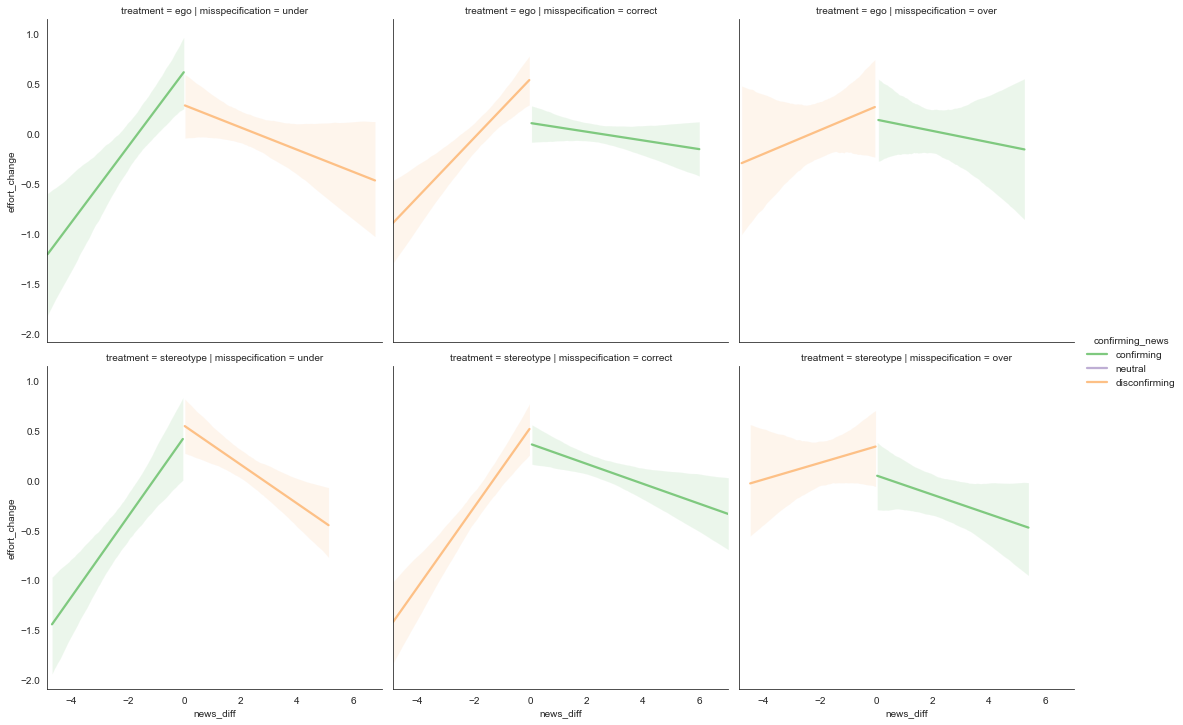

In [129]:
# do it for each misspecification
sns.lmplot(data=updates[(updates['round_number']<5) ], 
           x='news_diff', y='effort_change', 
           hue='confirming_news', x_bins=6, scatter=False, col='misspecification', col_order=['under', 'correct', 'over'],
           hue_order=['confirming', 'neutral', 'disconfirming'], row='treatment')

In [130]:
# add a column that indicates if the signal is 5, more than 5 or less than 5
updates['signal_range'] = 'less than 5'
updates.loc[updates['signal']>5, 'signal_range'] = 'more than 5'
updates.loc[updates['signal']==5, 'signal_range'] = '5'


(-2.0, 2.0)

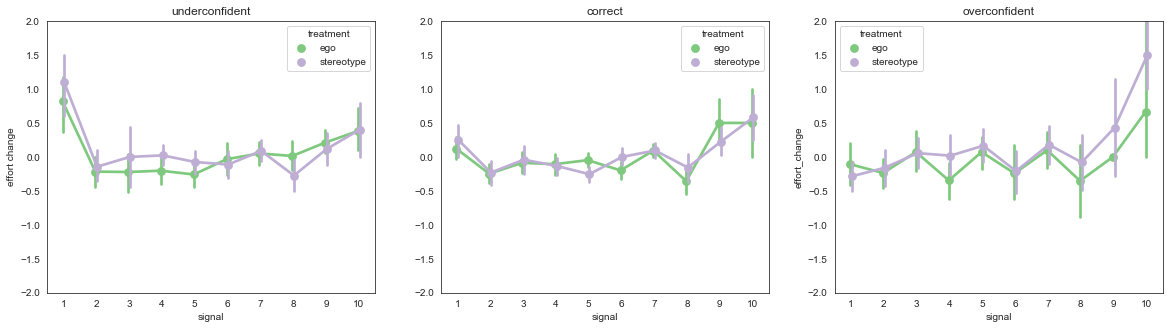

In [131]:
# do it for each misspecification
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
sns.pointplot(data=updates[(updates['round_number']>1) & (updates['signal']>0) & (updates['misspecification']=='under')], 
           x='signal', y='effort_change', hue='treatment', ax=axs[0], dodge=True)
sns.pointplot(data=updates[(updates['round_number']>1) & (updates['signal']>0) & (updates['misspecification']=='correct')], 
           x='signal', y='effort_change', hue='treatment', ax=axs[1], dodge=True)
sns.pointplot(data=updates[(updates['round_number']>1) & (updates['signal']>0) & (updates['misspecification']=='over')], 
           x='signal', y='effort_change', hue='treatment', ax=axs[2], dodge=True)

axs[0].set_title('underconfident')
axs[1].set_title('correct')
axs[2].set_title('overconfident')
axs[0].set_ylabel('effort change')
axs[1].set_ylabel('')
axs[0].set_xlabel('signal')
axs[1].set_xlabel('signal')
axs[0].set_ylim(-2, 2)
axs[1].set_ylim(-2, 2)
axs[2].set_ylim(-2, 2)

# News in simulations

In [132]:
# for each of the columns signals_switcher, signals_dogmatic, signals_bay, signals_ss, 
# create a column with the average signal in the previous rounds for that player_code
updates['signals_switcher_avg'] = updates.groupby('code')['signals_switcher'].transform(lambda x: x.expanding().mean())
updates['signals_dogmatic_avg'] = updates.groupby('code')['signals_dogmatic'].transform(lambda x: x.expanding().mean())
updates['signals_bay_avg'] = updates.groupby('code')['signals_bay'].transform(lambda x: x.expanding().mean())
updates['signals_ss_avg'] = updates.groupby('code')['signals_ss'].transform(lambda x: x.expanding().mean())

# for each of the models create a column with the effort change from one round to the next
updates['effort_change_switcher'] = updates.groupby('code')['switcher'].transform(lambda x: x.diff())
updates['effort_change_dogmatic'] = updates.groupby('code')['dogmatic'].transform(lambda x: x.diff())
updates['effort_change_bay'] = updates.groupby('code')['bayesian'].transform(lambda x: x.diff())
updates['effort_change_ss'] = updates.groupby('code')['self-serving'].transform(lambda x: x.diff())

# make a column that is the difference between the signal in the previous round and the average signal in the previous rounds
updates['signal_switcher_diff'] = updates['signals_switcher'] - updates['signals_switcher_avg']
updates['signal_dogmatic_diff'] = updates['signals_dogmatic'] - updates['signals_dogmatic_avg']
updates['signal_bay_diff'] = updates['signals_bay'] - updates['signals_bay_avg']
updates['signal_ss_diff'] = updates['signals_ss'] - updates['signals_ss_avg']

# create columns that determine if they got good news or bad news
updates['news_switcher'] = 'Bad News'
updates.loc[updates['signal_switcher_diff']>0, 'news_switcher'] = 'Good News'
updates.loc[updates['signal_switcher_diff']==0, 'news_switcher'] = 'No News'

updates['news_dogmatic'] = 'Bad News'
updates.loc[updates['signal_dogmatic_diff']>0, 'news_dogmatic'] = 'Good News'
updates.loc[updates['signal_dogmatic_diff']==0, 'news_dogmatic'] = 'No News'

updates['news_bay'] = 'Bad News'
updates.loc[updates['signal_bay_diff']>0, 'news_bay'] = 'Good News'
updates.loc[updates['signal_bay_diff']==0, 'news_bay'] = 'No News'

updates['news_ss'] = 'Bad News'
updates.loc[updates['signal_ss_diff']>0, 'news_ss'] = 'Good News'
updates.loc[updates['signal_ss_diff']==0, 'news_ss'] = 'No News'



In [133]:
updates['good_news_bay']=0
updates.loc[updates['news_bay']=='Good News', 'good_news_bay']=1

In [134]:
updates['good_news_dogmatic']=0
updates.loc[updates['news_dogmatic']=='Good News', 'good_news_dogmatic']=1

In [135]:
results = smf.ols('effort_change_dogmatic ~ good_news_dogmatic + signal_dogmatic_diff + signal_dogmatic_diff:good_news_dogmatic ', data=updates[(updates['round_number']>1) & (updates['code'].isin(codes)) & (updates['treatment']=='stereotype')]).fit()
print(results.summary()) 

                              OLS Regression Results                              
Dep. Variable:     effort_change_dogmatic   R-squared:                       0.055
Model:                                OLS   Adj. R-squared:                  0.053
Method:                     Least Squares   F-statistic:                     46.06
Date:                    Thu, 19 Oct 2023   Prob (F-statistic):           6.18e-29
Time:                            20:11:53   Log-Likelihood:                -1169.6
No. Observations:                    2400   AIC:                             2347.
Df Residuals:                        2396   BIC:                             2370.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

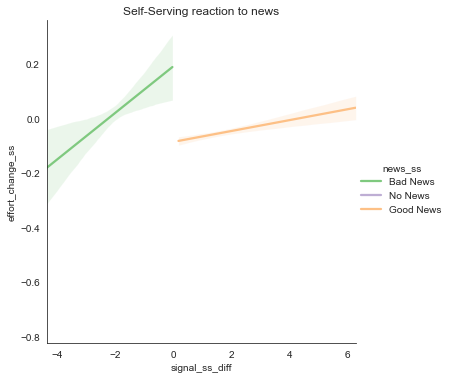

In [136]:
# plot the reaction to news of the self-serving
sns.lmplot(data=updates[(updates['round_number']>1)], x='signal_ss_diff', y='effort_change_ss',
                hue='news_ss', scatter=False, hue_order=['Bad News', 'No News', 'Good News'])
plt.title('Self-Serving reaction to news')
plt.savefig('../figures/news_reaction_ss.png')

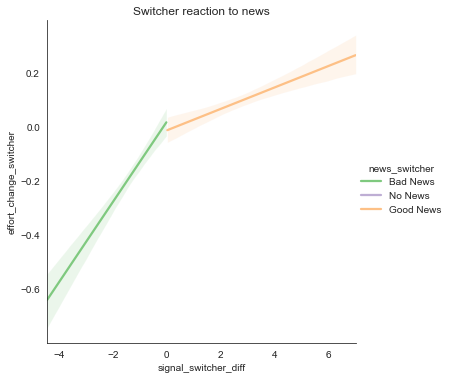

In [137]:
# plot the reaction to good and bad news for the switcher
sns.lmplot(data=updates[(updates['round_number']>1)], x='signal_switcher_diff', y='effort_change_switcher', 
           hue='news_switcher', scatter=False, hue_order=['Bad News', 'No News', 'Good News'])
plt.title('Switcher reaction to news')
plt.savefig('../figures/news_reaction_switcher.png')

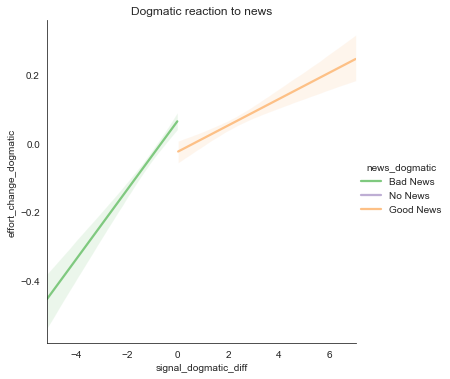

In [138]:
# plot the reaction to news of the dogmatic
sns.lmplot(data=updates[(updates['round_number']>1)], x='signal_dogmatic_diff', y='effort_change_dogmatic',
              hue='news_dogmatic', scatter=False, hue_order=['Bad News', 'No News', 'Good News'])
plt.title('Dogmatic reaction to news')
plt.savefig('../figures/news_reaction_dog.png')

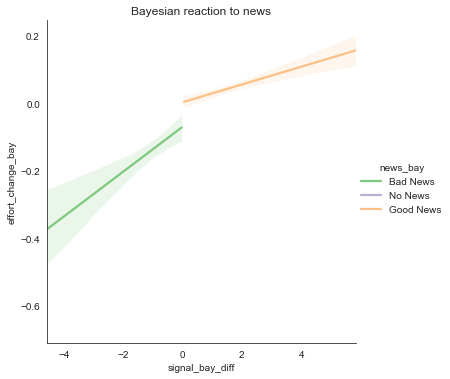

In [139]:
# plot the reaction to news of the bayesian
sns.lmplot(data=updates[(updates['round_number']>1)], x='signal_bay_diff', y='effort_change_bay',
                hue='news_bay', scatter=False, hue_order=['Bad News', 'No News', 'Good News'])
plt.title('Bayesian reaction to news')
# save
plt.savefig('../figures/news_reaction_bay.png')


# Learning

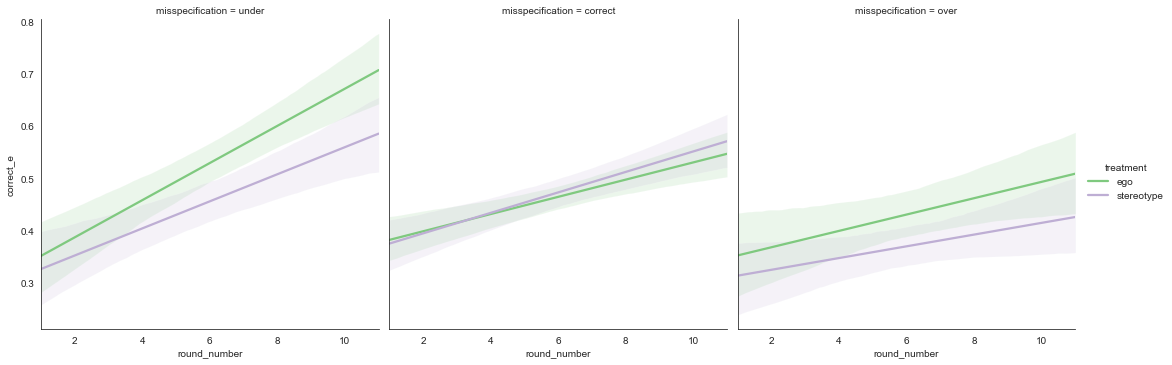

In [140]:
# plot the shatre of correct effort choices by misspecification
sns.lmplot(data=updates, x='round_number', y='correct_e', 
           hue='treatment', x_bins=5, scatter=False, 
           col='misspecification', col_order=['under', 'correct', 'over'])

Underconfident subjects learn faster than others. This is consistent with the likelihood ratio testing. Corroborate with simulations

(0.0, 1.0)

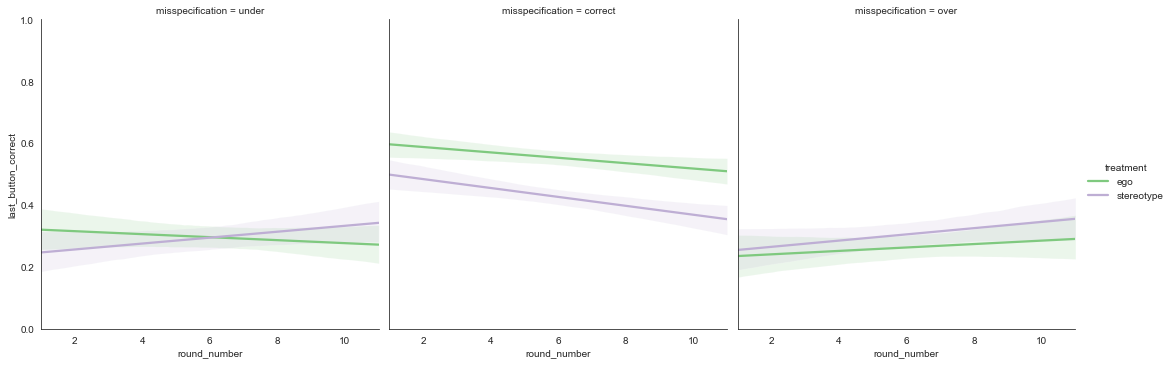

In [141]:
# plot the linear model between rounds and last_button by misspecification
fig =sns.lmplot(data=updates, x='round_number', y='last_button_correct', x_bins=6, 
                col='misspecification', hue='treatment', scatter=False, col_order=['under', 'correct', 'over'])
plt.ylim(0, 1)


# Positive/Negative signals

In [142]:
# make a column in updates  called 'signal_type' that is 'positive' if the previous round signal is more than 5 and negative if signal is less than 5.as_integer_ratio
updates['signal_type'] = 'negative'
updates.loc[updates['signal_prev']>=5, 'signal_type'] = 'positive'


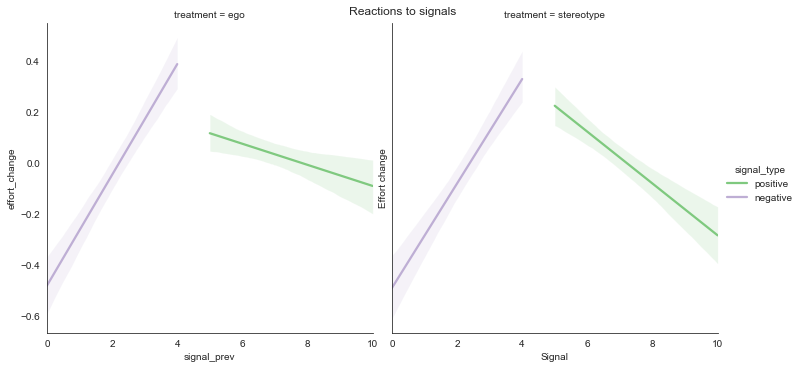

In [143]:
# plot the linear model between signal and effort by news type
sns.lmplot(data=updates[updates['round_number']>1], x='signal_prev', y='effort_change', 
                hue='signal_type', col='treatment', scatter=False, hue_order=['positive', 'negative'])
plt.suptitle('Reactions to signals')
plt.xlabel('Signal')
plt.ylabel('Effort change')
plt.savefig('../figures/signalvalue_effort_change.png')

In [144]:
# make an indicator column for positive signals that is 1 if signal_prev>=5
updates['positive_signal'] = 0
updates.loc[updates['signal_prev']>=5, 'positive_signal'] = 1
# run the regressions 
# all subjects
results = smf.ols('effort_change ~ signal_prev + positive_signal + signal_prev:positive_signal', data=updates[updates['round_number']>1]).fit()
results_stereo = smf.ols('effort_change ~ signal_prev + positive_signal + signal_prev:positive_signal', data=updates.loc[(updates['round_number']>1) & (updates['treatment']=='stereotype'), : ]).fit()
results_ego = smf.ols('effort_change ~ signal_prev + positive_signal + signal_prev:positive_signal', data=updates.loc[(updates['round_number']>1) & (updates['treatment']=='ego'), : ]).fit()
                    
print(results.summary())
print(results_stereo.summary())
print(results_ego.summary())

                            OLS Regression Results                            
Dep. Variable:          effort_change   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     85.58
Date:                Thu, 19 Oct 2023   Prob (F-statistic):           4.89e-54
Time:                        20:12:00   Log-Likelihood:                -7172.9
No. Observations:                5160   AIC:                         1.435e+04
Df Residuals:                    5156   BIC:                         1.438e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

# Certainties

<AxesSubplot:xlabel='belief', ylabel='certainty'>

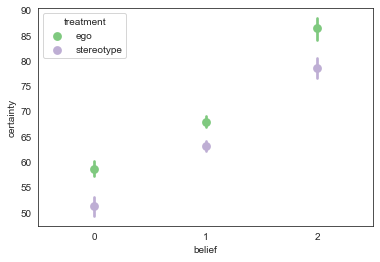

In [145]:
sns.pointplot(data=updates, x='belief', y='certainty', join=False, hue='treatment')

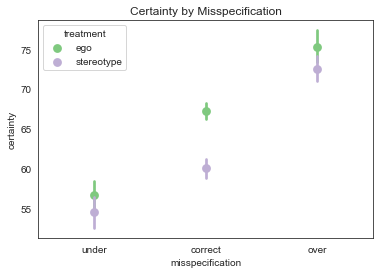

In [146]:
# point plot of the certainty by misspecification and by treatment
sns.pointplot(data=updates, x='misspecification_num', y='certainty', join=False, hue='treatment')
plt.xticks([0, 1, 2], ['under', 'correct', 'over'])
plt.xlabel('misspecification')
plt.title('Certainty by Misspecification')
plt.savefig('../figures/certainty_by_misspecification')

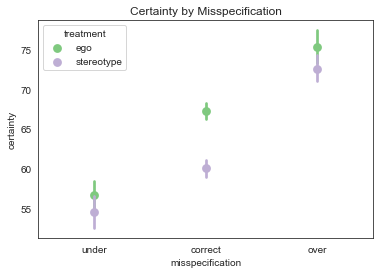

In [147]:
# point plot of the certainty by misspecification and by treatment
sns.pointplot(data=updates, x='misspecification_num', y='certainty', hue='treatment', join=False)
plt.xticks([0, 1, 2], ['under', 'correct', 'over'])
plt.xlabel('misspecification')
plt.title('Certainty by Misspecification')
plt.savefig('../figures/certainty_by_misspecification')

<AxesSubplot:xlabel='topic', ylabel='certainty'>

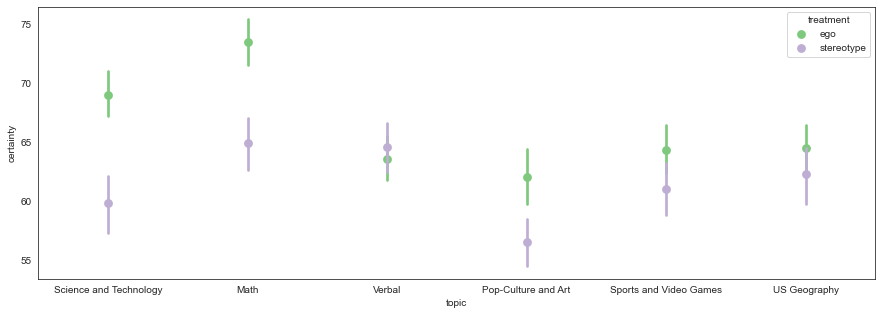

In [148]:
# point plot of the certainty by misspecification and by treatment
plt.figure(figsize=(15, 5))
sns.pointplot(data=updates, x='topic', y='certainty', join=False, hue='treatment')


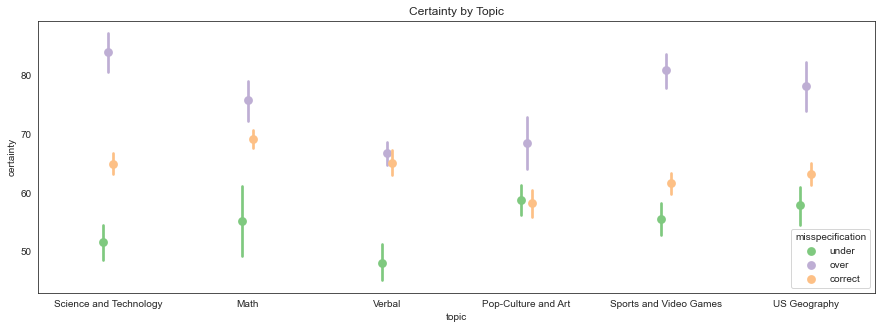

In [149]:
# point plot of the certainty by misspecification and by treatment
plt.figure(figsize=(15, 5))
sns.pointplot(data=updates, x='topic', y='certainty', join=False, hue='misspecification', dodge=True)
plt.title('Certainty by Topic')
# save the plot
plt.savefig('../figures/certainty_by_topic')

## Dogmatic v Switcher

In [150]:
# for the cases in which we can compare between switcher and dogmatic
# get the absolute value distance to the predicted paths
dogmatic_updates['distance_switcher_abs']=np.abs(dogmatic_updates['distance_switcher'])
dogmatic_updates['distance_dogmatic_abs']=np.abs(dogmatic_updates['distance_dogmatic'])

In [151]:
# take the average distance to the predicted path
dogmatic_updates[['distance_switcher_abs', 'distance_dogmatic_abs']].mean()

distance_switcher_abs    0.656300
distance_dogmatic_abs    0.886762
dtype: float64

In [152]:
# test if the distances are different
stats.ttest_ind(dogmatic_updates['distance_dogmatic_abs'], dogmatic_updates['distance_switcher_abs'])

Ttest_indResult(statistic=8.479077900561807, pvalue=3.81813781480506e-17)

In [153]:
len(dogmatic_updates['player_code'].unique())

114

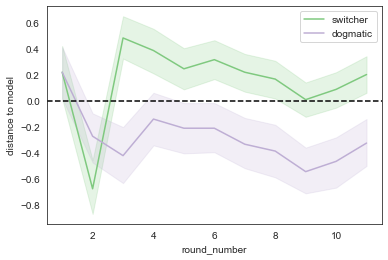

In [154]:
# plot the average distance to the switcher and dogmatic by round
sns.lineplot(data=dogmatic_updates, x='round_number', y='distance_switcher', label='switcher')
sns.lineplot(data=dogmatic_updates, x='round_number', y='distance_dogmatic', label='dogmatic')
plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('distance to model')
plt.title('')
# save
plt.savefig('../figures/distances_switch_dog.png')

In [155]:
dogmatic_updates = dogmatic_updates.merge(subject_models[['code', 'best_model_abs']], on='code', how='left')

In [156]:
dogmatic_updates

,index,code,round_number,effort,fails,last_button,score,topic,signal,belief,...,signals_dogmatic,signals_bay,distance_bayes,distance_switcher,distance_dogmatic,distance_bayesian,distance_self-serving,distance_switcher_abs,distance_dogmatic_abs,best_model_abs
0,0,0m2xzxgv,1,1,9,2,9,Science and Technology,1,0,...,0,0,0,1,1,0,0,1,1,1.0
1,1,0m2xzxgv,2,1,7,1,9,Science and Technology,3,0,...,4,2,0,-1,0,0,0,1,0,1.0
2,2,0m2xzxgv,3,2,10,2,9,Science and Technology,0,0,...,5,2,2,2,0,2,1,2,0,1.0
3,3,0m2xzxgv,4,0,7,0,9,Science and Technology,3,0,...,0,4,0,0,-1,0,-1,0,1,1.0
4,4,0m2xzxgv,5,0,8,1,9,Science and Technology,2,0,...,4,4,0,0,-1,0,-1,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1249,5671,zwzznpo6,7,0,2,1,10,US Geography,8,0,...,5,5,-2,-1,-2,-2,-1,1,2,0.0
1250,5672,zwzznpo6,8,0,5,1,10,US Geography,5,0,...,5,5,-2,-1,-2,-2,-1,1,2,0.0
1251,5673,zwzznpo6,9,1,5,1,10,US Geography,5,0,...,4,5,-1,0,-1,-1,0,0,1,0.0
1252,5674,zwzznpo6,10,0,8,1,10,US Geography,2,0,...,2,5,-2,-1,-2,-2,0,1,2,0.0


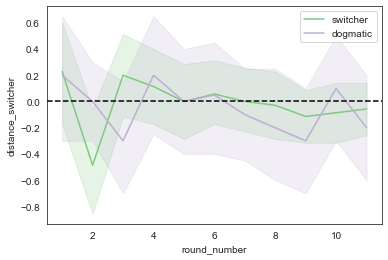

In [157]:
# use only the people for whom either dogmatic or bayesian are the best models
# plot the average distance to the switcher and dogmatic by round
sns.lineplot(data=dogmatic_updates[dogmatic_updates['best_model_abs']==0], x='round_number', y='distance_switcher', label='switcher')
sns.lineplot(data=dogmatic_updates[dogmatic_updates['best_model_abs']==1], x='round_number', y='distance_dogmatic', label='dogmatic')
plt.axhline(y=0, color='black', linestyle='--')


In [158]:
# plot but only for those for whom each model is the best fit


In [159]:
dogmatic_updates.columns

Index(['index', 'code', 'round_number', 'effort', 'fails', 'last_button',
       'score', 'topic', 'signal', 'belief', 'certainty', 'theta', 'omega',
       'treatment', 'overconfident', 'underconfident', 'correct',
       'misspecification', 'gender', 'nationality', 'misspecification_num',
       'round_misspecification', 'topic_num', 'player_code', 'effort_change',
       'effort_change_indicator', 'effort_change_sum',
       'last_button_consistent', 'last_button_correct', 'treatment_indic',
       'interaction', 'current_belief_start', 'belief_change',
       'change_indicator', 'change_indicator_sum', 'effort_next',
       'gender_nationality', 'stereotype', 'stereotype_round', 'lr', 'log_lr',
       'switcher', 'dogmatic', 'bayesian', 'self-serving', 'switcher_belief',
       'signals_ss', 'signals_switcher', 'signals_dogmatic', 'signals_bay',
       'distance_bayes', 'distance_switcher', 'distance_dogmatic',
       'distance_bayesian', 'distance_self-serving', 'distance_switcher

## Byesian V Self-Serving

In [160]:
# take the average distance to the predicted path for bayesian and self-serving
updates[['distance_bayesian_abs', 'distance_self-serving_abs']].mean()

distance_bayesian_abs        0.751233
distance_self-serving_abs    0.697674
dtype: float64

In [161]:
# test if the distances are different
stats.ttest_ind(updates['distance_bayesian_abs'], updates['distance_self-serving_abs'])

Ttest_indResult(statistic=4.441494891104236, pvalue=9.018108287411033e-06)

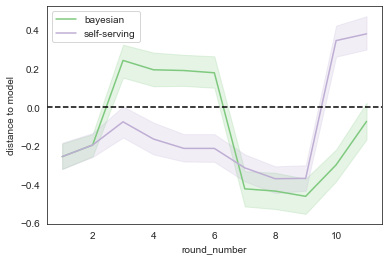

In [162]:
 # plot the average distance to the switcher and dogmatic by round
sns.lineplot(data=updates, x='round_number', y='distance_bayesian', label='bayesian')
sns.lineplot(data=updates, x='round_number', y='distance_self-serving', label='self-serving')
plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('distance to model')
# save
plt.savefig('../figures/distances_bay_ss.png')

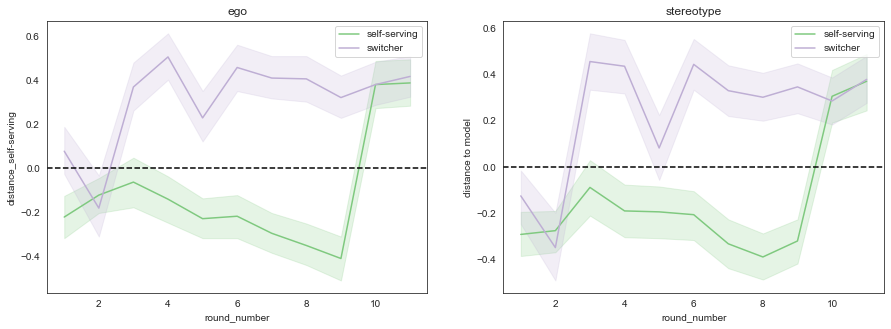

In [163]:
# plot the two treatments side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# plot the average distance to the switcher and dogmatic by round
sns.lineplot(data=updates[(updates['treatment']=='ego')], x='round_number', y='distance_self-serving', label='self-serving', ax=axs[0])
sns.lineplot(data=updates[(updates['treatment']=='ego')], x='round_number', y='distance_switcher', label='switcher', ax=axs[0])
axs[0].axhline(y=0, color='black', linestyle='--')
plt.ylabel('distance to model')
axs[0].set_title('ego')

sns.lineplot(data=updates[(updates['treatment']=='stereotype')], x='round_number', y='distance_self-serving', label='self-serving', ax=axs[1])
sns.lineplot(data=updates[(updates['treatment']=='stereotype')], x='round_number', y='distance_switcher', label='switcher', ax=axs[1])
axs[1].axhline(y=0, color='black', linestyle='--')
axs[1].set_title('stereotype')
# save
plt.savefig('../figures/distances_bay_ss.png')

(0.0, 2.0)

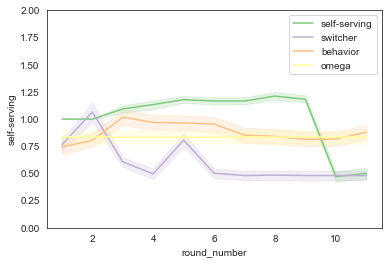

In [164]:
# plot the self_serving and switcher by round
sns.lineplot(data=updates, x='round_number', y='self-serving', label='self-serving')
sns.lineplot(data=updates, x='round_number', y='switcher', label='switcher')
sns.lineplot(data=updates, x='round_number', y='effort', label='behavior')
sns.lineplot(data=updates, x='round_number', y='omega', label='omega')
plt.ylim(0, 2)


# Optimal choices by model fit

(0.0, 1.0)

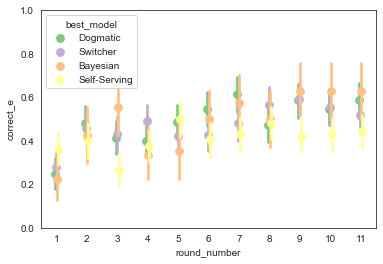

In [165]:
# plot the share of correct choices by model fit for each of the model
sns.pointplot(data=updates, x='round_number', y='correct_e', join=False, hue='best_model', dodge=True)
plt.ylim(0, 1)

# Calculate the parameters of the self-serving bias

In [166]:
# Load the simulation from the self_serving model
sim_ss = pd.read_csv("../Simulations/demo/data/simulation_ss.csv")


sim_ss

In [167]:
sim_ss = sim_ss[['round', 'effort', 'theta', 'omega', 'c_H', 'c_M', 'c_L', 'prior']]
sim_ss.rename(columns={'round':'round_number', 'effort':'effort_sim', 'prior':'certainty'}, inplace=True)

In [168]:
data = updates[['effort', 'round_number', 'certainty', 'belief', 'treatment', 'theta', 'omega', 'player_code', 'code']]

In [169]:
data_sim_ss = data.merge(sim_ss)

In [170]:
data_sim_ss = sim_ss.merge(data, on=['round_number', 'theta', 'omega', 'certainty'], how='right')

In [171]:
data_sim_ss['distance'] =(data_sim_ss ['effort']-data_sim_ss['effort_sim'])**2


In [172]:
distances_ss = data_sim_ss.groupby(['player_code', 'certainty', 'c_H', 'c_M', 'c_L'])['distance'].sum().reset_index()

In [173]:
# multiple parameter sets might minimize the distance
# take the average of the parameters for each player_code, each certainty and each distance
distances_ss = distances_ss.groupby(['player_code', 'certainty', 'distance']).mean()

In [174]:
distances_ss.reset_index(inplace=True)
distances_ss = distances_ss[(distances_ss['c_H']<=distances_ss['c_M']) & (distances_ss['c_M']<=distances_ss['c_L'])]

In [175]:
# for each player_code, find the values of c_good and c_bad that minimize the distance in distances_ss

min_distance = distances_ss.groupby('player_code').min('distance').reset_index()


In [176]:
c_H_est = min_distance['c_H'].mean()
c_M_est = min_distance['c_M'].mean()
c_L_est = min_distance['c_L'].mean()

In [177]:
print('The smallest parameter'+str(c_H_est))
print('The middle parameter'+str(c_M_est))
print('The largest parameter'+str(c_L_est))

The smallest parameter0.11255974513244522
The middle parameter0.24598665528358085
The largest parameter1.0


# Learners and non-learners
Separate people who managed to learn from those who did not

In [178]:
# take the players that learned the last k
k = 3
# separate the player_code for which correct_e is 1 for all round_numbers greater than 5
codes_learned = updates[updates['round_number']>(10-k)].groupby('player_code').filter(lambda x: x['correct_e'].sum()>=k)['player_code'].unique()
# all other players
codes_not_learned = updates[updates['round_number']>(10-k)].groupby('player_code').filter(lambda x: x['correct_e'].sum()<k)['player_code'].unique()

In [179]:
# in updates add a column called learned that is 1 if the player_code is in codes_learned and 0 otherwise
updates['learned'] = 0
updates.loc[updates['player_code'].isin(codes_learned), 'learned'] = 1


In [180]:
updates.loc[updates['learned']==0, 'learning'] = 'non-learner'
updates.loc[updates['learned']==1, 'learning'] = 'learner'

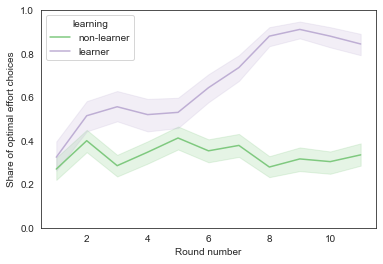

<Figure size 432x288 with 0 Axes>

In [181]:
# plot the correct_e by round for the learned and not learned
sns.lineplot(data=updates, x='round_number', y='correct_e', hue='learning', legend='brief')


plt.ylim(0, 1)
plt.xlabel('Round number')
plt.ylabel('Share of optimal effort choices')



plt.show()
# save
plt.savefig('../figures/learning_groups.png')

In [182]:
# calculate the share of player_codes that learned
len(codes_learned)/(len(codes_learned)+len(codes_not_learned))


0.375968992248062

## Is learning about $\omega$ correlated with learning about $\theta$?

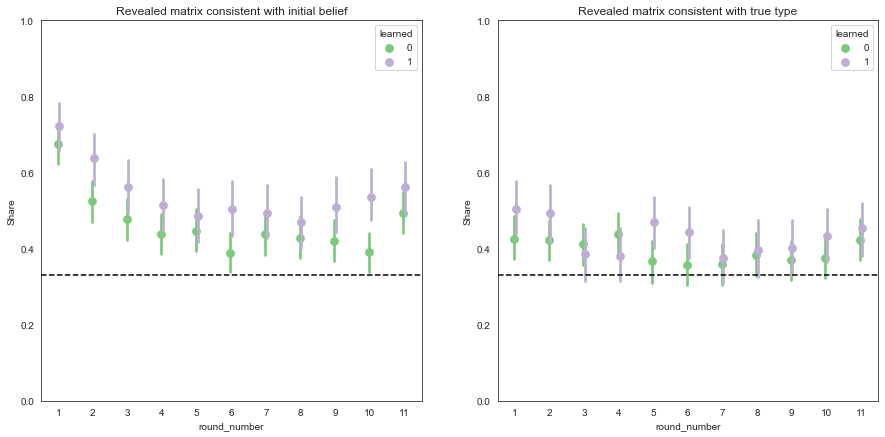

In [183]:
# plot the share of player_codes for which last_button in round_number 1 is the same as belief
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
sns.set_style("white")
sns.pointplot(data=updates, x='round_number', y='last_button_consistent', 
              hue='learned', dodge=True, ax=axs[0], join=False)
axs[0].set_ylim((0, 1))
axs[0].set_title('Revealed matrix consistent with initial belief')
axs[0].set_ylabel('Share')

sns.pointplot(data=updates, x='round_number', y='last_button_correct', 
              hue='learned', dodge=True, ax=axs[1], join=False)
axs[1].set_ylim((0, 1))
axs[1].set_title('Revealed matrix consistent with true type')
axs[1].set_ylabel('Share')

#plot a horizontal line at .33 in each plot
axs[0].axhline(y=.33, color='black', linestyle='--')
axs[1].axhline(y=.33, color='black', linestyle='--')

# save figure
plt.savefig('../figures/last_button_consistency_learners_treatment.png', dpi=300, bbox_inches='tight')


<AxesSubplot:xlabel='last_button_correct', ylabel='Count'>

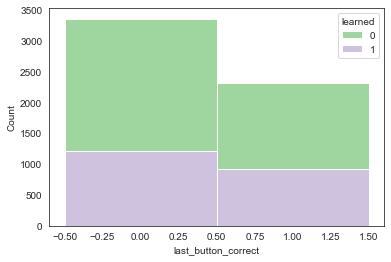

In [184]:
# plot a histogram of last button 
sns.histplot(data=updates, x='last_button_correct', hue='learned', multiple='stack', discrete=True)

# By overall share of correct answers
guessed more than half corectly

In [185]:
# get the player codes for which the sum of correct_e is more than 5
codes_learned_all = updates.groupby('player_code').filter(lambda x: x['correct_e'].sum()>5)['player_code'].unique()
# all other players
codes_not_learned_all = updates.groupby('player_code').filter(lambda x: x['correct_e'].sum()<=5)['player_code'].unique()

In [186]:
# add a column called learned_all that is 1 if the player_code is in codes_learned_all and 0 otherwise
updates['learned_all'] = 0
updates.loc[updates['player_code'].isin(codes_learned_all), 'learned_all'] = 1

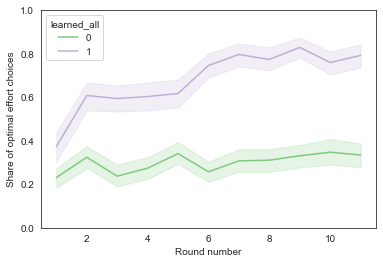

In [187]:
# plot the correct_e by round for the learned and not learned
sns.lineplot(data=updates, x='round_number', y='correct_e', hue='learned_all')
plt.ylim(0, 1)
plt.ylabel('Share of optimal effort choices')
plt.xlabel('Round number')

plt.savefig('../figures/learning_all.png')

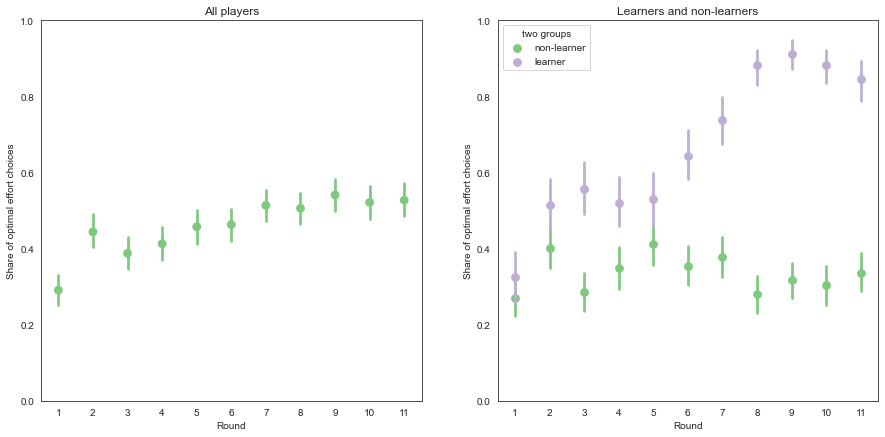

In [188]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

sns.pointplot(data=updates, x='round_number', y='correct_e',
                join =False, dodge=True, ax=axs[0])

axs[0].set_xlabel('Round')
axs[0].set_ylabel('Share of optimal effort choices')
axs[0].set_ylim(0, 1)
axs[0].set_title('All players')

sns.pointplot(data=updates, x='round_number', y='correct_e', hue='learning', 
              join=False, ax=axs[1], )
axs[1].set_ylim(0, 1)
axs[1].set_ylabel('Share of optimal effort choices')
axs[1].set_xlabel('Round')
axs[1].legend(title='two groups', loc='upper left')
axs[1].set_title('Learners and non-learners')

# save
plt.savefig('../figures/learning_groups.png')

## The non-learners

<AxesSubplot:xlabel='misspecification_num', ylabel='Probability'>

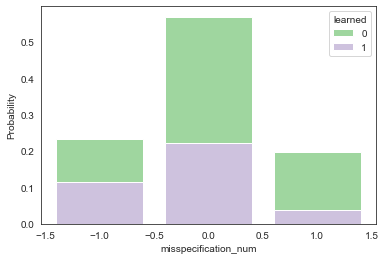

In [189]:
# plot a histogram of the misspecifications for the learned and not learned
sns.histplot(data=updates, x='misspecification_num', hue='learned', multiple='stack', discrete=True, stat='probability', shrink=.8)

<AxesSubplot:xlabel='best_model', ylabel='Probability'>

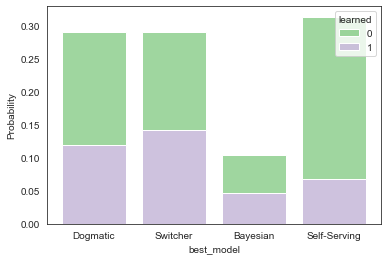

In [190]:
# plot a histogram of the treatment for the learned and not learned
sns.histplot(data=updates, x='best_model', hue='learned', multiple='stack', discrete=True, stat='probability', shrink=.8)

<AxesSubplot:xlabel='round_number', ylabel='round_misspecification'>

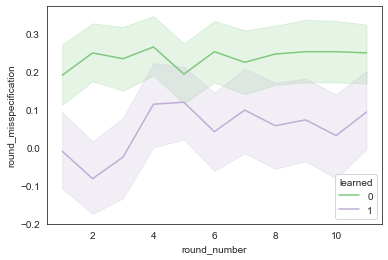

In [191]:
# plot the round_misspecification by round number for the learned and not learned
sns.lineplot(data=updates, x='round_number', y='round_misspecification', hue='learned')

<AxesSubplot:xlabel='round_number', ylabel='effort'>

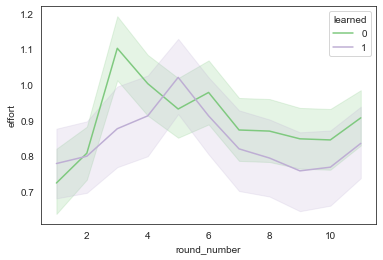

In [192]:
# plot the effort choices for those that learned and did not learn
sns.lineplot(data=updates, x='round_number', y='effort', hue='learned')


[Text(0.5, 1.0, 'Learners')]

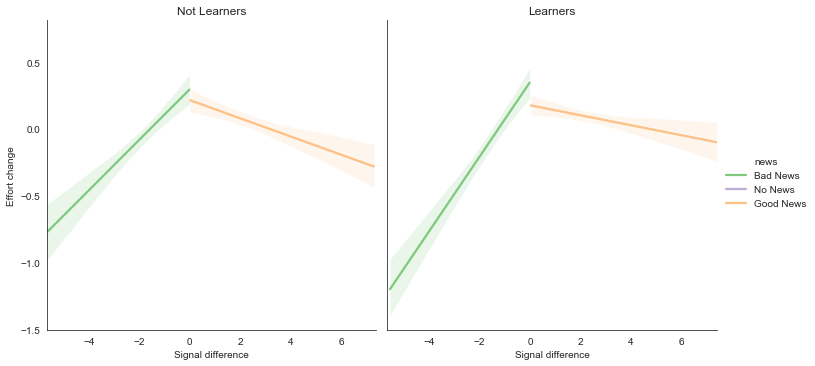

In [193]:
# plot a lm of effort_change on news_diff for the learned and not learned
p = sns.lmplot(data=updates[(updates['round_number']>1)], x='news_diff', y='effort_change', 
           hue='news', scatter=False, hue_order=['Bad News', 'No News', 'Good News'], col='learned')


plt.xlabel('Signal difference')
p.facet_axis(0, 0).set( ylabel= 'Effort change', title='Not Learners', xlabel='Signal difference')
p.facet_axis(0, 1).set(  title='Learners')


# Traps

In [194]:
# identify the player_codes that were subject to self-defeating equilibria
# add a column called trap that is 1 if the theta, omega and initial belief are prone to a self-confirming trap

updates['trap'] = 0
updates.loc[(updates['theta']==0) & (updates['omega']==2) , 'trap'] = 1
updates.loc[(updates['theta']==1) & (updates['omega']==0) , 'trap'] = 1
updates.loc[(updates['theta']==1) & (updates['omega']==1) , 'trap'] = 1
updates.loc[(updates['theta']==1) & (updates['omega']==1) , 'trap'] = 1
updates.loc[(updates['theta']==1) & (updates['omega']==2) , 'trap'] = 1
updates.loc[(updates['theta']==2) & (updates['omega']==1) , 'trap'] = 1


<AxesSubplot:xlabel='learned_all', ylabel='Probability'>

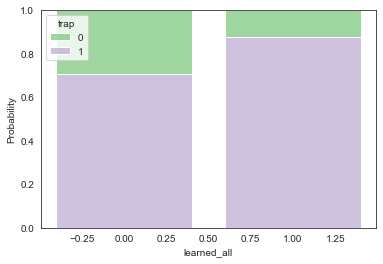

In [195]:
# Plot a histogram of learned_all for the traps
sns.histplot(data=updates, x='learned_all', hue='trap', multiple='fill', discrete=True, stat='probability', shrink=.8)


In [196]:
# create a column called learned_num that is 0 if learned is 'not learned', 1 if learned is 'last 3' and 2 if learned is 'last 5'
updates['learned_num'] = 0
updates.loc[updates['learned']==1, 'learned_num'] = 1

learned = updates.groupby('player_code')['treatment', 'trap', 'learned_num'].max()

<ipython-input-196-675b9ab48fd3>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  learned = updates.groupby('player_code')['treatment', 'trap', 'learned_num'].max()


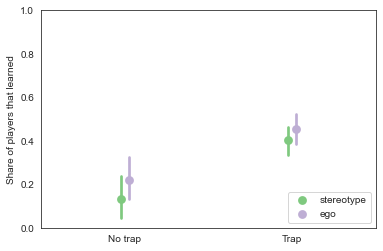

In [197]:
sns.pointplot(data=learned, y='learned_num', x='trap', hue='treatment', join=False, dodge=True)
plt.xlabel('')
plt.ylabel('Share of players that learned')
plt.ylim(0, 1)
plt.xticks([0, 1], ['No trap', 'Trap'])

plt.legend(loc='lower right')
# save
plt.savefig('../figures/learning_trap_presence.png')

In [198]:
misp = updates.groupby('player_code')['treatment', 'trap', 'learned', 'misspecification_num', 'theta', 'omega'].max()

<ipython-input-198-c3b3679e8ced>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  misp = updates.groupby('player_code')['treatment', 'trap', 'learned', 'misspecification_num', 'theta', 'omega'].max()


(0.0, 1.0)

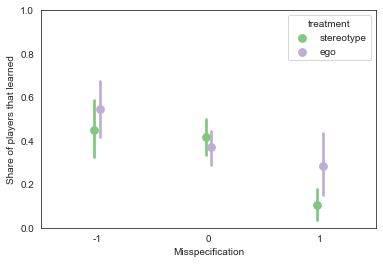

In [199]:
sns.pointplot(data=misp, y='learned', x='misspecification_num', hue='treatment', join=False, dodge=True)
plt.xlabel('Misspecification')
plt.ylabel('Share of players that learned')
plt.ylim(0, 1)


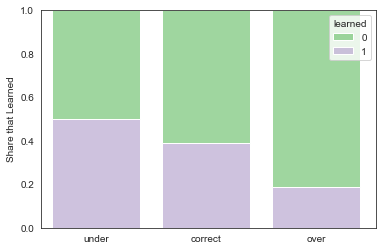

In [200]:

sns.histplot(data=updates, x='misspecification_num', 
             hue='learned', shrink=.8, stat='probability', discrete=True, multiple='fill')
plt.xticks([-1, 0, 1], ['under', 'correct', 'over'])
plt.xlabel('')
plt.ylabel('Share that Learned')

# save
plt.savefig('../figures/learners_misspecification.png')

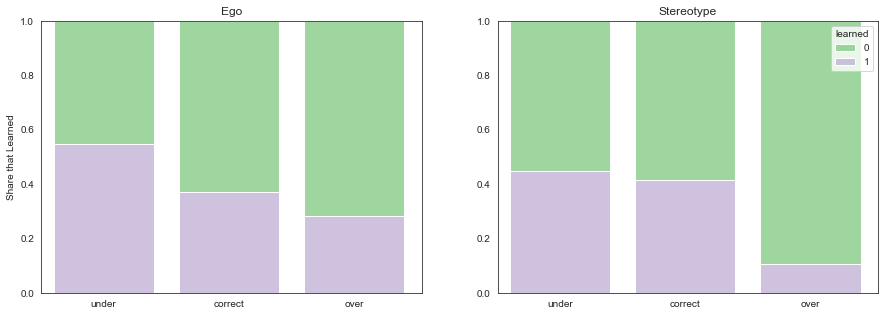

In [201]:
# make two plots, one for each treatment
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=updates[updates['treatment']=='ego'], x='misspecification_num', 
             hue='learned', shrink=.8, stat='probability', discrete=True, multiple='fill', ax=axs[0], legend=False)
axs[0].set_xticks([-1, 0, 1], ['under', 'correct', 'over'])
axs[0].set_xlabel('')
axs[0].set_ylabel('Share that Learned')

sns.histplot(data=updates[updates['treatment']=='stereotype'], x='misspecification_num', 
             hue='learned', shrink=.8, stat='probability', discrete=True, multiple='fill', ax=axs[1])
axs[1].set_xticks([-1, 0, 1], ['under', 'correct', 'over'])
axs[1].set_xlabel('')
axs[1].set_ylabel('')

axs[0].set_title('Ego')
axs[1].set_title('Stereotype')

# save
plt.savefig('../figures/misspecification_learning_treatment.png')


(0.0, 1.0)

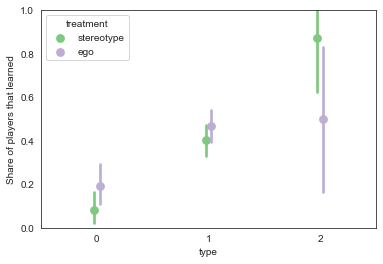

In [202]:
sns.pointplot(data=misp, y='learned', x='theta', hue='treatment', join=False, dodge=True)
plt.xlabel('type')
plt.ylabel('Share of players that learned')
plt.ylim(0, 1)# 

(0.0, 1.0)

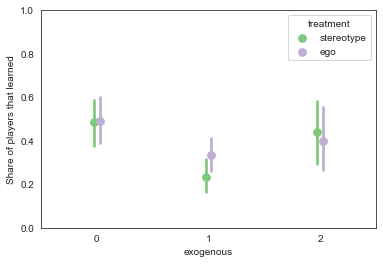

In [203]:
sns.pointplot(data=misp, y='learned', x='omega', hue='treatment', join=False, dodge=True)
plt.xlabel('exogenous')
plt.ylabel('Share of players that learned')
plt.ylim(0, 1)

(0.0, 1.0)

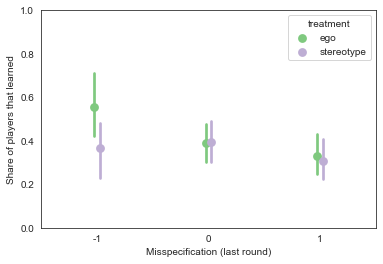

In [204]:
sns.pointplot(data=updates[updates['round_number']==11], y='learned', x='round_misspecification', hue='treatment', join=False, dodge=True)
plt.xlabel('Misspecification (last round)')
plt.ylabel('Share of players that learned')
plt.ylim(0, 1)

In [205]:
# creat a column called trap_choice that is 1 if the player_code is in a trap 

updates['trap_choice'] = 0

updates.loc[((updates['theta']==0) & (updates['omega']==2) & (updates['effort'] == 0)) |
                           ((updates['theta']==1) & (updates['omega']==0) & (updates['effort'] ==1))|
                           ((updates['theta']==1) & (updates['omega']==1) & (updates['effort'] ==2))|
                           ((updates['theta']==1) & (updates['omega']==1) & (updates['effort'] ==0))|
                           ((updates['theta']==1) & (updates['omega']==2) & (updates['effort'] ==1)), 'trap_choice'] = 1

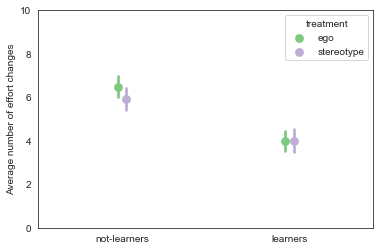

In [206]:
# plot the average number of times that each player_code changed belief
sns.pointplot(data=updates[(updates['round_number']==1) & (updates['trap']==1)], y='effort_change_sum', x='learned', hue='treatment', join=False, dodge=True)
plt.xlabel('')
plt.ylabel('Average number of effort changes')
plt.ylim(0, 10)
plt.xticks([0, 1], ['not-learners', 'learners'])

# save
plt.savefig('../figures/effort_changes.png')


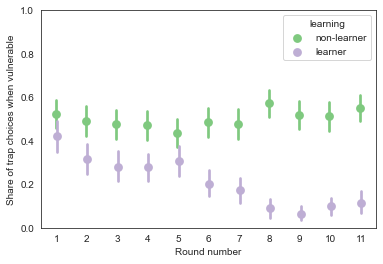

In [207]:
# plot the trap choices by round for the learned and not learned
sns.pointplot(data=updates[updates['trap']==1], x='round_number', y='trap_choice', 
              hue='learning', join=False, dodge=True)
plt.ylim(0, 1)
plt.ylabel('Share of trap choices when vulnerable')
plt.xlabel('Round number')

# save
plt.savefig('../figures/trap_choice_round.png')


In [208]:
# take subjects for whom 3 out of the last 4 choices were trap_choice
codes_trap = updates[updates['round_number']>7].groupby('player_code').filter(lambda x: x['trap_choice'].sum()>=3)['player_code'].unique()

# add a column called trapped that is 1 if the player_code is in codes_trap and 0 otherwise
updates['trapped'] = 0
updates.loc[updates['player_code'].isin(codes_trap), 'trapped'] = 1

# calculate the share of subjects that were trapped
len(codes_trap)/len(updates['player_code'].unique())

0.1686046511627907

In [209]:
updates['categorized'] = 'neither'
updates.loc[(updates['trapped']==1), 'categorized']= 'trapped'
updates.loc[(updates['learned']==1), 'categorized']= 'learned'

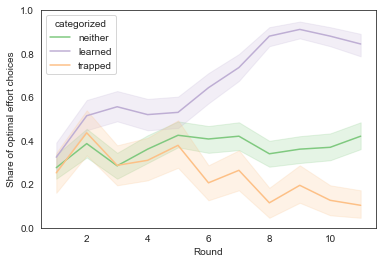

In [210]:
# plot the share of optimal choices by round for each category
sns.lineplot(data=updates, x='round_number', y='correct_e', hue='categorized')
plt.ylabel('Share of optimal effort choices')
plt.xlabel('Round')
plt.ylim(0, 1)

# save
plt.savefig('../figures/categorized.png')


<AxesSubplot:xlabel='best_model', ylabel='Probability'>

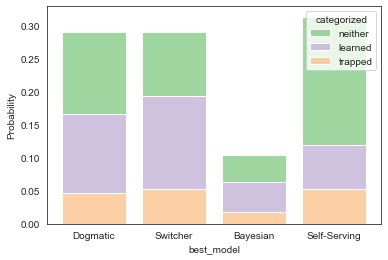

In [211]:
sns.histplot(data=updates, x='best_model', hue='categorized', multiple='stack', discrete=True, stat='probability', shrink=.8)

In [212]:
updates['parametrization'] = 'trap'
updates.loc[(updates['trap']==0), 'parametrization']= 'no trap'

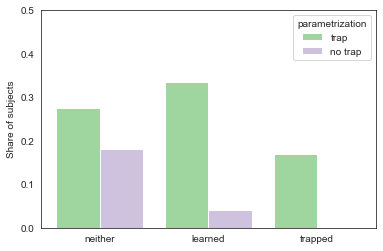

In [213]:
sns.histplot(data=updates, x='categorized', hue='parametrization', multiple='dodge', discrete=True, stat='probability', shrink=.8)
plt.xlabel('')
plt.ylabel('Share of subjects')
plt.ylim(0, .5)

# save
plt.savefig('../figures/trap_learning.png')

<AxesSubplot:xlabel='categorized', ylabel='misspecification_num'>

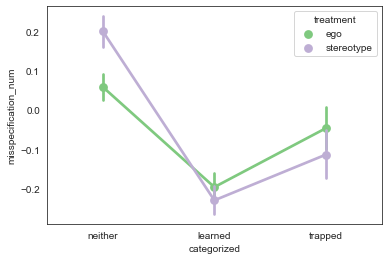

In [214]:
sns.pointplot(data=updates, x='categorized', y='misspecification_num', hue='treatment')

In [215]:
# calculate the distance of the effor to omega
updates['distance_omega'] = np.abs(updates['effort']-updates['omega'])


<AxesSubplot:xlabel='round_number', ylabel='distance_omega'>

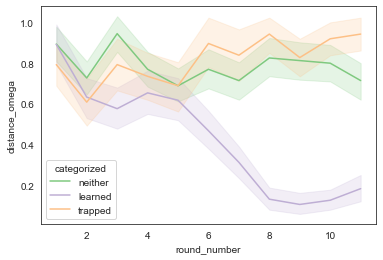

In [216]:
# plot distance omega by round for all the categorized
sns.lineplot(data=updates, x='round_number', y='distance_omega', hue='categorized')

(0.0, 10.0)

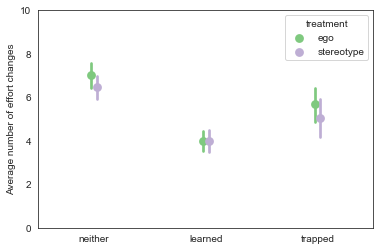

In [217]:
sns.pointplot(data=updates[(updates['round_number']==1) & (updates['trap']==1)], y='effort_change_sum', x='categorized', hue='treatment', join=False, dodge=True)
plt.xlabel('')
plt.ylabel('Average number of effort changes')
plt.ylim(0, 10)


(0.0, 1.0)

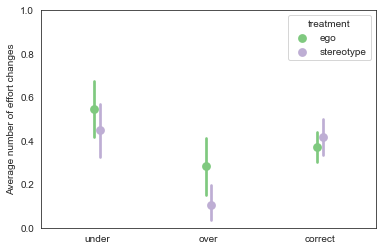

In [218]:
sns.pointplot(data=updates[(updates['round_number']==1)], y='learned', x='misspecification', hue='treatment', join=False, dodge=True)
plt.xlabel('')
plt.ylabel('Average number of effort changes')
plt.ylim(0, 1)

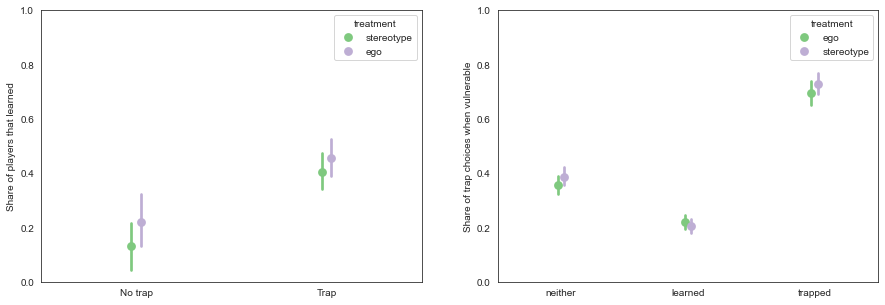

In [219]:




# plot the share of trap_choice by learned_all
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.pointplot(data=learned, y='learned_num', x='trap', 
              hue='treatment', join=False, dodge=True, ax=axs[0])
axs[0].set_xlabel('')
axs[0].set_ylabel('Share of players that learned')
axs[0].set_ylim(0, 1)
axs[0].set_xticks([0, 1], ['No trap', 'Trap'])



sns.pointplot(data=updates[updates['trap']==1], y='trap_choice', x='categorized', 
              hue='treatment', join=False, dodge=True, ax=axs[1])
axs[1].set_xlabel('')
axs[1].set_ylabel('Share of trap choices when vulnerable')
axs[1].set_ylim(0, 1)




# save
plt.savefig('../figures/trap_choice.png')

(-1.3, 1.3)

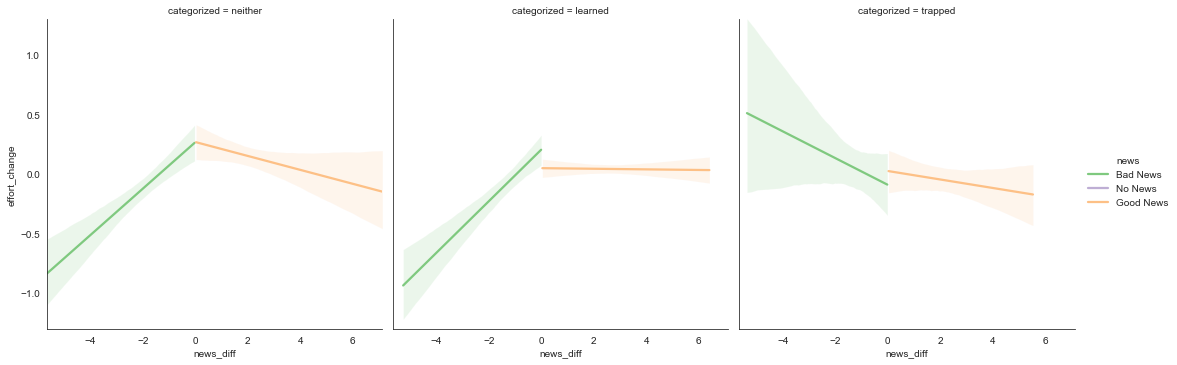

In [220]:

# plot a regression of effort change on news_diff for each of the news
sns.lmplot(data=updates[updates['round_number']>5], x='news_diff', y='effort_change', 
           hue='news', scatter=False, hue_order=['Bad News', 'No News', 'Good News'], col='categorized')

plt.ylim(-1.3, 1.3) 

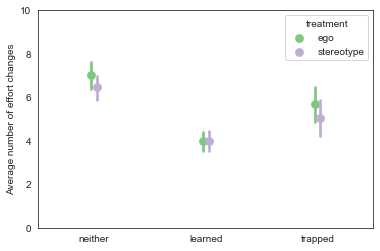

In [221]:
#plot the average number of effort changes for each of the categories
sns.pointplot(data=updates[(updates['round_number']==1) & (updates['trap']==1)], y='effort_change_sum', x='categorized', hue='treatment', join=False, dodge=True)
plt.xlabel('')
plt.ylabel('Average number of effort changes')
plt.ylim(0, 10)

# save
plt.savefig('../figures/switching.png')

In [222]:
# calculate the share of subjects that were trapped when trap=1
len(updates[(updates['trap']==1) & (updates['trapped']==1)]['player_code'].unique())/len(updates[(updates['trap']==1)]['player_code'].unique())

0.21641791044776118

In [223]:
# share of subjects that learned when trap=1
len(updates[(updates['trap']==1) & (updates['learned']==1)]['player_code'].unique())/len(updates[(updates['trap']==1)]['player_code'].unique())

0.43034825870646765

In [224]:
updates['good_news'] = 0
updates.loc[updates['news']=='Good News', 'good_news'] = 1

In [225]:
updates['good_news'].mean()

0.5715292459478506

<AxesSubplot:xlabel='categorized', ylabel='certainty'>

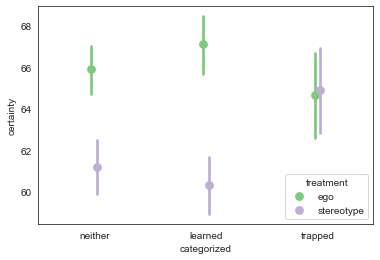

In [226]:
# certainties by group
sns.pointplot(data=updates, x='categorized', y='certainty', join=False, hue='treatment', dodge=True)

<AxesSubplot:xlabel='categorized', ylabel='Count'>

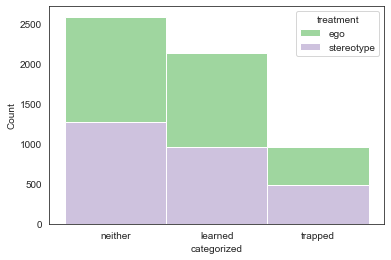

In [227]:
# plot the histogram of categories by treatment
sns.histplot(data=updates, x="categorized", hue='treatment',
             discrete=True, multiple='stack')

<AxesSubplot:xlabel='misspecification', ylabel='Probability'>

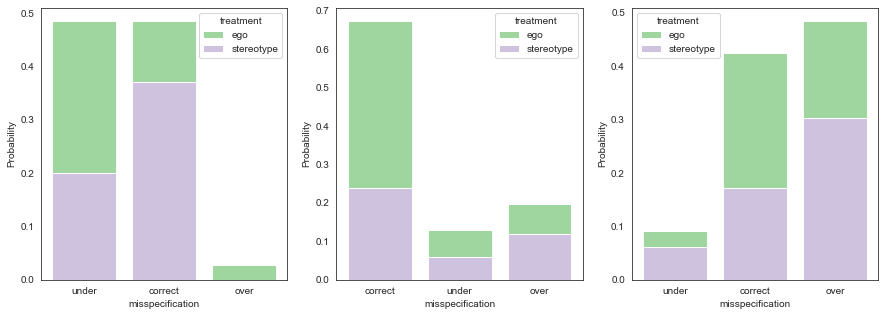

In [228]:
data = updates[(updates['round_number']==11) & (updates['categorized']=='neither')]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(data=data[data['round_misspecification']==-1], x="misspecification", hue='treatment', ax=axs[0], shrink=.8, stat='probability', discrete=True, multiple='stack')

sns.histplot(data=data[data['round_misspecification']==0], x="misspecification", hue='treatment', ax=axs[1], shrink=.8, stat='probability', discrete=True, multiple='stack')

sns.histplot(data=data[data['round_misspecification']==1], x="misspecification", hue='treatment', ax=axs[2], shrink=.8, stat='probability', discrete=True, multiple='stack')

In [229]:
# save the data
updates.to_csv('../Clean/updates_post.csv', index=False)

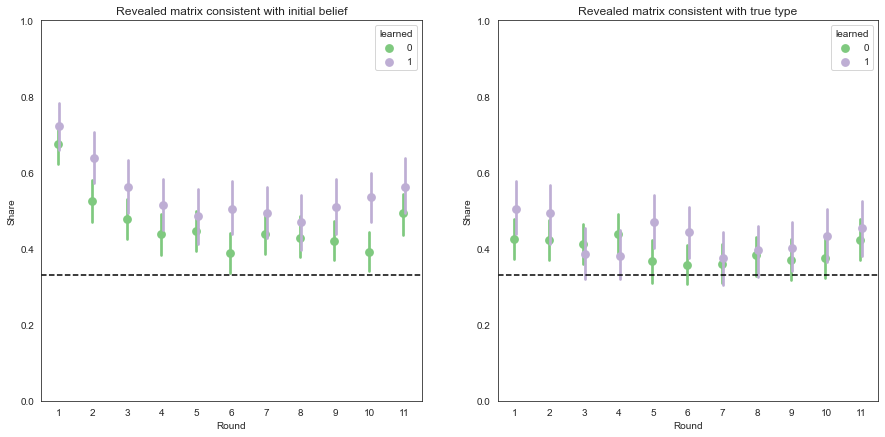

In [230]:
# calculate the share of player_codes for which last_button in round_number 1 is the same as bel


# plot the share of player_codes for which last_button in round_number 1 is the same as belief
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
sns.set_style("white")
sns.pointplot(data=updates, x='round_number', y='last_button_consistent', hue='learned',
              dodge=True, ax=axs[0], join=False)
axs[0].set_ylim((0, 1))
axs[0].set_title('Revealed matrix consistent with initial belief')
axs[0].set_ylabel('Share')
axs[0].set_xlabel('Round')

sns.pointplot(data=updates, x='round_number', y='last_button_correct', hue='learned',
            dodge=True, ax=axs[1], join=False)
axs[1].set_ylim((0, 1))
axs[1].set_title('Revealed matrix consistent with true type')
axs[1].set_ylabel('Share')
axs[1].set_xlabel('Round')

#plot a horizontal line at .33 in each plot
axs[0].axhline(y=.33, color='black', linestyle='--')
axs[1].axhline(y=.33, color='black', linestyle='--')

# save figure
plt.savefig('../figures/last_button_consistency_treatment.png', dpi=300, bbox_inches='tight')